In [35]:
from scipy.stats import entropy
import numpy as np

x = np.ones(100) + np.random.rand(100)*0.1
y = np.ones(100) + np.random.rand(100)*0.1

print(entropy(np.log(x),np.log(y)))

0.4818519497341076


In [1]:
from os import listdir
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pickle 
from itertools import islice, product

from scipy.stats import spearmanr as spear
from sklearn.metrics import r2_score
import math

import py3Dmol
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, rdMolDescriptors, MolFromSmiles, MolToSmiles, Draw, MolFromPDBFile
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.rdmolops import GetSymmSSSR
from rdkit.Chem.rdmolfiles import MolFromPDBBlock
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

remover = SaltRemover()

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.dpi'] = 150
%matplotlib notebook

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

# Read Data and Generate Conformations

In [4]:
import Bio.PDB as PDB

def duplicate_conformers(m: Chem.rdchem.Mol, new_conf_idx: int, rms_limit: float = 0.5) -> bool:
    rmslist = []
    for i in range(m.GetNumConformers()):
        if i == new_conf_idx:
            continue
        rms = AllChem.GetConformerRMS(m, new_conf_idx, i, prealigned=True)
        rmslist.append(rms)
    return any(i < rms_limit for i in rmslist)


def get_mcs(mol_one: Chem.rdchem.Mol, mol_two: Chem.rdchem.Mol) -> str:
    """Code to find the maximum common substructure between two molecules."""
    return Chem.MolToSmiles(
        Chem.MolFromSmarts(
            rdFMCS.FindMCS([mol_one,mol_two], completeRingsOnly=True, matchValences=True).smartsString
        )
    )


def generate_conformers(mol, ref_mol, num_conf, ref_smi, minimum_conf_rms):
    # if SMILES to be fixed are not given, assume to the MCS
    if not ref_smi:
        ref_smi = get_mcs(mol, ref_mol)
    print('Aligning {}'.format(ref_smi))
    # Creating core of reference ligand #
    try:
        core_with_wildcards = AllChem.ReplaceSidechains(ref_mol, Chem.MolFromSmiles(ref_smi))

        core = AllChem.DeleteSubstructs(core_with_wildcards, Chem.MolFromSmiles('*'))
        core.UpdatePropertyCache()

        # Add Hs so that conf gen is improved
        mol.RemoveAllConformers()
        mol = Chem.AddHs(mol)

        # Generate conformers with constrained embed
        dup_count = 0
        for i in range(num_conf):
            temp_mol = AllChem.ConstrainedEmbed(deepcopy(mol), core, ignoreSmoothingFailures=True,randomseed=i)
            conf_idx = mol.AddConformer(temp_mol.GetConformer(0), assignId=True)
            if minimum_conf_rms is not None:
                if duplicate_conformers(mol, conf_idx, rms_limit=minimum_conf_rms):
                    dup_count += 1
                    mol.RemoveConformer(conf_idx)
        if dup_count:
            print(f'removed {dup_count} duplicated conformations')
        return mol
    except Exception as ex:
        core_with_wildcards = AllChem.ReplaceSidechains(ref_mol, Chem.MolFromSmiles(get_mcs(mol, ref_mol)))
        core = AllChem.DeleteSubstructs(core_with_wildcards, Chem.MolFromSmiles('*'))
        core.UpdatePropertyCache()

        # Add Hs so that conf gen is improved
        mol.RemoveAllConformers()
        mol = Chem.AddHs(mol)

        # Generate conformers with constrained embed
        dup_count = 0
        for i in range(num_conf):
            temp_mol = AllChem.ConstrainedEmbed(deepcopy(mol), core, ignoreSmoothingFailures=True,useRandomCoords=True,useTethers=True,randomseed=i)
            conf_idx = mol.AddConformer(temp_mol.GetConformer(0), assignId=True)
            if minimum_conf_rms is not None:
                if duplicate_conformers(mol, conf_idx, rms_limit=minimum_conf_rms):
                    dup_count += 1
                    mol.RemoveConformer(conf_idx)
        if dup_count:
            print(f'removed {dup_count} duplicated conformations')
        return mol
    
class ProteinLigandClashFilter:
    def __init__(self, protein_pdbpath: str, distance: float = 1.5):
        parser = PDB.PDBParser(QUIET=True, PERMISSIVE=True)
        s = parser.get_structure('protein', protein_pdbpath)
        self.kd = PDB.NeighborSearch(list(s.get_atoms()))
        self.radius = distance

    def __call__(self, conf: Chem.rdchem.Conformer) -> bool:
        for coord in conf.GetPositions():
            res = self.kd.search(coord, radius=self.radius)
            if len(res):
                return True
        return False

In [5]:
# filenames = [ f for f in listdir('data/cov_and_noncov/') if f[-5:]=='0.pdb']
# df = pd.read_csv('data/cov_and_noncov/hits_summary.csv')
# df = df.set_index('Dataset')

# frags = []
# for f in tqdm(filenames):
#     try:
#         #read SMILES from .csv
#         dataname = f[:-6]
#         smiles = df.loc[dataname]['Compound SMILES']
#         mol = AllChem.MolFromSmiles(smiles)
#         mol = remover.StripMol(mol)
#         smiles = MolToSmiles(mol)

#         #read coords from PDB
#         file = open('data/cov_and_noncov/'+f, 'r')
#         data = file.read().splitlines()
#         ligand = [line+'\n' for line in data if 'LIG' in line and 'HETATM' in line]
#         pdbblock = ''.join(ligand)
#         read_mol = MolFromPDBBlock(pdbblock)
#         ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, read_mol)

#         #constrained conformer generation
#         mol = Chem.AddHs(mol)
#         mol = generate_conformers(mol, ref_mol, 100, ref_smi = smiles, minimum_conf_rms=0.5)
#         print('Remaining conformations after removing duplicates: {}'.format(mol.GetNumConformers()))

# #         #check for protein clashes
# #         pdb_path = 'data/cov_and_noncov/'+dataname+'_0_new.pdb'
# #         clash_filter = ProteinLigandClashFilter(pdb_path, distance=0.5)
# #         for conf in mol.GetConformers():
# #             if clash_filter(conf):
# #                 confid = conf.GetId()
# #                 print(f'removing conformer id: {confid}')
# #                 mol.RemoveConformer(confid)
# #         print('Remaining conformations after removing clashes: {}'.format(mol.GetNumConformers()))

#         conf = mol.GetConformer()

#         ligand_data = [mol]
#         for j,atom in enumerate(mol.GetAtoms()):
#             ligand_data.append([atom.GetSymbol(),
#                                 conf.GetPositions()[j]])

#         frags.append(ligand_data)

# #     hit_data.append(mol_row['Fluorescence avg IC50 (uM)'].values[0])

# #     hits.append(hit_data)
#     except Exception as ex:
#         print("Couldn't generate conformers for {}".format(smiles))
#         print(ex)

  0%|          | 0/70 [00:00<?, ?it/s]

Couldn't generate conformers for CC(=O)N[C@@H](C(=O)NCC#CBr)[C@@H](C)O
No matching found
Couldn't generate conformers for O=C(NC1CCN(C(=O)CCl)CC1)c1ccccc1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCCC(c2nc3ccccc3s2)C1
No matching found
Aligning Cc1nnc(CN2CCC=C(F)C2)s1


  6%|▌         | 4/70 [00:02<00:35,  1.88it/s]

removed 71 duplicated conformations
Remaining conformations after removing duplicates: 29
Couldn't generate conformers for CC(C)N(C)C(=O)C1CCN(C(=O)CCl)CC1
No matching found
Couldn't generate conformers for O=C(CCl)NCc1ccc2c(c1)OCO2
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(S(=O)(=O)c2ccc(Cl)cc2)CC1
No matching found
Couldn't generate conformers for COc1ccc(NC(=O)C2CCN(C(=O)CCl)CC2)cn1
No matching found
Aligning O=C(Nc1ccccc1)Nc1cccnc1


 13%|█▎        | 9/70 [00:04<00:30,  1.97it/s]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Couldn't generate conformers for CC(=O)N1CCN(C(=O)CCl)CC1
No matching found
Aligning N#Cc1ccc(CNC(=O)N2CCOCC2)cc1


 16%|█▌        | 11/70 [00:07<00:52,  1.12it/s]

removed 90 duplicated conformations
Remaining conformations after removing duplicates: 10
Aligning CN1CCN(C(=O)Cc2c[nH]c3ncccc23)CC1


 17%|█▋        | 12/70 [00:12<01:57,  2.03s/it]

removed 63 duplicated conformations
Remaining conformations after removing duplicates: 37
Couldn't generate conformers for Cc1ccc(S(=O)(=O)N2CCN(C(=O)CCl)CC2)cc1
No matching found
Couldn't generate conformers for O=C(CCl)Nc1cccnc1Cl
No matching found
Couldn't generate conformers for O=C(CCl)N1CCC(C(=O)N2CCCCC2)CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(S(=O)(=O)c2ccccc2F)CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(S(=O)(=O)c2ccc(Cl)s2)CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(Cc2cccs2)CC1
No matching found
Aligning N#Cc1ncccn1


 29%|██▊       | 20/70 [00:12<01:11,  1.43s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning N#Cc1ccc(N2CCCOCC2)cn1


 30%|███       | 21/70 [00:15<01:20,  1.65s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Couldn't generate conformers for O=C(CCl)N(c1ccccc1)C1C=CS(=O)(=O)C1
No matching found
Couldn't generate conformers for Cc1ccc(C(=O)N2CCN(C(=O)CCl)CC2)cc1
No matching found
Aligning CCNc1ccc(C#N)cn1


 34%|███▍      | 24/70 [00:15<00:57,  1.24s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning Cc1cc(CN(C)C(=O)NC2CC2)no1


 36%|███▌      | 25/70 [00:19<01:29,  1.98s/it]

removed 42 duplicated conformations
Remaining conformations after removing duplicates: 58
Aligning CCC(=N)N


 37%|███▋      | 26/70 [00:20<01:06,  1.51s/it]

removed 76 duplicated conformations
Remaining conformations after removing duplicates: 24
Aligning NC(=O)[C@H]1CCC[C@H]1c1ccsc1


 39%|███▊      | 27/70 [00:22<01:12,  1.69s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Couldn't generate conformers for Cc1ccc(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c(C)c1
No matching found
Couldn't generate conformers for COc1cccc2sc(NC(=O)CCl)nc12
No matching found
Aligning COC(=O)c1ccc(S(N)(=O)=O)cc1


 43%|████▎     | 30/70 [00:23<00:53,  1.34s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Couldn't generate conformers for O=C(CCl)NNC(=O)c1cc2c(s1)CCCC2
No matching found
Aligning O=C(NCCc1ccncc1)NC1CCCCC1


 46%|████▌     | 32/70 [00:29<01:08,  1.81s/it]

removed 60 duplicated conformations
Remaining conformations after removing duplicates: 40
Couldn't generate conformers for CC(NC(=O)CCl)c1cccc(Cl)c1
No matching found
Couldn't generate conformers for CC(NC(=O)CCl)c1cccc2ccccc12
No matching found
Aligning OC1CCN(Cc2ccsc2)CC1


 50%|█████     | 35/70 [00:31<00:50,  1.46s/it]

removed 75 duplicated conformations
Remaining conformations after removing duplicates: 25
Couldn't generate conformers for CC(=O)NC(CC(N)=O)C(=O)NCC#CBr
No matching found
Couldn't generate conformers for COc1ccc(N2CCN(C(=O)CCl)CC2)cc1
No matching found
Couldn't generate conformers for Cc1ccccc1CN1CCCN(C(=O)CCl)CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(c2ccccc2[N+](=O)[O-])CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(C(=O)c2cccs2)CC1
No matching found
Couldn't generate conformers for Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1
No matching found
Couldn't generate conformers for Cc1cccc(CN2CCN(C(=O)CCl)CC2)c1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(Cc2ccc(Br)s2)CC1
No matching found
Couldn't generate conformers for Cc1ccc(N(C(=O)CCl)C2C=CS(=O)(=O)C2)cc1
No matching found
Couldn't generate conformers for O=C(CCl)Nc1cccc(C(=O)N2CCSCC2)c1
No matching found
Couldn't generate conformers for O=C(CCl)N1Cc2ccccc2C(c2ccccc2)

 67%|██████▋   | 47/70 [00:34<00:25,  1.11s/it]

removed 65 duplicated conformations
Remaining conformations after removing duplicates: 35
Couldn't generate conformers for O=C(CCl)N1CCN(Cc2cccc3ccccc23)CC1
No matching found
Aligning CS(=O)(=O)NCCc1ccccc1


 70%|███████   | 49/70 [00:37<00:22,  1.09s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Couldn't generate conformers for O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1
No matching found
Aligning CC(=O)NCCc1c[nH]c2ccc(F)cc12


 73%|███████▎  | 51/70 [00:40<00:23,  1.23s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Couldn't generate conformers for O=C(Nc1ccccc1O)C1CCN(C(=O)CCl)CC1
No matching found
Aligning O=C(NCCc1ccncc1)c1ccccc1F


 76%|███████▌  | 53/70 [00:43<00:23,  1.40s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Couldn't generate conformers for O=C(CCl)Nc1cccc(N2CCCC2=O)c1
No matching found
Aligning CC(=O)NC(Cc1ccc(O)cc1)C(=O)NCC#CBr


 79%|███████▊  | 55/70 [00:48<00:26,  1.76s/it]

removed 73 duplicated conformations
Remaining conformations after removing duplicates: 27
Couldn't generate conformers for O=C(CCl)N(c1ccc(F)cc1)C1C=CS(=O)(=O)C1
No matching found
Aligning NS(=O)(=O)c1ccc(Br)cc1


 81%|████████▏ | 57/70 [00:49<00:17,  1.35s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning CS(=O)(=O)c1ccc(N2CCNCC2)cc1


 83%|████████▎ | 58/70 [00:53<00:23,  1.98s/it]

removed 68 duplicated conformations
Remaining conformations after removing duplicates: 32
Couldn't generate conformers for O=C(CCl)N1CCOC(c2ccc(F)cc2)C1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(C(=O)c2ccco2)CC1
No matching found
Couldn't generate conformers for N#Cc1ccccc1S(=O)(=O)N1CCN(C(=O)CCl)CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(S(=O)(=O)c2c(F)cccc2F)CC1
No matching found
Aligning Nc1cncnc1


 90%|█████████ | 63/70 [00:53<00:09,  1.41s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Couldn't generate conformers for O=C(CCl)N1CCN(Cc2ccc(Cl)s2)CC1
No matching found
Aligning CN1CCCc2ccc(S(N)(=O)=O)cc21


 93%|█████████▎| 65/70 [00:56<00:06,  1.37s/it]

removed 69 duplicated conformations
Remaining conformations after removing duplicates: 31
Aligning CC(=O)Nc1cnccc1C


 94%|█████████▍| 66/70 [00:57<00:05,  1.36s/it]

removed 66 duplicated conformations
Remaining conformations after removing duplicates: 34
Aligning N#Cc1ncc[nH]1


 96%|█████████▌| 67/70 [00:57<00:03,  1.02s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1ccc(OCC(=O)N2CCN(C)CC2)cc1


100%|██████████| 70/70 [01:02<00:00,  1.12it/s]

removed 33 duplicated conformations
Remaining conformations after removing duplicates: 67
Couldn't generate conformers for O=C(CCl)N1CCN(Cc2ccsc2)CC1
No matching found
Couldn't generate conformers for O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1
No matching found


In [7]:
print(len(frags))

25


In [4]:
filenames = [ f for f in listdir('data/frags/') if f[-5:]=='0.pdb']
df = pd.read_csv('data/frags/Mpro_hits_summary.csv')
df = df.set_index('Dataset')

# frags = []
# for f in tqdm(filenames):
#     try:
#         #read SMILES from .csv
#         dataname = f[:-6]
#         smiles = df.loc[dataname]['Compound SMILES']
#         mol = AllChem.MolFromSmiles(smiles)
#         mol = remover.StripMol(mol)
#         smiles = MolToSmiles(mol)

#         #read coords from PDB
#         file = open('data/frags/'+f, 'r')
#         data = file.read().splitlines()
#         ligand = [line+'\n' for line in data if 'LIG' in line and 'HETATM' in line]
#         pdbblock = ''.join(ligand)
#         read_mol = MolFromPDBBlock(pdbblock)
#         ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, read_mol)

#         #constrained conformer generation
#         mol = Chem.AddHs(mol)
#         mol = generate_conformers(mol, ref_mol, 100, ref_smi = smiles, minimum_conf_rms=0.5)
#         print('Remaining conformations after removing duplicates: {}'.format(mol.GetNumConformers()))

#         #check for protein clashes
#         pdb_path = 'data/frags/'+dataname+'_0_new.pdb'
#         clash_filter = ProteinLigandClashFilter(pdb_path, distance=0.5)
#         for conf in mol.GetConformers():
#             if clash_filter(conf):
#                 confid = conf.GetId()
#                 print(f'removing conformer id: {confid}')
#                 mol.RemoveConformer(confid)
#         print('Remaining conformations after removing clashes: {}'.format(mol.GetNumConformers()))

#         conf = mol.GetConformer()

#         ligand_data = [mol]
#         for j,atom in enumerate(mol.GetAtoms()):
#             ligand_data.append([atom.GetSymbol(),
#                                 conf.GetPositions()[j]])

#         frags.append(ligand_data)

# #     hit_data.append(mol_row['Fluorescence avg IC50 (uM)'].values[0])

# #     hits.append(hit_data)
#     except Exception as ex:
#         print("Couldn't generate conformers for {}".format(smiles))
#         print(ex)

In [13]:
### NEW DATA READING 19/02/2021

df_activity = pd.read_csv('data/activity_data.csv')

df_activity['acrylamide'] = df_activity['acrylamide'].fillna(False)
df_activity['chloroacetamide'] = df_activity['chloroacetamide'].fillna(False)

print('Length of raw df_activity :{}'.format(len(df_activity)))

df_activity = df_activity[(~df_activity['acrylamide']) & (~df_activity['chloroacetamide'])]

print('Length of non-covalent df_activity :{}'.format(len(df_activity)))

df_compounds = pd.read_csv('data/Mpro_compound_tracker_csv.csv').rename(columns={'Compound ID': 'CID'})
df_compounds = df_compounds[df_compounds['Dataset'].notna()]

print('Length of df_compounds :{}'.format(len(df_compounds)))

df_activity = pd.merge(df_activity, df_compounds, on='CID')
df_activity = df_activity.drop_duplicates(subset='CID')

print('Length of merged df_activity :{}'.format(len(df_activity)))

print('Number of actives :{}'.format(len(df_activity[df_activity['f_avg_IC50']<5])))

hits = []
ids = []

bad_ids = []

for i,row in tqdm(df_activity.iterrows(), total=len(df_activity)):
    
    try:
        mol_path = 'data/aligned/'+row['Dataset']+'_0A/'+row['Dataset']+'_0A.pdb'
        mol_pdb = Chem.MolFromPDBFile(mol_path)

        mol = MolFromSmiles(row['SMILES_x'])
        ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, mol_pdb)

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        mol = generate_conformers(mol, ref_mol, 100, ref_smi = row['SMILES_x'], minimum_conf_rms=0.5)
        print('Remaining conformations after removing duplicates: {}'.format(mol.GetNumConformers()))

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        hit_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            hit_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        hit_data.append(row['f_avg_IC50'])

        hits.append(hit_data)
        ids.append(row['CID'])

    except Exception as ex:
        print("Couldn't generate conformers for {}".format(smiles))
        print(ex)
        
        bad_ids.append(row['CID'])
        
df_activity = df_activity[~df_activity['CID'].isin(bad_ids)]

print('Number of bad mols :{}'.format(len(bad_ids)))

print('{} hits left'.format(len(hits)))
print('{} hits left'.format(len(df_activity)))

print('Number of actives left:{}'.format(len(df_activity[df_activity['f_avg_IC50']<5])))

Length of raw df_activity :1699
Length of non-covalent df_activity :1449
Length of df_compounds :361


  0%|          | 0/233 [00:00<?, ?it/s]

Length of merged df_activity :233
Number of actives :39
Aligning Cn1c(=O)[nH]c2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c21


  0%|          | 1/233 [00:06<27:00,  6.99s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning COC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


  1%|          | 2/233 [00:14<27:50,  7.23s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning NC[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


  1%|▏         | 3/233 [00:36<43:49, 11.43s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning Cn1cnc2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c21


  2%|▏         | 4/233 [00:42<37:24,  9.80s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning O=C1CC(O)(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2N1


  2%|▏         | 5/233 [00:49<34:25,  9.06s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CC(=O)N1CCN(CC(=O)Nc2cnccc2C2CC2)CC1


  3%|▎         | 6/233 [00:56<32:36,  8.62s/it]

removed 28 duplicated conformations
Remaining conformations after removing duplicates: 72
Aligning Cc1ccncc1NC(=O)CN1CCC(C)CC1


  3%|▎         | 7/233 [01:02<29:07,  7.73s/it]

removed 18 duplicated conformations
Remaining conformations after removing duplicates: 82
Aligning O=C(Nc1cncc2ccccc12)[C@@H]1CCNc2ccc(Cl)cc21


  3%|▎         | 8/233 [01:09<28:00,  7.47s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning NC[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


  4%|▍         | 9/233 [01:16<27:46,  7.44s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Nc1cncc2cnccc12)[C@H]1CCOc2ccc(Cl)cc21


  4%|▍         | 10/233 [01:23<26:43,  7.19s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C1C(c2ccc(Cl)cc2)CCCN1c1cncc2ccccc12


  5%|▍         | 11/233 [01:29<25:07,  6.79s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C1NC2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12


  5%|▌         | 12/233 [01:35<24:17,  6.60s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1c[n+]([O-])cc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21


  6%|▌         | 13/233 [01:42<24:25,  6.66s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cncc2c1CNCC2)C1CCOc2ccc(Cl)cc21


  6%|▌         | 14/233 [01:48<23:53,  6.55s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1


  6%|▋         | 15/233 [01:53<21:53,  6.03s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cncc2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1


  7%|▋         | 16/233 [01:58<20:48,  5.75s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Nc1cncc2c1CCCN2C(=O)Cc1cccc(Cl)c1


  7%|▋         | 17/233 [02:03<19:46,  5.49s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning CCc1ccc2c(c1)C(=O)C(=O)N2CC(=O)O


  8%|▊         | 18/233 [02:06<16:42,  4.66s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning CN1CCC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21


  8%|▊         | 19/233 [02:13<19:17,  5.41s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1


  9%|▊         | 20/233 [02:21<22:14,  6.26s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1


  9%|▉         | 21/233 [02:22<16:07,  4.57s/it]

Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2c1CCC2


  9%|▉         | 22/233 [02:26<15:46,  4.48s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Cc1cccc(Cl)c1)Nc1nnc2ccccn12


 10%|▉         | 23/233 [02:29<14:37,  4.18s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C1CC(NC(=O)C2CCOc3ccc(Cl)cc32)CCN1


 10%|█         | 24/233 [02:34<15:31,  4.46s/it]

removed 71 duplicated conformations
Remaining conformations after removing duplicates: 29
Aligning Cc1ccn2cnnc2c1NC(=O)C1CCOc2ccc(Cl)cc21


 11%|█         | 25/233 [02:40<16:31,  4.77s/it]

removed 90 duplicated conformations
Remaining conformations after removing duplicates: 10


 11%|█         | 26/233 [02:48<19:33,  5.67s/it]

Aligning C[C@@H]1COc2ccc(Cl)cc2[C@@H]1C(=O)Nc1cncc2ccccc12
removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning COc1ccccc1OCCNC(=O)c1cncc2ccccc12


 12%|█▏        | 27/233 [02:53<19:17,  5.62s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning O=C(c1cncc2ccccc12)N1CCN(c2ccccc2)CC1


 12%|█▏        | 28/233 [03:00<20:27,  5.99s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(C(F)(F)F)c2)CC1


 12%|█▏        | 29/233 [03:07<21:02,  6.19s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning COc1ccccc1NC1CN(C(=O)c2cc(=O)[nH]c3ccccc23)C1


 13%|█▎        | 30/233 [03:18<25:59,  7.68s/it]

removed 89 duplicated conformations
Remaining conformations after removing duplicates: 11
Aligning COc1ccccc1OC1CN(C(=O)c2cc(=O)[nH]c3ccccc23)C1


 13%|█▎        | 31/233 [03:25<24:57,  7.41s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Cc1cc(Cl)ccn1)Nc1cncc2ccccc12


 14%|█▎        | 32/233 [03:28<20:45,  6.20s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)n1)Nc1cncc2ccccc12


 14%|█▍        | 33/233 [03:32<17:56,  5.38s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning CNC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cc2cncc3ccccc23)cc1


 15%|█▌        | 35/233 [03:32<12:35,  3.81s/it]

Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Nc1cncc2ccccc12)C1CCNc2ccc(Cl)cc21


 15%|█▌        | 36/233 [03:38<14:52,  4.53s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


 16%|█▌        | 37/233 [03:45<16:51,  5.16s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1ccncc1NC(=O)[C@@H](C)OC(F)F


 16%|█▋        | 38/233 [03:48<14:38,  4.51s/it]

removed 79 duplicated conformations
Remaining conformations after removing duplicates: 21
Aligning O=C(Cc1cc(Cl)cc2c1OCC2)Nc1cncc2ccccc12


 17%|█▋        | 39/233 [03:54<16:20,  5.06s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21


 17%|█▋        | 40/233 [04:01<17:41,  5.50s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning Cc1ccncc1NC(=O)[C@@H]1CCOc2ccc(Cl)cc21


 18%|█▊        | 41/233 [04:07<18:57,  5.92s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C(Cc1cccc(Cl)c1)Nn1nnc2ccccc21


 18%|█▊        | 42/233 [04:11<16:40,  5.24s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Bad input file data/aligned/Mpro_Nterm-x0050_0A/Mpro_Nterm-x0050_0A.pdb
Aligning CN(C)c1ccc(N(Cc2ccn[nH]2)C(=O)Cn2nnc3ccccc32)cc1


 19%|█▉        | 44/233 [04:20<15:59,  5.08s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19


 20%|██        | 47/233 [04:30<14:01,  4.52s/it]

Aligning Cc1noc(COc2cc(Cl)cc(CC(=O)Nc3cnccc3C)c2)n1
removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning CN(C)c1ccc(N(Cc2cscn2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Aligning CC(=O)N1CCN(CC(=O)Nc2cncc3ccccc23)CC1


 21%|██        | 48/233 [04:37<16:00,  5.19s/it]

removed 73 duplicated conformations
Remaining conformations after removing duplicates: 27
Aligning COC(=O)C(C(=O)Nc1cnccc1C)c1cccc(Cl)c1


 21%|██        | 49/233 [04:42<15:45,  5.14s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2ccncc12


 21%|██▏       | 50/233 [04:46<14:53,  4.88s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2nc[nH]c12


 22%|██▏       | 51/233 [04:49<13:09,  4.34s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CN(C)c1ccc(N(Cc2ccccc2)C(=O)Cn2nnc3ccccc32)cc1


 22%|██▏       | 52/233 [04:58<17:21,  5.75s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1


 23%|██▎       | 53/233 [05:08<20:57,  6.99s/it]

removed 90 duplicated conformations
Remaining conformations after removing duplicates: 10
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(-c2ccc(C)c(F)c2F)c1


 23%|██▎       | 54/233 [05:15<21:01,  7.05s/it]

removed 89 duplicated conformations
Remaining conformations after removing duplicates: 11
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2CCCC2O)c1


 24%|██▎       | 55/233 [05:25<23:10,  7.81s/it]

removed 56 duplicated conformations
Remaining conformations after removing duplicates: 44
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2CC2C(F)(F)F)c1


 24%|██▍       | 56/233 [05:34<23:42,  8.04s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NCC(C)(C)C#N)c1


 24%|██▍       | 57/233 [05:44<25:33,  8.71s/it]

removed 49 duplicated conformations
Remaining conformations after removing duplicates: 51
Aligning Cc1ccncc1NC(=O)CCc1cccc(Cl)c1


 25%|██▍       | 58/233 [05:48<21:50,  7.49s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2cnccc12


 25%|██▌       | 59/233 [05:52<18:18,  6.31s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2cccnc12


 26%|██▌       | 60/233 [05:56<15:55,  5.52s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CN(C(=O)Cc1cccc(Cl)c1)c1cncc2ccccc12


 26%|██▌       | 61/233 [06:00<15:08,  5.28s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning COc1cccc(Oc2cc(Cl)cc(NC(=O)Cc3cncc4ccccc34)c2)n1


 27%|██▋       | 62/233 [06:08<17:03,  5.98s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cncc2ccccc12)C1CCOc2ccc(Cl)cc21


 27%|██▋       | 63/233 [06:13<16:08,  5.70s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COc1cc(OC)nc(C#N)n1


 27%|██▋       | 64/233 [06:14<12:07,  4.31s/it]

removed 65 duplicated conformations
Remaining conformations after removing duplicates: 35
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2ncccc12


 28%|██▊       | 65/233 [06:17<11:13,  4.01s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cnc2ccccn12


 28%|██▊       | 66/233 [06:21<10:36,  3.81s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cn1cncc1NC(=O)Cc1cccc(Cl)c1


 29%|██▉       | 67/233 [06:23<09:32,  3.45s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CN(Cc1cccc(Cl)c1)C(=O)Cn1nnc2ccccc21


 29%|██▉       | 68/233 [06:29<11:04,  4.03s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning C#Cc1cccc(CC(=O)Nc2cncc3ccccc23)c1


 30%|██▉       | 69/233 [06:33<10:54,  3.99s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C1C(c2cccc(Cl)c2)CCCN1c1cncc2ccccc12


 30%|███       | 70/233 [06:38<11:32,  4.25s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Bad input file data/aligned/Mpro_Nterm-x0066_0A/Mpro_Nterm-x0066_0A.pdb
Aligning COc1ccc(Cl)cc1CC(=O)Nc1cncc2ccccc12


 31%|███       | 72/233 [06:42<09:49,  3.66s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CC(=O)NCc1cc(Cl)cc(CC(=O)Nc2cnccc2C)c1


 31%|███▏      | 73/233 [06:49<12:15,  4.60s/it]

removed 80 duplicated conformations
Remaining conformations after removing duplicates: 20
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2c1CCCC2


 32%|███▏      | 74/233 [06:53<12:03,  4.55s/it]

removed 91 duplicated conformations
Remaining conformations after removing duplicates: 9
Aligning CC(C)OCCCN(Cc1ccco1)C(=O)Nc1cn(C)c(=O)c2ccccc12


 32%|███▏      | 75/233 [07:05<17:55,  6.81s/it]

removed 41 duplicated conformations
Remaining conformations after removing duplicates: 59
Aligning O=C(Cc1cccc(Cl)c1)Nc1nncc2ccccc12


 33%|███▎      | 76/233 [07:09<15:16,  5.84s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1ncn2ccccc12


 33%|███▎      | 77/233 [07:12<13:17,  5.11s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cnccc1-c1ccccc1


 33%|███▎      | 78/233 [07:18<13:18,  5.15s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Nc1nncn1C1CC1)C1CCOc2ccccc21


 34%|███▍      | 79/233 [07:22<12:35,  4.90s/it]

removed 83 duplicated conformations
Remaining conformations after removing duplicates: 17
Aligning Cc1cccc(COC(=O)c2cccc3c2NC(=O)C3=O)c1


 34%|███▍      | 80/233 [07:27<12:27,  4.89s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CCOc1ccccc1CN1C(=O)C(=O)c2cc(Br)ccc21


 35%|███▍      | 81/233 [07:31<11:44,  4.64s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning COc1ccc(CN2C(=O)C(=O)c3cc(Br)cc(C)c32)cc1OC


 35%|███▌      | 82/233 [07:36<11:58,  4.76s/it]

removed 64 duplicated conformations
Remaining conformations after removing duplicates: 36
Aligning COC(=O)c1cc(Br)cc2c1NC(=O)C2=O


 36%|███▌      | 83/233 [07:37<09:21,  3.74s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C1C(=O)N(Cc2ncon2)c2ccc(Br)cc21


 36%|███▌      | 84/233 [07:39<07:39,  3.08s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning COc1cc(Cl)cc(CC(=O)Nc2cnccc2C)c1


 36%|███▋      | 85/233 [07:44<08:48,  3.57s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NS(N)(=O)=O)c1


 37%|███▋      | 86/233 [07:50<10:38,  4.34s/it]

removed 83 duplicated conformations
Remaining conformations after removing duplicates: 17
Aligning O=C(Nc1nncn1C1CC1)[C@@H]1CCOc2ccc(Cl)cc21


 37%|███▋      | 87/233 [07:55<10:57,  4.50s/it]

removed 85 duplicated conformations
Remaining conformations after removing duplicates: 15
Aligning O=C(Nc1nncn1C1CC1)[C@H]1CCOc2ccc(Cl)cc21


 38%|███▊      | 88/233 [08:00<11:18,  4.68s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning CC1(C(=O)Nc2nncn2C2CC2)CCOc2ccccc21


 39%|███▉      | 91/233 [08:06<08:33,  3.62s/it]

removed 71 duplicated conformations
Remaining conformations after removing duplicates: 29
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Aligning O=C(Nc1cnccc1CO)C1CCOc2ccc(Cl)cc21


 39%|███▉      | 92/233 [08:11<09:12,  3.92s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Nc1nncn1C1CC1)C1COc2ccc(Cl)cc21


 40%|███▉      | 93/233 [08:14<08:54,  3.81s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning O=C(Nc1nncn1-c1ccccc1)C1COc2ccc(Cl)cc21


 40%|████      | 94/233 [08:19<09:32,  4.12s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12


 41%|████      | 95/233 [08:23<09:08,  3.98s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1ccncc1CC(=O)Nc1cccc2c1CNCC2


 41%|████      | 96/233 [08:28<09:53,  4.33s/it]

removed 83 duplicated conformations
Remaining conformations after removing duplicates: 17
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Bad input file data/aligned/Mpro_Nterm-x0029_0A/Mpro_Nterm-x0029_0A.pdb
Aligning O=C(Cc1cccc(Cl)c1)Nc1cccc2[nH]ncc12


 42%|████▏     | 98/233 [08:31<07:55,  3.52s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Cc1cccc(Cl)c1)Nc1cn[nH]c1


 43%|████▎     | 100/233 [08:33<06:05,  2.75s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1[nH]ncc1CC(=O)Nc1cccc(Cl)c1


 44%|████▍     | 103/233 [08:36<04:15,  1.96s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CCC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1)C1CC1
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning CNc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, 

 45%|████▌     | 105/233 [08:36<02:58,  1.39s/it]

Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Aligning COc1ccc2nnn(CC(=O)N(Cc3ccccn3)c3ccc(C4CCNCC4)cc3)c2c1


 45%|████▌     | 106/233 [08:53<12:44,  6.02s/it]

removed 61 duplicated conformations
Remaining conformations after removing duplicates: 39
Aligning Cn1ccc(CN(C(=O)Cc2cccnc2)c2ccc(-c3ccccn3)cc2)n1


 46%|████▌     | 107/233 [09:04<15:36,  7.44s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cccc(C)c12


 46%|████▋     | 108/233 [09:12<15:44,  7.56s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cccc(F)c12


 47%|████▋     | 109/233 [09:18<14:44,  7.13s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cccc(OC)c12


 47%|████▋     | 110/233 [09:25<14:48,  7.22s/it]

removed 80 duplicated conformations
Remaining conformations after removing duplicates: 20
Aligning NS(=O)(=O)c1ccc2c(c1)C(=O)C(=O)N2


 48%|████▊     | 111/233 [09:26<11:07,  5.47s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cccnc1)NC1(Cc2ccccc2)CCOCC1


 48%|████▊     | 112/233 [09:35<12:38,  6.27s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Aligning Cc1ccncc1NC(=O)Cn1ccc2ccc(F)cc21


 49%|████▉     | 114/233 [09:38<09:51,  4.97s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning COc1ccncc1NC(=O)C(O)c1cccc(Br)c1


 49%|████▉     | 115/233 [09:42<08:51,  4.50s/it]

removed 90 duplicated conformations
Remaining conformations after removing duplicates: 10
Aligning Cc1ccncc1NC(=O)C1(c2cccc(Cl)c2)CC(=O)C1


 50%|████▉     | 116/233 [09:46<08:36,  4.42s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning CCC(O)(C(=O)Nc1cnccc1C)c1cccc(Cl)c1


 50%|█████     | 117/233 [09:51<08:58,  4.64s/it]

removed 68 duplicated conformations
Remaining conformations after removing duplicates: 32
Aligning Cc1ccncc1NC(=O)Cn1ccc2ccc(Cl)cc21


 51%|█████     | 118/233 [09:55<08:27,  4.41s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)CN1C(=O)COc2ccc(Cl)cc21


 51%|█████     | 119/233 [10:01<09:08,  4.81s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning COc1ccc(Br)cc1C(N)C(=O)Nc1cnccc1C


 52%|█████▏    | 120/233 [10:06<09:01,  4.79s/it]

removed 65 duplicated conformations
Remaining conformations after removing duplicates: 35
Aligning CC(=O)Nc1ccncc1NC(=O)C1Cc2ccc(F)cc21


 52%|█████▏    | 121/233 [10:10<08:43,  4.67s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)[C@@H]1C[C@H]1CF


 52%|█████▏    | 122/233 [10:13<07:35,  4.10s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning Cc1ccncc1NC(=O)C(C)CC1CC1


 53%|█████▎    | 123/233 [10:17<07:30,  4.09s/it]

removed 32 duplicated conformations
Remaining conformations after removing duplicates: 68
Aligning Cc1ccncc1NC(=O)CC(C)C(C)C


 53%|█████▎    | 124/233 [10:22<08:01,  4.42s/it]

removed 8 duplicated conformations
Remaining conformations after removing duplicates: 92
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Aligning Cc1ccncc1NC(=O)C1CC(C2CC2)C1


 54%|█████▍    | 126/233 [10:27<06:49,  3.82s/it]

removed 45 duplicated conformations
Remaining conformations after removing duplicates: 55
Aligning Cc1ccncc1NC(=O)[C@@H]1[C@H]2CCCC[C@H]21


 55%|█████▍    | 127/233 [10:31<07:08,  4.04s/it]

removed 79 duplicated conformations
Remaining conformations after removing duplicates: 21
Aligning Cc1ccncc1NC(=O)C1CCC2(CC2)C1


 55%|█████▍    | 128/233 [10:36<07:13,  4.13s/it]

removed 52 duplicated conformations
Remaining conformations after removing duplicates: 48
Aligning Cc1ccncc1NC(=O)C1CCC12CCC2


 55%|█████▌    | 129/233 [10:40<07:16,  4.20s/it]

removed 46 duplicated conformations
Remaining conformations after removing duplicates: 54
Aligning Cc1ccncc1NC(=O)CC1CC2CC2C1


 56%|█████▌    | 130/233 [10:44<07:15,  4.23s/it]

removed 52 duplicated conformations
Remaining conformations after removing duplicates: 48
Aligning Cc1ccncc1NC(=O)CC1CC2(CC2)C1


 56%|█████▌    | 131/233 [10:49<07:24,  4.35s/it]

removed 51 duplicated conformations
Remaining conformations after removing duplicates: 49
Aligning Cc1ccncc1NC(=O)CC12CCCC1C2


 57%|█████▋    | 132/233 [10:53<07:12,  4.29s/it]

removed 67 duplicated conformations
Remaining conformations after removing duplicates: 33
Aligning Cc1ccncc1NC(=O)C1(C#N)CCOC1


 57%|█████▋    | 133/233 [10:56<06:23,  3.83s/it]

removed 77 duplicated conformations
Remaining conformations after removing duplicates: 23
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cc(F)ccc12


 58%|█████▊    | 134/233 [11:00<06:35,  3.99s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COc1ccccc1OC(C)CNC(=O)c1cc(=O)[nH]c2ccc(F)cc12


 58%|█████▊    | 135/233 [11:07<07:57,  4.87s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning O=C(Nc1cnccc1CO)[C@@H]1COc2ccc(Cl)cc21


 58%|█████▊    | 136/233 [11:11<07:27,  4.61s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1cc(C)cc(CC(=O)Nc2nncn2C)c1


 59%|█████▉    | 137/233 [11:16<07:13,  4.51s/it]

removed 47 duplicated conformations
Remaining conformations after removing duplicates: 53
Aligning O=C(Nc1nncn1C1CC1)C1CCOc2ccc(Cl)cc21


 59%|█████▉    | 138/233 [11:20<07:00,  4.42s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning CCc1ccncc1NC(=O)Cc1cccc(C(F)(F)F)n1


 60%|█████▉    | 139/233 [11:24<07:02,  4.50s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1N1CCN(c2cccc(Cl)c2)C1=O


 60%|██████    | 140/233 [11:28<06:19,  4.08s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C(Cc1cccnc1)N1CCC[C@H]1c1noc(C2CC2)n1


 61%|██████    | 141/233 [11:34<07:25,  4.85s/it]

removed 74 duplicated conformations
Remaining conformations after removing duplicates: 26
Aligning O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1


 61%|██████    | 142/233 [11:39<07:20,  4.84s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1cc(NC(=O)Cc2cncnc2)cc(OC2CC(=O)N2)c1


 61%|██████▏   | 143/233 [11:45<07:46,  5.19s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Aligning O=C(Cc1cncnc1)Nc1cc(F)cc(OC2CC(=O)N2)c1


 62%|██████▏   | 144/233 [11:49<07:19,  4.94s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1ccncc1CC(=O)Nc1cccc(Cl)c1


 62%|██████▏   | 145/233 [11:52<06:18,  4.30s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccnc(C)c1NC(=O)Cc1cccc(Cl)c1


 63%|██████▎   | 146/233 [11:56<05:48,  4.01s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning COc1ccccc1OCCNC(=O)c1cc[nH]c(=O)c1


 63%|██████▎   | 147/233 [12:00<05:45,  4.02s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning COc1ccccc1OCCN(C)C(=O)c1cc(=O)[nH]c2ccccc12


 64%|██████▎   | 148/233 [12:07<07:13,  5.10s/it]

removed 76 duplicated conformations
Remaining conformations after removing duplicates: 24
Aligning O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12


 64%|██████▍   | 149/233 [12:12<06:51,  4.90s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2F)CC1


 64%|██████▍   | 150/233 [12:18<07:20,  5.31s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Aligning Cc1ccncc1NC(=O)CCc1ccccc1F


 65%|██████▌   | 152/233 [12:22<05:51,  4.34s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CC(=O)N1CCN(CC(=O)Nc2cnccc2C)CC1


 66%|██████▌   | 153/233 [12:29<06:58,  5.23s/it]

removed 43 duplicated conformations
Remaining conformations after removing duplicates: 57
Aligning Cc1ccncc1NC(=O)CN1CCCCC1


 66%|██████▌   | 154/233 [12:34<06:28,  4.92s/it]

removed 59 duplicated conformations
Remaining conformations after removing duplicates: 41
Aligning Cc1ccncc1NC(=O)CC(C)(C)c1ccccc1


 67%|██████▋   | 155/233 [12:39<06:26,  4.96s/it]

removed 45 duplicated conformations
Remaining conformations after removing duplicates: 55
Aligning Cc1ccncc1NC(=O)Cc1cccc(OC2CC(=O)N2)c1


 67%|██████▋   | 156/233 [12:44<06:34,  5.12s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Cc1cccc(Cl)c1)Nc1cccnc1


 67%|██████▋   | 157/233 [12:46<05:24,  4.26s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1ccncc1NC(=O)C(CO)c1cccc(Cl)c1


 68%|██████▊   | 158/233 [12:50<05:16,  4.21s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning CCCCOc1ccc(Cl)cc1CC(=O)Nc1cnccc1C


 68%|██████▊   | 159/233 [12:58<06:32,  5.30s/it]

removed 56 duplicated conformations
Remaining conformations after removing duplicates: 44
Aligning Cc1cncc(NC(=O)Cc2cccc(Cl)c2)c1


 69%|██████▊   | 160/233 [13:02<05:41,  4.68s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccnnc1NC(=O)Cc1cccc(Cl)c1


 69%|██████▉   | 161/233 [13:05<04:59,  4.17s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning Cc1cnncc1NC(=O)Cc1cccc(Cl)c1


 70%|██████▉   | 162/233 [13:08<04:30,  3.81s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccnc(N)c1NC(=O)Cc1cccc(Cl)c1


 70%|██████▉   | 163/233 [13:11<04:21,  3.74s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning Cc1[nH]ncc1NC(=O)Cc1cccc(Cl)c1


 70%|███████   | 164/233 [13:14<04:03,  3.53s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning O=C(Cc1cccc(Cl)c1)Nn1cnc2ccccc21


 71%|███████   | 165/233 [13:18<04:00,  3.53s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nn1cn[nH]c1=O


 71%|███████   | 166/233 [13:20<03:30,  3.14s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1ccncc1NC(=O)Cc1cncc(C#N)c1


 72%|███████▏  | 167/233 [13:23<03:25,  3.12s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning Cc1ccncc1NC(=O)Cc1cncc(Cl)c1


 72%|███████▏  | 168/233 [13:26<03:17,  3.04s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning Cc1ccncc1NC(=O)C(C)c1cncc(Cl)c1


 73%|███████▎  | 169/233 [13:29<03:22,  3.16s/it]

removed 77 duplicated conformations
Remaining conformations after removing duplicates: 23
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
Bad input file data/aligned/Mpro_Nterm-x0077_0A/Mpro_Nterm-x0077_0A.pdb
Aligning Cc1ccncc1NC(=O)C(C)c1cc(Cl)cc(OC2CC(=O)N2)c1


 73%|███████▎  | 171/233 [13:37<03:26,  3.33s/it]

removed 69 duplicated conformations
Remaining conformations after removing duplicates: 31
Aligning Cc1ccncc1NC(=O)Cc1cccc(F)c1


 74%|███████▍  | 172/233 [13:40<03:24,  3.35s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning Cc1ccncc1NC(=O)Cc1cccc(O)c1


 74%|███████▍  | 173/233 [13:43<03:21,  3.36s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning Cc1ccncc1NC(=O)Cc1cccc(C2CC2)c1


 75%|███████▍  | 174/233 [13:49<03:51,  3.93s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Aligning O=C(Cc1cccc(Cl)c1)Nc1cnccc1C1CC1


 75%|███████▌  | 175/233 [13:52<03:40,  3.81s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning CCC(C(=O)Nc1cnncc1C)c1cccc(Cl)c1


 76%|███████▌  | 176/233 [13:57<03:53,  4.09s/it]

removed 75 duplicated conformations
Remaining conformations after removing duplicates: 25
Aligning CC(=O)Nc1ccncc1NC(=O)C(C)c1cccc(Cl)c1


 76%|███████▌  | 177/233 [14:03<04:14,  4.55s/it]

removed 80 duplicated conformations
Remaining conformations after removing duplicates: 20
Aligning CC(C(=O)Nc1cnccc1-n1cccn1)c1cccc(Cl)c1


 76%|███████▋  | 178/233 [14:07<04:12,  4.59s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CCCC(C(=O)Nc1cnccc1C)c1cccc(Cl)c1


 77%|███████▋  | 179/233 [14:14<04:36,  5.11s/it]

removed 68 duplicated conformations
Remaining conformations after removing duplicates: 32
Aligning Cc1ccncc1NC(=O)C(c1cccc(Cl)c1)C(C)C


 77%|███████▋  | 180/233 [14:20<04:48,  5.44s/it]

removed 49 duplicated conformations
Remaining conformations after removing duplicates: 51
Aligning Cc1ccncc1NC(=O)C(c1cccc(Cl)c1)N(C)C


 78%|███████▊  | 181/233 [14:25<04:39,  5.37s/it]

removed 58 duplicated conformations
Remaining conformations after removing duplicates: 42
Aligning Cc1ccc(CC(=O)Nc2cnccc2C)cc1


 78%|███████▊  | 182/233 [14:29<04:16,  5.04s/it]

removed 80 duplicated conformations
Remaining conformations after removing duplicates: 20
Aligning Cc1ccncc1NC(=O)Cc1cccc(Br)c1


 79%|███████▊  | 183/233 [14:33<03:44,  4.48s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)Cc1cccc(I)c1


 79%|███████▉  | 184/233 [14:36<03:19,  4.07s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)Cc1cccc(C(F)(F)F)c1


 79%|███████▉  | 185/233 [14:39<03:12,  4.00s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning Cc1ccncc1N(C)C(=O)Cc1cccc(Cl)c1


 80%|███████▉  | 186/233 [14:43<03:02,  3.87s/it]

removed 79 duplicated conformations
Remaining conformations after removing duplicates: 21
Aligning O=C1NC(c2cccnc2)C(=O)N1c1cccc(Cl)c1


 80%|████████  | 187/233 [14:46<02:39,  3.46s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning Cc1ccncc1NC(=O)C1(c2cccc(Cl)c2)CC1


 81%|████████  | 188/233 [14:49<02:37,  3.51s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning Cc1ccncc1NS(=O)(=O)c1cccc(Cl)c1


 81%|████████  | 189/233 [14:52<02:23,  3.27s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning Cc1ccncc1NC(=O)C(C)(C)c1cccc(Cl)c1


 82%|████████▏ | 190/233 [14:57<02:45,  3.85s/it]

removed 51 duplicated conformations
Remaining conformations after removing duplicates: 49
Aligning Cc1ccncc1NC(=O)C(F)(F)c1cccc(Cl)c1


 82%|████████▏ | 191/233 [15:00<02:34,  3.69s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CS(=O)(=O)c1ccc(N2CCNCC2)cc1


 82%|████████▏ | 192/233 [15:04<02:29,  3.65s/it]

removed 66 duplicated conformations
Remaining conformations after removing duplicates: 34
Aligning Cn1ccc(C(=O)NC[C@@H]2CCCO2)n1


 83%|████████▎ | 193/233 [15:08<02:26,  3.66s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2ccccc12


 83%|████████▎ | 194/233 [15:14<02:55,  4.50s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1


 84%|████████▎ | 195/233 [15:20<03:07,  4.94s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning CC(C(=O)O)c1ccc2c(c1)[nH]c1ccc(Cl)cc12


 84%|████████▍ | 196/233 [15:23<02:45,  4.46s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning Cc1c([C@H](C)C(=O)O)ccc2c1[nH]c1ccc(Cl)cc12


 85%|████████▍ | 197/233 [15:30<03:06,  5.18s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning C=C(C(=O)Nc1ccccc1)c1cccnc1


 85%|████████▍ | 198/233 [15:33<02:38,  4.52s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Cc1cncnc1)Nc1cccc(OC2CC(=O)N2)c1


 85%|████████▌ | 199/233 [15:38<02:35,  4.57s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cn1cc(CNC(=O)N(CCc2ccccc2)Cc2cccnc2)nn1


 86%|████████▌ | 200/233 [15:50<03:42,  6.75s/it]

removed 76 duplicated conformations
Remaining conformations after removing duplicates: 24
Aligning N#CCOc1ccccc1C(=O)NCc1cnsc1


 86%|████████▋ | 201/233 [15:52<02:50,  5.34s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1ccccc1NS(=O)(=O)c1ccc(F)cc1)C(O)c1cccnc1


 87%|████████▋ | 202/233 [16:00<03:09,  6.11s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning Cc1ccncc1NC(=O)CNc1ccnc2ccccc12


 87%|████████▋ | 203/233 [16:06<03:01,  6.03s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning Cc1ccncc1NC(=O)CN(C)S(=O)(=O)c1cccc2cccnc12


 88%|████████▊ | 204/233 [16:14<03:16,  6.78s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning Cc1ccncc1NC(=O)CNC(=O)Cc1cccnc1


 88%|████████▊ | 205/233 [16:19<02:52,  6.16s/it]

removed 91 duplicated conformations
Remaining conformations after removing duplicates: 9
Aligning Cc1ccncc1NC(=O)Cc1ccc2nc[nH]c2c1


 88%|████████▊ | 206/233 [16:23<02:27,  5.45s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning COc1ccnc(NC(=O)Cc2ccc3ccccc3c2)c1


 89%|████████▉ | 207/233 [16:28<02:21,  5.44s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)CC(c1ccsc1)N1CCC(O)CC1


 89%|████████▉ | 208/233 [16:34<02:20,  5.64s/it]

removed 69 duplicated conformations
Remaining conformations after removing duplicates: 31
Aligning CS(=O)(=O)NCC[C@H]1CCCCN1CC(=O)Nc1cccnc1


 90%|████████▉ | 209/233 [16:50<03:27,  8.65s/it]

removed 36 duplicated conformations
Remaining conformations after removing duplicates: 64
Aligning CC1C(O)CCCN1Cc1ccccc1


 90%|█████████ | 210/233 [16:54<02:45,  7.21s/it]

removed 37 duplicated conformations
Remaining conformations after removing duplicates: 63
Aligning CNCc1c[nH]c2ccc(F)cc12


 91%|█████████ | 211/233 [16:55<02:01,  5.51s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning N#Cc1cccc(CC(=O)Nc2cccnc2)c1


 91%|█████████ | 212/233 [16:58<01:38,  4.70s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CS(=O)(=O)NCCN1CCCc2ccc(S(N)(=O)=O)cc21


 91%|█████████▏| 213/233 [17:18<03:06,  9.31s/it]

removed 46 duplicated conformations
Remaining conformations after removing duplicates: 54
Aligning NC(=O)[C@@H]1CN(Cc2cccnc2)C[C@H]1c1ccccc1


 92%|█████████▏| 214/233 [17:26<02:47,  8.83s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning O=C(Nc1cccnc1)N(CCN1CCOCC1)c1cccc(Cl)c1


 92%|█████████▏| 215/233 [17:34<02:33,  8.55s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning O=C(Nc1cccnc1)N(CCC1CCCCC1)c1cccc(Cl)c1


 93%|█████████▎| 216/233 [17:42<02:25,  8.56s/it]

removed 45 duplicated conformations
Remaining conformations after removing duplicates: 55
Couldn't generate conformers for OC1CCN(CC=2C=CSC2)CC1
No matching found
Aligning CNCCC(C(=O)Nc1cccnc1)c1ccccc1


 94%|█████████▎| 218/233 [17:47<01:41,  6.76s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1


 94%|█████████▍| 219/233 [17:51<01:21,  5.81s/it]

removed 89 duplicated conformations
Remaining conformations after removing duplicates: 11
Aligning Cc1ccncc1NC(=O)Cc1cccc(Cl)c1


 94%|█████████▍| 220/233 [17:54<01:05,  5.04s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)Nc1cccc(Cl)c1


 95%|█████████▍| 221/233 [17:57<00:52,  4.38s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning Cc1ccncc1NC(=O)C(C)C1CCCCC1


 95%|█████████▌| 222/233 [18:03<00:52,  4.76s/it]

removed 13 duplicated conformations
Remaining conformations after removing duplicates: 87
Aligning Cc1ccncc1NC(=O)C(C)c1cccc(Cl)c1


 96%|█████████▌| 223/233 [18:06<00:44,  4.42s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning Cc1c(N)cncc1NC(=O)Cc1cccc(C#N)c1


 96%|█████████▌| 224/233 [18:11<00:39,  4.43s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning Cc1ccncc1NC(=O)Cc1cccc(C#N)c1


 97%|█████████▋| 225/233 [18:14<00:32,  4.08s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)C(C)c1cccc(C#N)c1


 97%|█████████▋| 226/233 [18:18<00:28,  4.03s/it]

removed 79 duplicated conformations
Remaining conformations after removing duplicates: 21
Aligning Cc1ccc(NC(=O)Nc2cccnc2)s1


 97%|█████████▋| 227/233 [18:20<00:21,  3.58s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning O=C(Cc1ccc(Cl)s1)Nc1cccnc1


 98%|█████████▊| 228/233 [18:22<00:15,  3.06s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning N#Cc1cncc(NC(=O)Cc2cccnc2)c1


 98%|█████████▊| 229/233 [18:25<00:11,  2.83s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Nc1cncc(NC(=O)Nc2cccc(Cl)c2)c1


 99%|█████████▊| 230/233 [18:28<00:08,  2.87s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cccnc1)Nc1cccc(Cl)c1


 99%|█████████▉| 231/233 [18:30<00:05,  2.69s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning N#Cc1cncc(CC(=O)Nc2cccnc2)c1


100%|█████████▉| 232/233 [18:32<00:02,  2.59s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Cc1cncc2ccccc12)Nc1ccccc1


100%|██████████| 233/233 [18:36<00:00,  4.79s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Number of bad mols :20
213 hits left
213 hits left
Number of actives left:25


In [11]:
### NEW DATA READING 11/05/2021

df_activity = pd.read_csv('data/activity_data-2.csv')

df_activity['acrylamide'] = df_activity['acrylamide'].fillna(False)
df_activity['chloroacetamide'] = df_activity['chloroacetamide'].fillna(False)

print('Length of raw df_activity :{}'.format(len(df_activity)))

df_activity = df_activity[(~df_activity['acrylamide']) & (~df_activity['chloroacetamide'])]

print('Length of non-covalent df_activity :{}'.format(len(df_activity)))

df_compounds = pd.read_csv('data/Mpro_compound_tracker_csv.csv').rename(columns={'Compound ID': 'CID'})
df_compounds = df_compounds[df_compounds['Status']=='Completed']
df_compounds = df_compounds[df_compounds['Dataset'].notna()]

print('Length of df_compounds :{}'.format(len(df_compounds)))

df_activity = pd.merge(df_activity, df_compounds, on='CID')
df_activity = df_activity.drop_duplicates(subset='CID')

print('Length of merged df_activity :{}'.format(len(df_activity)))

print('Number of actives :{}'.format(len(df_activity[df_activity['f_avg_IC50']<5])))

hits = []
ids = []

bad_ids = []

for i,row in tqdm(df_activity.iterrows(), total=len(df_activity)):
    
    try:
        mol_path = 'data/aligned/'+row['Dataset']+'_0A/'+row['Dataset']+'_0A.pdb'
        mol_pdb = Chem.MolFromPDBFile(mol_path)

        mol = MolFromSmiles(row['SMILES_x'])
        ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, mol_pdb)

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        mol = generate_conformers(mol, ref_mol, 100, ref_smi = row['SMILES_x'], minimum_conf_rms=0.5)
        print('Remaining conformations after removing duplicates: {}'.format(mol.GetNumConformers()))

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        hit_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            hit_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        hit_data.append(row['f_avg_IC50'])

        hits.append(hit_data)
        ids.append(row['CID'])
        
    except Exception as ex:
        print("Couldn't generate conformers for {}".format(row['SMILES_x']))
        print(ex)
        
        bad_ids.append(row['CID'])
        
df_activity = df_activity[~df_activity['CID'].isin(bad_ids)]

print('Number of bad mols :{}'.format(len(bad_ids)))

print('{} hits left'.format(len(hits)))
print('{} hits left'.format(len(df_activity)))

print('Number of actives left:{}'.format(len(df_activity[df_activity['f_avg_IC50']<5])))

with open('hits_may.list', 'wb') as pickle_file:
    pickle.dump(hits, pickle_file)

  0%|          | 0/158 [00:00<?, ?it/s]

Length of raw df_activity :1341
Length of non-covalent df_activity :1214
Length of df_compounds :365
Length of merged df_activity :158
Number of actives :41
Aligning Cn1c(=O)[nH]c2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c21


  1%|          | 1/158 [00:06<17:07,  6.55s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning COC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


  1%|▏         | 2/158 [00:14<18:07,  6.97s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COCCOC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1


  2%|▏         | 3/158 [00:24<20:09,  7.80s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Aligning NC[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


  3%|▎         | 4/158 [00:45<30:34, 11.91s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning Cn1cnc2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c21


  3%|▎         | 5/158 [00:51<25:43, 10.09s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning O=C1CC(O)(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2N1


  4%|▍         | 6/158 [00:58<23:06,  9.12s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CC(=O)N1CCN(CC(=O)Nc2cnccc2C2CC2)CC1


  4%|▍         | 7/158 [01:05<21:20,  8.48s/it]

removed 28 duplicated conformations
Remaining conformations after removing duplicates: 72
Aligning Cc1ccncc1NC(=O)CN1CCC(C)CC1


  5%|▌         | 8/158 [01:10<18:40,  7.47s/it]

removed 18 duplicated conformations
Remaining conformations after removing duplicates: 82
Aligning O=C(Nc1cncc2ccccc12)[C@@H]1CCNc2ccc(Cl)cc21


  6%|▌         | 9/158 [01:16<17:46,  7.16s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning N[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


  6%|▋         | 10/158 [01:22<16:36,  6.74s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning NC[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


  7%|▋         | 11/158 [01:29<16:18,  6.65s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Nc1cncc2cnccc12)[C@H]1CCOc2ccc(Cl)cc21


  8%|▊         | 12/158 [01:35<15:49,  6.50s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C1C(c2ccc(Cl)cc2)CCCN1c1cncc2ccccc12


  8%|▊         | 13/158 [01:40<14:53,  6.16s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C1NC2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12


  9%|▉         | 14/158 [01:46<14:20,  5.97s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1c[n+]([O-])cc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21


  9%|▉         | 15/158 [01:52<14:28,  6.07s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cncc2c1CNCC2)C1CCOc2ccc(Cl)cc21


 10%|█         | 16/158 [01:58<14:17,  6.04s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1


 11%|█         | 17/158 [02:02<13:02,  5.55s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cncc2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1


 11%|█▏        | 18/158 [02:07<12:27,  5.34s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


 12%|█▏        | 19/158 [02:13<12:52,  5.56s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Nc1cncc2c1CCCN2C(=O)Cc1cccc(Cl)c1


 13%|█▎        | 20/158 [02:18<12:11,  5.30s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning CCc1ccc2c(c1)C(=O)C(=O)N2CC(=O)O


 13%|█▎        | 21/158 [02:21<10:11,  4.46s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning CN1CCC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21


 14%|█▍        | 22/158 [02:27<11:40,  5.15s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1


 15%|█▍        | 23/158 [02:35<13:15,  5.89s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4


 15%|█▌        | 24/158 [02:36<09:47,  4.38s/it]

Aligning O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1
Couldn't generate conformers for O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2c1CCC2


 16%|█▌        | 25/158 [02:40<09:24,  4.25s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C1CC(NC(=O)C2CCOc3ccc(Cl)cc32)CCN1


 16%|█▋        | 26/158 [02:44<09:39,  4.39s/it]

removed 71 duplicated conformations
Remaining conformations after removing duplicates: 29
Aligning Cc1ccn2cnnc2c1NC(=O)C1CCOc2ccc(Cl)cc21


 17%|█▋        | 27/158 [02:50<10:07,  4.64s/it]

removed 90 duplicated conformations
Remaining conformations after removing duplicates: 10
Aligning C[C@@H]1COc2ccc(Cl)cc2[C@@H]1C(=O)Nc1cncc2ccccc12


 18%|█▊        | 28/158 [02:57<11:36,  5.36s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning COc1ccccc1OCCNC(=O)c1cncc2ccccc12


 18%|█▊        | 29/158 [03:02<11:27,  5.33s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning O=C(c1cncc2ccccc12)N1CCN(c2ccccc2)CC1


 19%|█▉        | 30/158 [03:09<12:10,  5.71s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(C(F)(F)F)c2)CC1


 20%|█▉        | 31/158 [03:15<12:28,  5.90s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning COc1ccccc1NC1CN(C(=O)c2cc(=O)[nH]c3ccccc23)C1


 20%|██        | 32/158 [03:25<15:14,  7.26s/it]

removed 89 duplicated conformations
Remaining conformations after removing duplicates: 11
Aligning COc1ccccc1OC1CN(C(=O)c2cc(=O)[nH]c3ccccc23)C1


 21%|██        | 33/158 [03:32<14:30,  6.96s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Cc1cc(Cl)ccn1)Nc1cncc2ccccc12


 22%|██▏       | 34/158 [03:35<12:04,  5.85s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)n1)Nc1cncc2ccccc12


 22%|██▏       | 35/158 [03:38<10:18,  5.03s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning CNC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for CNC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cc2cncc3ccccc23)cc1


 23%|██▎       | 37/158 [03:38<07:09,  3.55s/it]

Couldn't generate conformers for CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cc2cncc3ccccc23)cc1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Nc1cncc2ccccc12)C1CCNc2ccc(Cl)cc21


 24%|██▍       | 38/158 [03:44<08:18,  4.16s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Aligning C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21


 25%|██▍       | 39/158 [03:50<09:26,  4.76s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1ccncc1NC(=O)[C@@H](C)OC(F)F


 25%|██▌       | 40/158 [03:53<08:06,  4.12s/it]

removed 79 duplicated conformations
Remaining conformations after removing duplicates: 21
Aligning O=C(Cc1cc(Cl)cc2c1OCC2)Nc1cncc2ccccc12


 26%|██▌       | 41/158 [03:58<09:05,  4.66s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21


 27%|██▋       | 42/158 [04:05<09:52,  5.11s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning Cc1ccncc1NC(=O)[C@@H]1CCOc2ccc(Cl)cc21


 27%|██▋       | 43/158 [04:11<10:34,  5.52s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C(Cc1cccc(Cl)c1)Nn1nnc2ccccc21


 28%|██▊       | 44/158 [04:14<09:14,  4.86s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Couldn't generate conformers for CC(C)(C)c1ccc(N(C(=O)c2ccco2)[C@H](C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
Bad input file data/aligned/Mpro_Nterm-x0050_0A/Mpro_Nterm-x0050_0A.pdb
Aligning CN(C)c1ccc(N(Cc2ccn[nH]2)C(=O)Cn2nnc3ccccc32)cc1


 29%|██▉       | 46/158 [04:23<08:45,  4.69s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning Cc1noc(COc2cc(Cl)cc(CC(=O)Nc3cnccc3C)c2)n1


 30%|██▉       | 47/158 [04:32<10:51,  5.87s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning CN(C)c1ccc(N(Cc2cscn2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for CN(C)c1ccc(N(Cc2cscn2)C(=O)Cn2nnc3ccccc32)cc1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Couldn't generate conformers for O=C1OC(c2cccs2)=N/C1=C\c1ccc(N2CCOCC2)s1
No matching found
Aligning CC(=O)N1CCN(CC(=O)Nc2cncc3ccccc23)CC1


 32%|███▏      | 50/158 [04:38<08:31,  4.74s/it]

removed 73 duplicated conformations
Remaining conformations after removing duplicates: 27
Aligning COC(=O)C(C(=O)Nc1cnccc1C)c1cccc(Cl)c1


 32%|███▏      | 51/158 [04:43<08:23,  4.71s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2ccncc12


 33%|███▎      | 52/158 [04:47<07:59,  4.53s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2nc[nH]c12


 34%|███▎      | 53/158 [04:50<07:03,  4.03s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CN(C)c1ccc(N(Cc2ccccc2)C(=O)Cn2nnc3ccccc32)cc1


 34%|███▍      | 54/158 [04:58<09:24,  5.43s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1


 35%|███▍      | 55/158 [05:08<11:22,  6.63s/it]

removed 90 duplicated conformations
Remaining conformations after removing duplicates: 10
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(-c2ccc(C)c(F)c2F)c1


 35%|███▌      | 56/158 [05:14<11:20,  6.67s/it]

removed 89 duplicated conformations
Remaining conformations after removing duplicates: 11
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2CCCC2O)c1


 36%|███▌      | 57/158 [05:23<12:22,  7.35s/it]

removed 56 duplicated conformations
Remaining conformations after removing duplicates: 44
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2CC2C(F)(F)F)c1


 37%|███▋      | 58/158 [05:31<12:34,  7.54s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NCC(C)(C)C#N)c1


 37%|███▋      | 59/158 [05:41<13:20,  8.08s/it]

removed 49 duplicated conformations
Remaining conformations after removing duplicates: 51
Aligning Cc1ccncc1NC(=O)CCc1cccc(Cl)c1


 38%|███▊      | 60/158 [05:45<11:17,  6.92s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2cnccc12


 39%|███▊      | 61/158 [05:48<09:32,  5.90s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2cccnc12


 39%|███▉      | 62/158 [05:52<08:12,  5.14s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CN(C(=O)Cc1cccc(Cl)c1)c1cncc2ccccc12


 40%|███▉      | 63/158 [05:56<07:51,  4.96s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning COc1cccc(Oc2cc(Cl)cc(NC(=O)Cc3cncc4ccccc34)c2)n1


 41%|████      | 64/158 [06:04<08:57,  5.71s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning O=C(Nc1cncc2ccccc12)C1CCOc2ccc(Cl)cc21


 41%|████      | 65/158 [06:09<08:29,  5.48s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COc1cc(OC)nc(C#N)n1


 42%|████▏     | 66/158 [06:10<06:16,  4.09s/it]

removed 65 duplicated conformations
Remaining conformations after removing duplicates: 35
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2ncccc12


 42%|████▏     | 67/158 [06:13<05:46,  3.81s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cnc2ccccn12


 43%|████▎     | 68/158 [06:16<05:28,  3.65s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cn1cncc1NC(=O)Cc1cccc(Cl)c1


 44%|████▎     | 69/158 [06:18<04:51,  3.28s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CN(Cc1cccc(Cl)c1)C(=O)Cn1nnc2ccccc21


 44%|████▍     | 70/158 [06:24<05:40,  3.86s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning C#Cc1cccc(CC(=O)Nc2cncc3ccccc23)c1


 45%|████▍     | 71/158 [06:27<05:33,  3.83s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C1C(c2cccc(Cl)c2)CCCN1c1cncc2ccccc12


 46%|████▌     | 72/158 [06:32<05:53,  4.11s/it]

removed 95 duplicated conformations
Remaining conformations after removing duplicates: 5
Couldn't generate conformers for O=C1C(c2cccc(Cl)c2)CCN1c1cncc2ccccc12
Bad input file data/aligned/Mpro_Nterm-x0066_0A/Mpro_Nterm-x0066_0A.pdb
Aligning COc1ccc(Cl)cc1CC(=O)Nc1cncc2ccccc12


 47%|████▋     | 74/158 [06:37<05:01,  3.59s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CC(=O)NCc1cc(Cl)cc(CC(=O)Nc2cnccc2C)c1


 47%|████▋     | 75/158 [06:44<06:23,  4.62s/it]

removed 80 duplicated conformations
Remaining conformations after removing duplicates: 20
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2c1CCCC2


 48%|████▊     | 76/158 [06:48<06:16,  4.59s/it]

removed 91 duplicated conformations
Remaining conformations after removing duplicates: 9
Aligning CC(C)OCCCN(Cc1ccco1)C(=O)Nc1cn(C)c(=O)c2ccccc12


 49%|████▊     | 77/158 [07:00<09:09,  6.78s/it]

removed 41 duplicated conformations
Remaining conformations after removing duplicates: 59
Aligning O=C(Cc1cccc(Cl)c1)Nc1nncc2ccccc12


 49%|████▉     | 78/158 [07:04<07:45,  5.82s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1ncn2ccccc12


 50%|█████     | 79/158 [07:07<06:45,  5.13s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Cc1cccc(Cl)c1)Nc1cnccc1-c1ccccc1


 51%|█████     | 80/158 [07:13<06:38,  5.11s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning O=C(Nc1nncn1C1CC1)C1CCOc2ccccc21


 51%|█████▏    | 81/158 [07:17<06:12,  4.84s/it]

removed 83 duplicated conformations
Remaining conformations after removing duplicates: 17
Aligning Cc1cccc(COC(=O)c2cccc3c2NC(=O)C3=O)c1


 52%|█████▏    | 82/158 [07:21<06:06,  4.82s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CCOc1ccccc1CN1C(=O)C(=O)c2cc(Br)ccc21


 53%|█████▎    | 83/158 [07:25<05:40,  4.54s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning COc1ccc(CN2C(=O)C(=O)c3cc(Br)cc(C)c32)cc1OC


 53%|█████▎    | 84/158 [07:30<05:46,  4.68s/it]

removed 64 duplicated conformations
Remaining conformations after removing duplicates: 36
Aligning COC(=O)c1cc(Br)cc2c1NC(=O)C2=O


 54%|█████▍    | 85/158 [07:32<04:28,  3.67s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C1C(=O)N(Cc2ncon2)c2ccc(Br)cc21


 54%|█████▍    | 86/158 [07:33<03:37,  3.02s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning COc1cc(Cl)cc(CC(=O)Nc2cnccc2C)c1


 55%|█████▌    | 87/158 [07:38<04:08,  3.50s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NS(N)(=O)=O)c1


 56%|█████▌    | 88/158 [07:44<04:58,  4.27s/it]

removed 83 duplicated conformations
Remaining conformations after removing duplicates: 17
Aligning O=C(Nc1nncn1C1CC1)[C@@H]1CCOc2ccc(Cl)cc21


 56%|█████▋    | 89/158 [07:49<05:04,  4.41s/it]

removed 85 duplicated conformations
Remaining conformations after removing duplicates: 15
Aligning O=C(Nc1nncn1C1CC1)[C@H]1CCOc2ccc(Cl)cc21


 57%|█████▋    | 90/158 [07:53<05:07,  4.53s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Couldn't generate conformers for Cc1c(C(=O)CCl)c2ccccn2c1C(=O)c1ccc(F)cc1
No matching found
Couldn't generate conformers for Cc1cc(C(=O)CCl)c(C)n1NC(=O)c1n[nH]c(=O)c2ccccc12
No matching found
Aligning O=C(Nc1cnccc1CO)C1CCOc2ccc(Cl)cc21


 59%|█████▉    | 93/158 [07:58<03:54,  3.61s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12


 59%|█████▉    | 94/158 [08:01<03:49,  3.58s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1ccncc1CC(=O)Nc1cccc2c1CNCC2


 60%|██████    | 95/158 [08:06<04:11,  3.99s/it]

removed 83 duplicated conformations
Remaining conformations after removing duplicates: 17
Couldn't generate conformers for O=C1CC(Oc2cc(Cl)cc(OCCNC(=O)c3cc(=O)[nH]c4ccccc34)c2)N1
Bad input file data/aligned/Mpro_Nterm-x0029_0A/Mpro_Nterm-x0029_0A.pdb
Aligning O=C(Cc1cccc(Cl)c1)Nc1cccc2[nH]ncc12


 61%|██████▏   | 97/158 [08:09<03:19,  3.27s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Cc1cccc(Cl)c1)Nc1cn[nH]c1


 63%|██████▎   | 99/158 [08:11<02:30,  2.56s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1[nH]ncc1CC(=O)Nc1cccc(Cl)c1


 65%|██████▌   | 103/158 [08:14<01:41,  1.85s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning CCC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for CCC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning O=C(Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1)C1CC1
Couldn't generate conformers for O=C(Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1)C1CC1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C++ signature:
    ReplaceSidechains(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool useChirality=False)
Aligning CNc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Couldn't generate conformers for CNc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
Python argument types in
    rdkit.Chem.rdmolops.ReplaceSidechains(Mol, NoneType)
did not match C

 66%|██████▋   | 105/158 [08:31<03:20,  3.79s/it]

removed 61 duplicated conformations
Remaining conformations after removing duplicates: 39
Aligning Cn1ccc(CN(C(=O)Cc2cccnc2)c2ccc(-c3ccccn3)cc2)n1


 67%|██████▋   | 106/158 [08:41<05:02,  5.82s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cccc(C)c12


 68%|██████▊   | 107/158 [08:49<05:26,  6.40s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cccc(F)c12


 68%|██████▊   | 108/158 [08:55<05:18,  6.37s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cccc(OC)c12


 69%|██████▉   | 109/158 [09:03<05:24,  6.62s/it]

removed 80 duplicated conformations
Remaining conformations after removing duplicates: 20
Aligning Cc1ccncc1NC(=O)Cn1ccc2ccc(Cl)cc21


 70%|██████▉   | 110/158 [09:06<04:37,  5.79s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)CN1C(=O)COc2ccc(Cl)cc21


 70%|███████   | 111/158 [09:12<04:31,  5.77s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning Cc1ccncc1NC(=O)CC(C)C(C)C


 71%|███████   | 112/158 [09:17<04:15,  5.55s/it]

removed 8 duplicated conformations
Remaining conformations after removing duplicates: 92
Couldn't generate conformers for Cc1ccncc1NC(=O)CCc1ccn[nH]1
No matching found
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cc(F)ccc12


 72%|███████▏  | 114/158 [09:21<03:19,  4.52s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(Nc1cnccc1CO)[C@@H]1COc2ccc(Cl)cc21


 73%|███████▎  | 115/158 [09:25<03:06,  4.34s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(Nc1nncn1C1CC1)C1CCOc2ccc(Cl)cc21


 73%|███████▎  | 116/158 [09:29<02:59,  4.27s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning Cc1ccncc1N1CCN(c2cccc(Cl)c2)C1=O


 74%|███████▍  | 117/158 [09:33<02:41,  3.93s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1


 75%|███████▍  | 118/158 [09:37<02:47,  4.20s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1cc(NC(=O)Cc2cncnc2)cc(OC2CC(=O)N2)c1


 75%|███████▌  | 119/158 [09:43<03:04,  4.73s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Aligning O=C(Cc1cncnc1)Nc1cc(F)cc(OC2CC(=O)N2)c1


 76%|███████▌  | 120/158 [09:48<02:54,  4.59s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1ccncc1CC(=O)Nc1cccc(Cl)c1


 77%|███████▋  | 121/158 [09:50<02:29,  4.04s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12


 77%|███████▋  | 122/158 [09:55<02:28,  4.13s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2F)CC1


 78%|███████▊  | 123/158 [10:01<02:46,  4.75s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning CC(=O)N1CCN(CC(=O)Nc2cnccc2C)CC1


 78%|███████▊  | 124/158 [10:08<03:06,  5.48s/it]

removed 43 duplicated conformations
Remaining conformations after removing duplicates: 57
Aligning Cc1ccncc1NC(=O)CN1CCCCC1


 79%|███████▉  | 125/158 [10:12<02:48,  5.12s/it]

removed 59 duplicated conformations
Remaining conformations after removing duplicates: 41
Aligning O=C(Cc1cccc(Cl)c1)Nc1cccnc1


 80%|███████▉  | 126/158 [10:15<02:16,  4.25s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1ccncc1NC(=O)C(CO)c1cccc(Cl)c1


 80%|████████  | 127/158 [10:19<02:09,  4.16s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning CCCCOc1ccc(Cl)cc1CC(=O)Nc1cnccc1C


 81%|████████  | 128/158 [10:26<02:38,  5.28s/it]

removed 56 duplicated conformations
Remaining conformations after removing duplicates: 44
Aligning Cc1ccnnc1NC(=O)Cc1cccc(Cl)c1


 82%|████████▏ | 129/158 [10:29<02:12,  4.58s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning Cc1[nH]ncc1NC(=O)Cc1cccc(Cl)c1


 82%|████████▏ | 130/158 [10:33<01:56,  4.17s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning O=C(Cc1cccc(Cl)c1)Nn1cnc2ccccc21


 83%|████████▎ | 131/158 [10:36<01:47,  4.00s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning Cc1ccncc1NC(=O)Cc1cncc(Cl)c1


 84%|████████▎ | 132/158 [10:39<01:34,  3.65s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Couldn't generate conformers for Cc1ccncc1NC(=O)Cc1cc(Cl)cc(OC2CC(=O)N2)c1
Bad input file data/aligned/Mpro_Nterm-x0077_0A/Mpro_Nterm-x0077_0A.pdb
Aligning Cc1ccncc1NC(=O)C(C)c1cc(Cl)cc(OC2CC(=O)N2)c1


 85%|████████▍ | 134/158 [10:46<01:27,  3.63s/it]

removed 69 duplicated conformations
Remaining conformations after removing duplicates: 31
Aligning Cc1ccncc1NC(=O)Cc1cccc(F)c1


 85%|████████▌ | 135/158 [10:49<01:20,  3.51s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning O=C(Cc1cccc(Cl)c1)Nc1cnccc1C1CC1


 86%|████████▌ | 136/158 [10:53<01:16,  3.48s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning CCCC(C(=O)Nc1cnccc1C)c1cccc(Cl)c1


 87%|████████▋ | 137/158 [10:59<01:30,  4.32s/it]

removed 68 duplicated conformations
Remaining conformations after removing duplicates: 32
Aligning Cc1ccncc1NC(=O)Cc1cccc(Br)c1


 87%|████████▋ | 138/158 [11:02<01:19,  3.98s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)Cc1cccc(I)c1


 88%|████████▊ | 139/158 [11:06<01:11,  3.75s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning O=C1NC(c2cccnc2)C(=O)N1c1cccc(Cl)c1


 89%|████████▊ | 140/158 [11:08<01:00,  3.35s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning Cc1ccncc1NC(=O)C1(c2cccc(Cl)c2)CC1


 89%|████████▉ | 141/158 [11:12<00:58,  3.43s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning Cc1ccncc1NC(=O)C(C)(C)c1cccc(Cl)c1


 90%|████████▉ | 142/158 [11:17<01:03,  3.99s/it]

removed 51 duplicated conformations
Remaining conformations after removing duplicates: 49
Aligning CS(=O)(=O)c1ccc(N2CCNCC2)cc1


 91%|█████████ | 143/158 [11:20<00:58,  3.88s/it]

removed 66 duplicated conformations
Remaining conformations after removing duplicates: 34
Aligning Cn1ccc(C(=O)NC[C@@H]2CCCO2)n1


 91%|█████████ | 144/158 [11:24<00:54,  3.87s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2ccccc12


 92%|█████████▏| 145/158 [11:31<00:59,  4.62s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1


 92%|█████████▏| 146/158 [11:36<00:59,  4.97s/it]

removed 96 duplicated conformations
Remaining conformations after removing duplicates: 4
Aligning Cc1ccncc1NC(=O)CN(C)S(=O)(=O)c1cccc2cccnc12


 93%|█████████▎| 147/158 [11:45<01:06,  6.01s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning CC1C(O)CCCN1Cc1ccccc1


 94%|█████████▎| 148/158 [11:49<00:53,  5.33s/it]

removed 37 duplicated conformations
Remaining conformations after removing duplicates: 63
Aligning O=C(Nc1cccnc1)N(CCN1CCOCC1)c1cccc(Cl)c1


 94%|█████████▍| 149/158 [11:56<00:54,  6.06s/it]

removed 84 duplicated conformations
Remaining conformations after removing duplicates: 16
Aligning O=C(Nc1cccnc1)N(CCC1CCCCC1)c1cccc(Cl)c1


 95%|█████████▍| 150/158 [12:05<00:54,  6.82s/it]

removed 45 duplicated conformations
Remaining conformations after removing duplicates: 55
Aligning Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1


 96%|█████████▌| 151/158 [12:09<00:40,  5.84s/it]

removed 89 duplicated conformations
Remaining conformations after removing duplicates: 11
Aligning Cc1ccncc1NC(=O)Cc1cccc(Cl)c1


 96%|█████████▌| 152/158 [12:12<00:30,  5.03s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)Nc1cccc(Cl)c1


 97%|█████████▋| 153/158 [12:15<00:21,  4.37s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning Cc1ccncc1NC(=O)C(C)c1cccc(Cl)c1


 97%|█████████▋| 154/158 [12:18<00:16,  4.15s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning Cc1c(N)cncc1NC(=O)Cc1cccc(C#N)c1


 98%|█████████▊| 155/158 [12:23<00:12,  4.22s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning Cc1ccncc1NC(=O)Cc1cccc(C#N)c1


 99%|█████████▊| 156/158 [12:26<00:07,  3.91s/it]

removed 94 duplicated conformations
Remaining conformations after removing duplicates: 6
Aligning Cc1ccncc1NC(=O)C(C)c1cccc(C#N)c1


 99%|█████████▉| 157/158 [12:30<00:03,  3.87s/it]

removed 79 duplicated conformations
Remaining conformations after removing duplicates: 21
Aligning O=C(Cc1cncc2ccccc12)Nc1ccccc1


100%|██████████| 158/158 [12:34<00:00,  4.77s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Number of bad mols :17
141 hits left
141 hits left
Number of actives left:27


In [ ]:
# OLD

# df_sites = pd.read_csv('data/hits_ids.csv')

# df_compounds = pd.read_csv('data/Mpro_compound_tracker_csv.csv')

# print('Length of df_sites :{}'.format(len(df_sites)))

# print('Length of df_compounds :{}'.format(len(df_compounds)))

# # 03/02/2021
# # A1 - Aminopyridine-like = 12
# # A2 - Benzotriazole = 3
# # A5 - Quinolone = 14
# # A7 - Moonshot - active site = 4

# sites = [12, 3, 14, 4]

# df_sites = df_sites[df_sites['site_number'].isin(sites)]

# print('Length of new df_sites :{}'.format(len(df_sites)))

# hits = []
# ids = []

# for i,row in tqdm(df_sites.iterrows(), total=len(df_sites)):
#     mol_row = df_compounds[df_compounds['Dataset']==row['crystal_id'][:-3]]
# #         print(mol_row['Fluorescence avg IC50 (uM)'])

#     mol_path = 'data/aligned/'+row['crystal_id']+'/'+row['crystal_id']+'.pdb'
#     mol_pdb = Chem.MolFromPDBFile(mol_path)

#     smiles_path = 'data/aligned/'+row['crystal_id']+'/'+row['crystal_id']+'_smiles.txt'
#     f = open(smiles_path, "r")
#     smiles = f.read()

#     mol = MolFromSmiles(smiles)
#     #if mol_row['Fluorescence inhibition at 50 uM'].values[0] > 50:
#     try:
#         ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, mol_pdb)

#         #constrained conformer generation
#         mol = Chem.AddHs(mol)
#         mol = generate_conformers(mol, ref_mol, 100, ref_smi = smiles, minimum_conf_rms=0.5)
#         print('Remaining conformations after removing duplicates: {}'.format(mol.GetNumConformers()))

#         #calculate properties from surviving conformers
#         conf = mol.GetConformer()

#         hit_data = [mol]
#         for j,atom in enumerate(mol.GetAtoms()):
#             hit_data.append([atom.GetSymbol(),
#                                 conf.GetPositions()[j]
#                                 ])
#         hit_data.append(mol_row['Fluorescence avg IC50 (uM)'].values[0])

#         hits.append(hit_data)
#         ids.append(mol_row['Compound ID'])

#     except Exception as ex:
#         print("Couldn't generate conformers for {}".format(smiles))
#         print(ex)
        
# print('{} hits left'.format(len(hits)))

In [4]:
# with open('hits_new.list', 'wb') as pickle_file:
#     pickle.dump(hits, pickle_file)

with open('all_ligands.list', 'rb') as pickle_file:
    frags = pickle.load(pickle_file)
# with open('hits.list', 'rb') as pickle_file:
#     hits = pickle.load(pickle_file)
with open('hits_new.list', 'rb') as pickle_file:
    hits = pickle.load(pickle_file)

Number of noncovalent binding frags: 70


/rds-d2/user/wjm41/hpc-work/conda/envs/felix_md/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


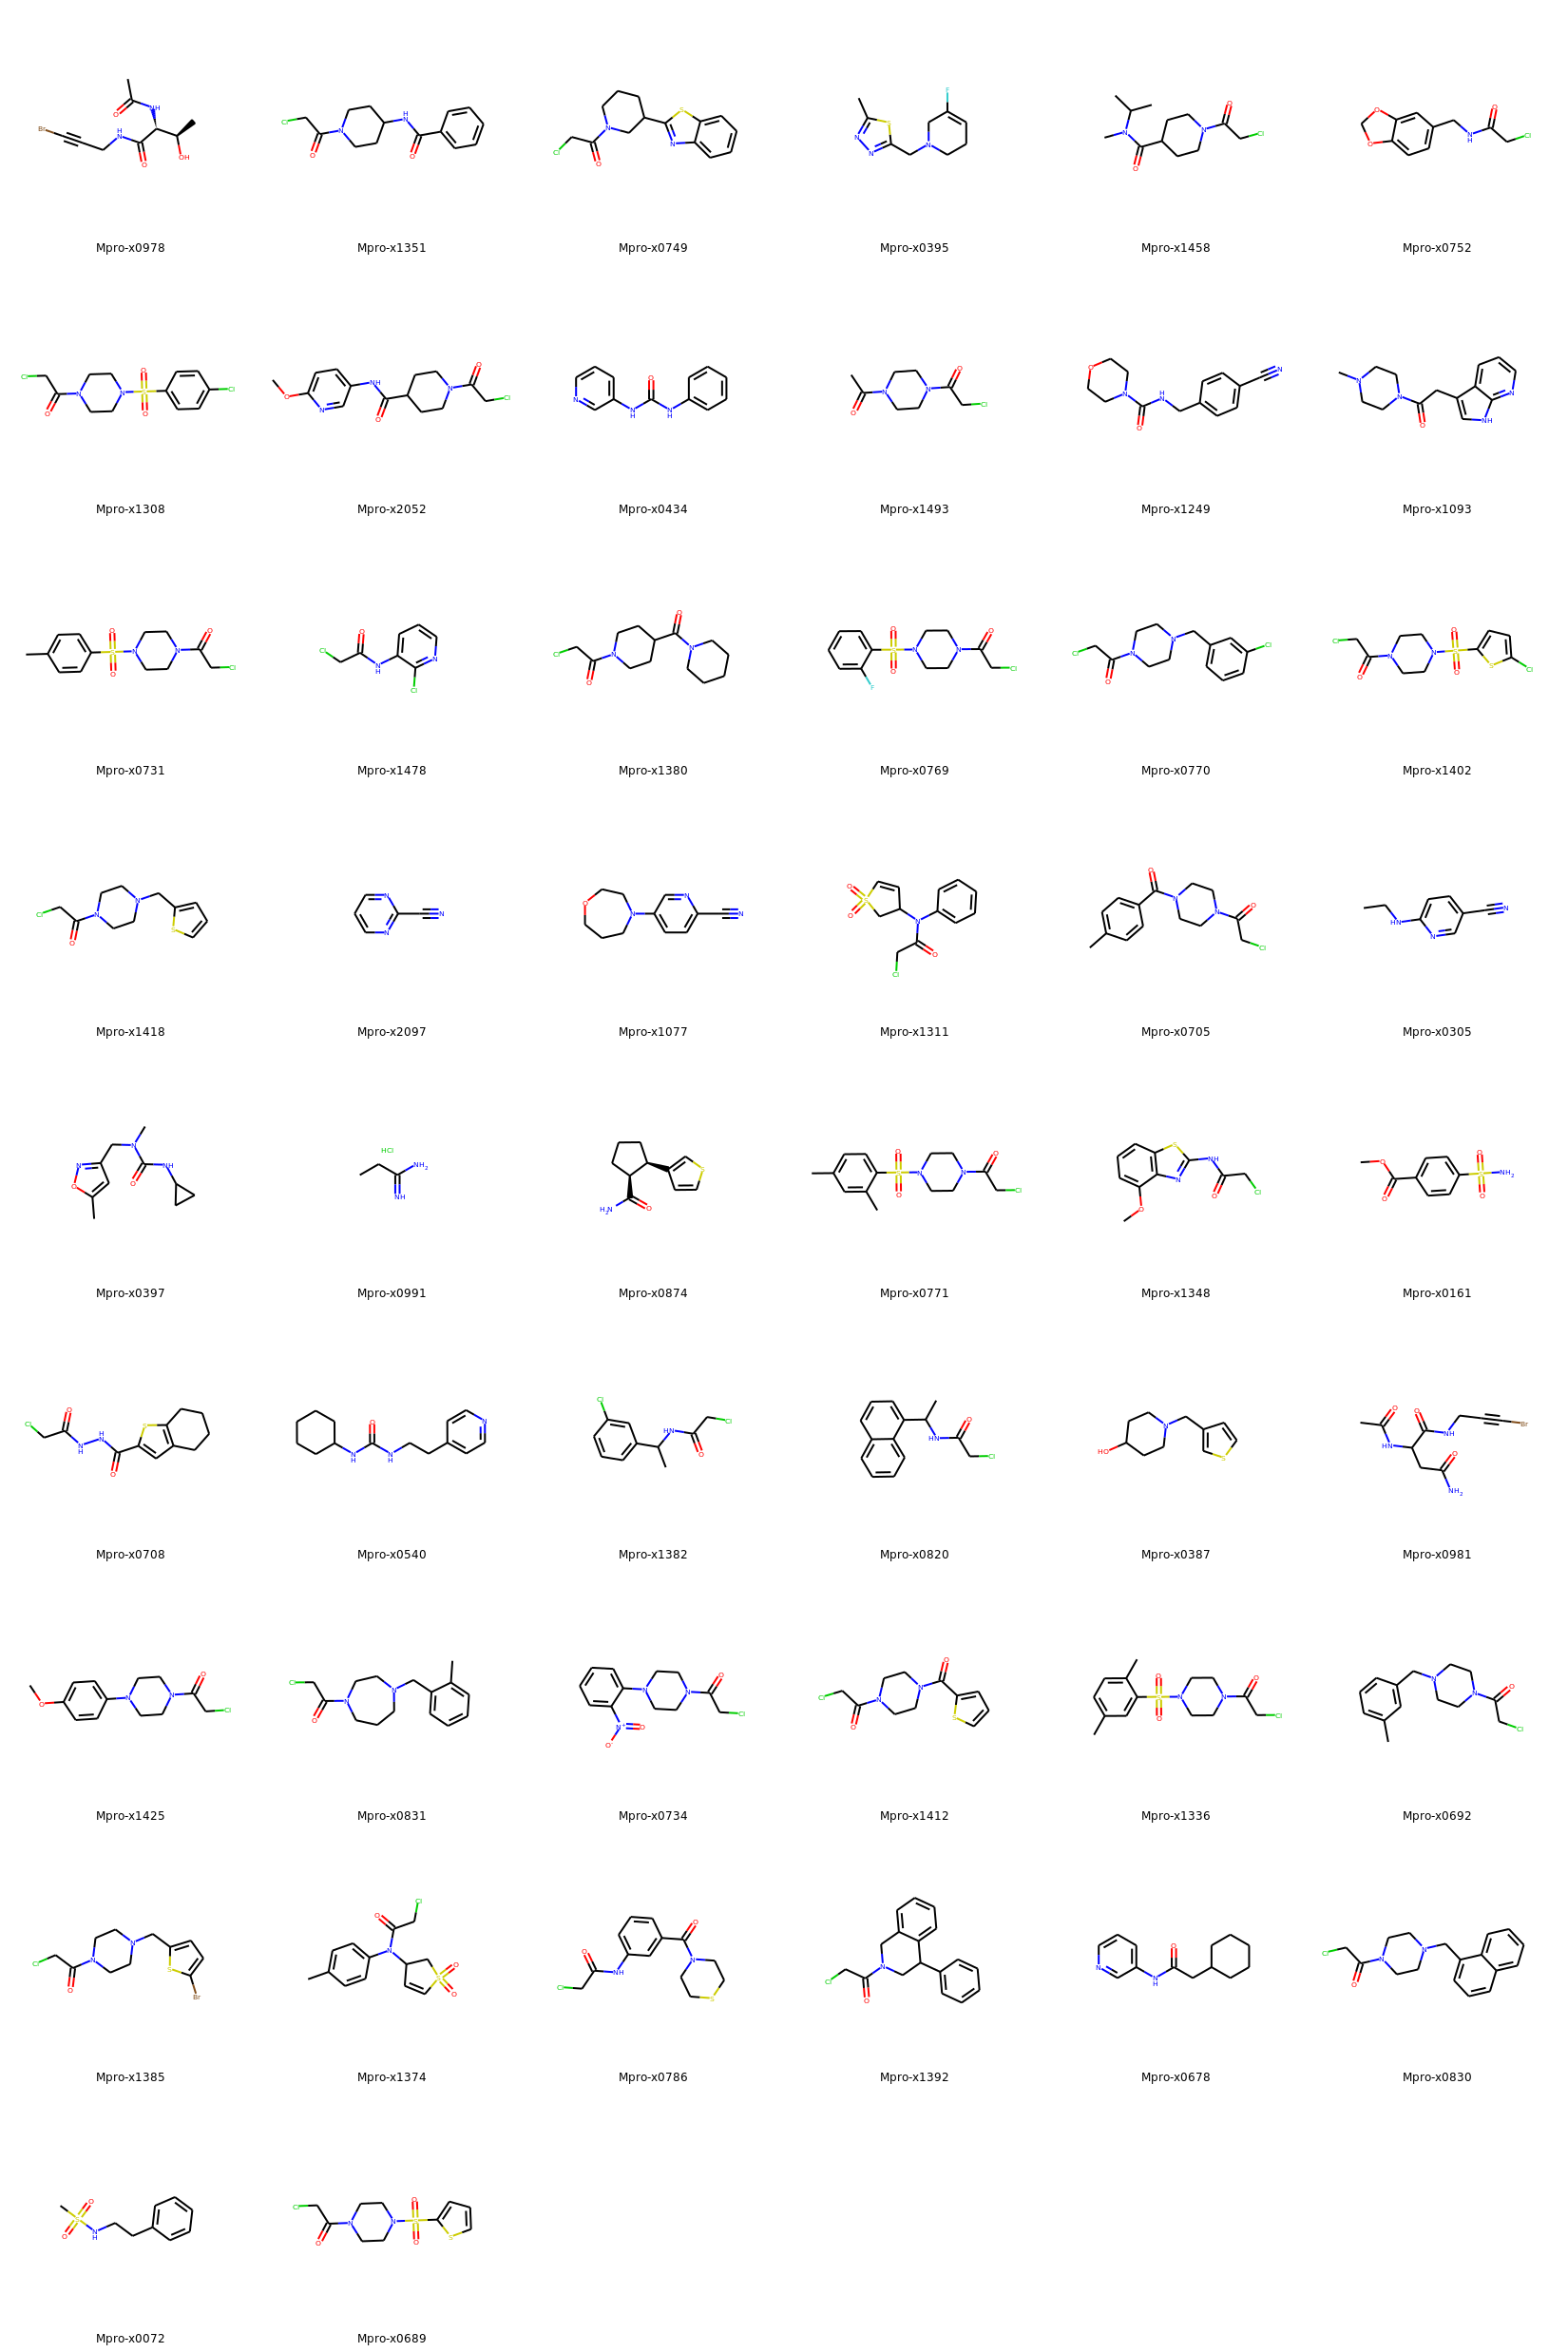

In [6]:
mols = []
hit_mols = []
smiles_list = []
name_list = []

for f in filenames:
    dataname = f[:-6]

    smiles = df.loc[dataname]['Compound SMILES']
    mol = AllChem.MolFromSmiles(smiles)
    mols.append(mol)
    smiles_list.append(MolToSmiles(mol))
    name_list.append(dataname)

from rdkit.Chem import ChemicalFeatures
from rdkit import Geometry
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)
print('Number of noncovalent binding frags: {}'.format(len(mols)))
Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(275,275), legends=name_list)

In [14]:
import mols2grid

mol_df = pd.DataFrame({"mol": mols,
                   "name": name_list})
mols2grid.display(mol_df, mol_col='mol', subset=['img', 'name'], selection=True, n_cols =4)

Number of hits: 213


/rds-d2/user/wjm41/hpc-work/conda/envs/felix_md/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


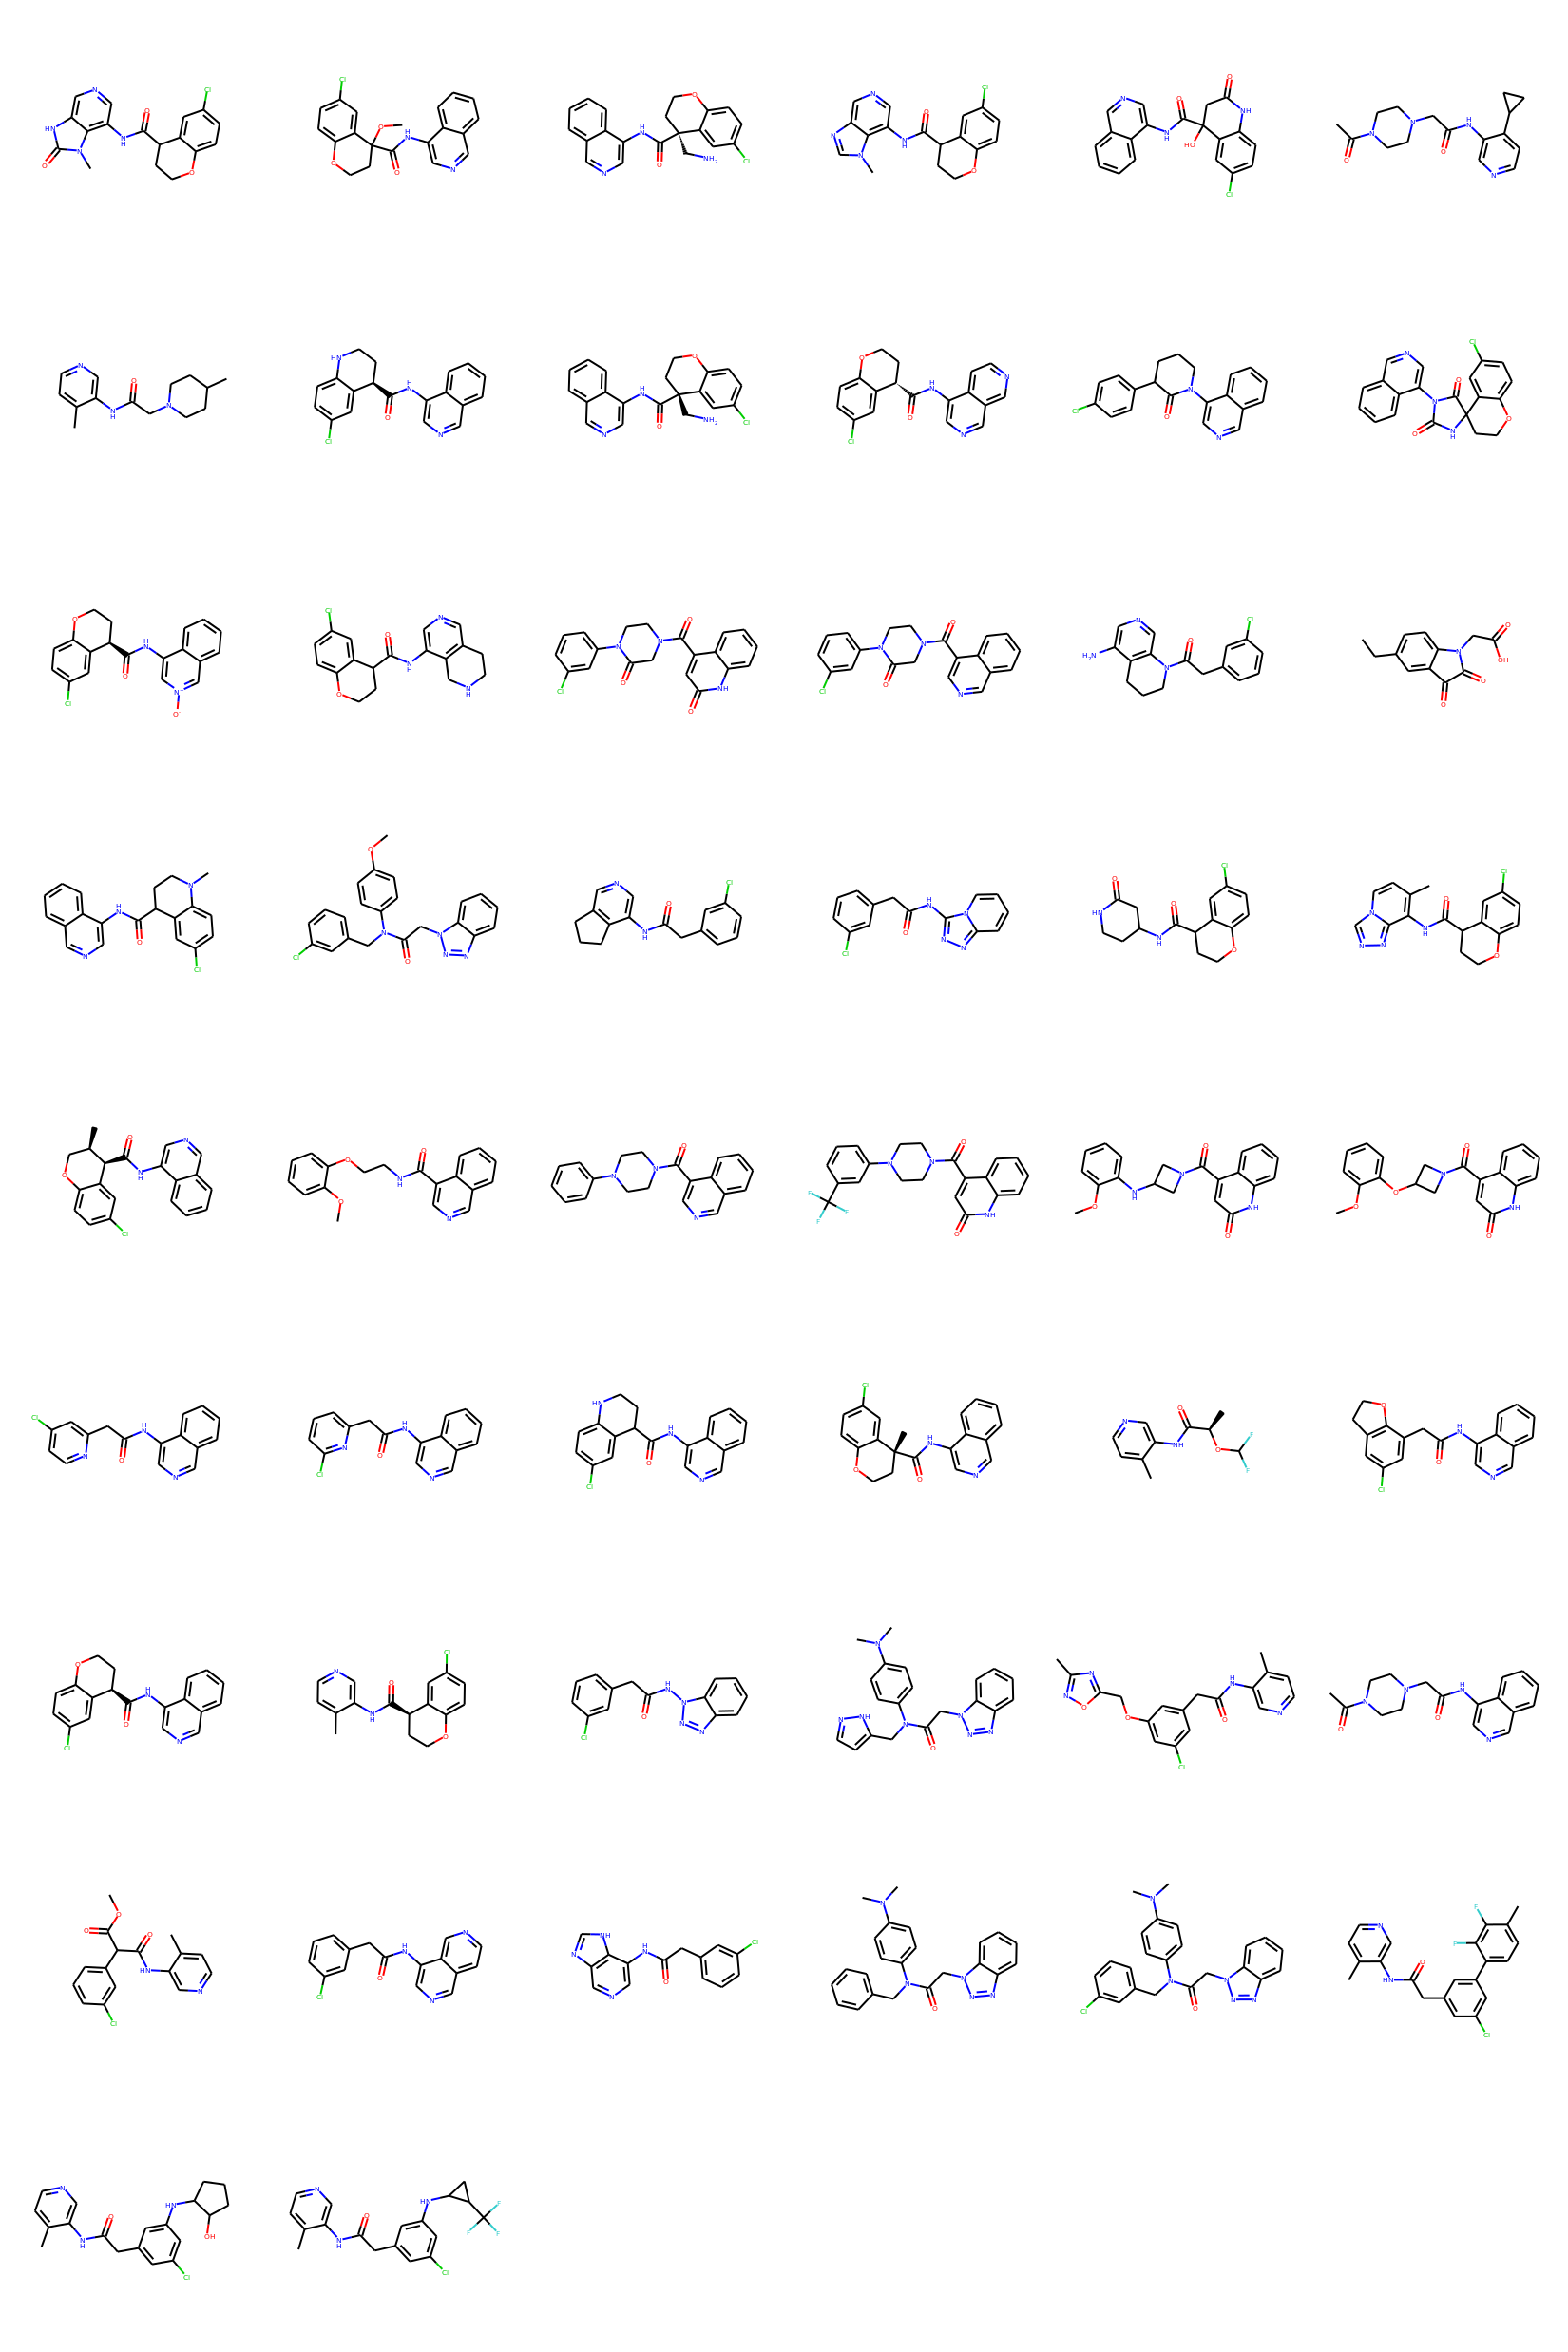

In [24]:
for hit in hits:
    tmp = hit[0]
    tmp = Chem.RemoveHs(tmp)
    AllChem.Compute2DCoords(tmp)
    hit_mols.append(tmp)
print('Number of hits: {}'.format(len(hits)))
# Draw.MolsToGridImage(hit_mols, molsPerRow=6, subImgSize=(275,275), legends=ids)
Draw.MolsToGridImage(hit_mols, molsPerRow=6, subImgSize=(275,275))

In [4]:
from rdkit.Chem import ChemicalFeatures
from rdkit import Geometry
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

SingleAtomDonor
(0,)
SingleAtomDonor
(7,)
SingleAtomDonor
(14,)
SingleAtomAcceptor
(2,)
SingleAtomAcceptor
(9,)
SingleAtomAcceptor
(17,)


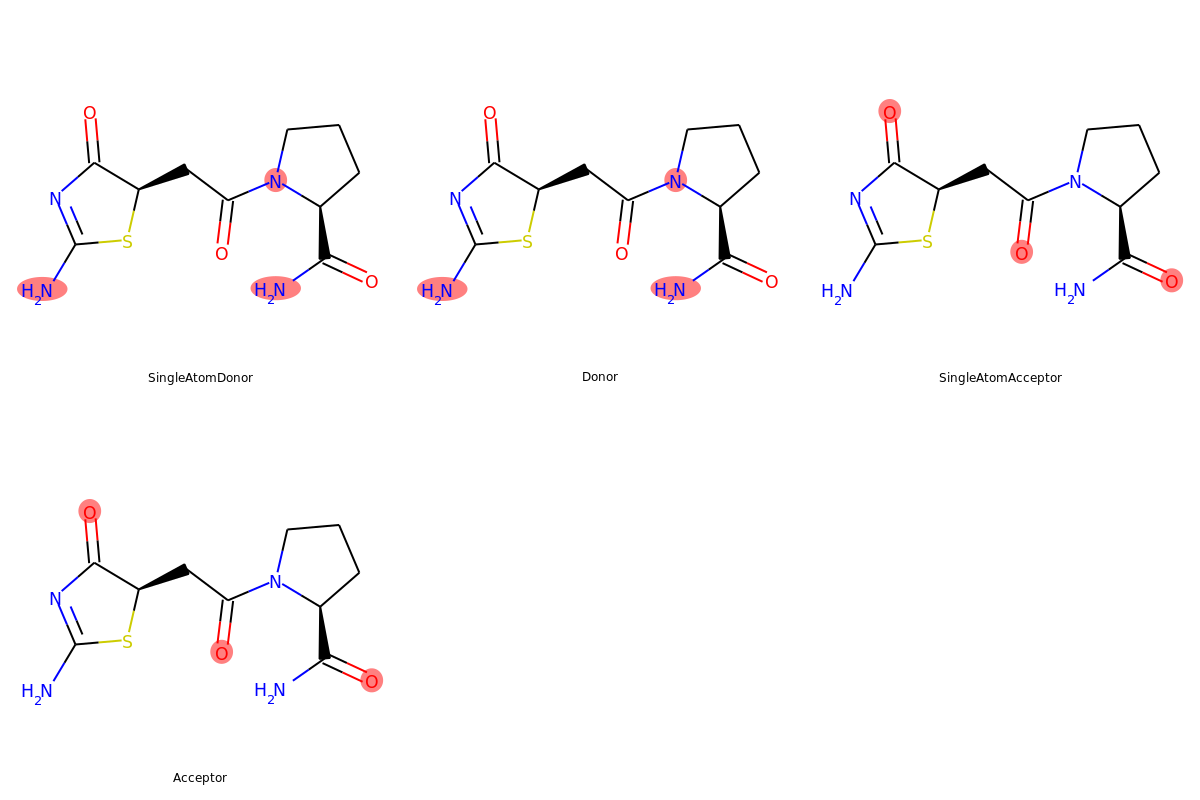

In [5]:
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

def drawp4core(mol, draw=False):
    atoms_list = {}
    feats = featFactory.GetFeaturesForMol(mol)
    for feat in feats:
        feat_type = feat.GetType()
        feat_fam = feat.GetFamily()
        if feat_fam in interesting_pcores:
            atom_ids = feat.GetAtomIds()

            print(feat_type)
            print(atom_ids)
            if feat_type in atoms_list:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] += atom_ids
    #             else:
                    atoms_list[feat_type] += atom_ids
            else:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] = atom_ids
    #             else:
                    atoms_list[feat_type] = atom_ids
            if feat_fam in atoms_list:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] += atom_ids
    #             else:
                    atoms_list[feat_fam] += atom_ids
            else:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] = atom_ids
    #             else:
                    atoms_list[feat_fam] = atom_ids

    if draw:
        AllChem.Compute2DCoords(mol)
        return Draw.MolsToGridImage([mol]*len(atoms_list), subImgSize=(400,400),legends=list(atoms_list.keys()), highlightAtomLists=list(atoms_list.values()))
    else:
        return atoms_list
test = Chem.MolFromSmiles('[H]N([H])C(=O)[C@@H]1CCCN1C(=O)C[C@H]1SC(N([H])[H])=NC1=O')
    
i=1
# im = drawp4core(hits[15][0], draw=True)
im = drawp4core(test, draw=True)
im

In [ ]:
p4core_list = drawp4core(hits[0][0])
print(p4core_list)
frag_p4core_ids = []
hit_p4core_ids = []
for frag in frags:
    frag_p4core_ids.append(drawp4core(frag[0]))
for hit in hits:
    hit_p4core_ids.append(drawp4core(hit[0]))

# Sanity check plotting

In [ ]:
view = py3Dmol.view()

for mol in frags:
    mb = Chem.MolToMolBlock(Chem.RemoveHs(mol[0]), confId=-1)
    view.addModel(mb, 'sdf')
view.setStyle({'stick': {}})
view.setBackgroundColor('0xeeeeee')
view.zoomTo()
view

In [13]:
frag_p4cores = []
for a in frag_p4core_ids:
    for p4core_i in a:
        if p4core_i not in frag_p4cores:
            frag_p4cores.append(p4core_i)
        
possible_pairs = []
for i, p4core_i in enumerate(frag_p4cores):
    for p4core_j in frag_p4cores[i:]:
        possible_pairs.append([p4core_i, p4core_j])
        
possible_trips = []
for i, p4core_i in enumerate(frag_p4cores):
    for j, p4core_j in enumerate(frag_p4cores[i:]):
        for k, p4core_k in enumerate(frag_p4cores[i+j:]):
            possible_trips.append([p4core_i, p4core_j, p4core_k])

# Get intra-pharmacophore distances

In [ ]:
# def get_pair_distances(mol, p4core_list, p4core_i, p4core_j):
#     distances = {}
        
#     ids_i = p4core_list[p4core_i]
#     xyz_i = np.empty((len(ids_i),3))

#     for i,id in enumerate(ids_i):
#         atom = (mol[1:][id])
#         xyz_i[i] = np.array(atom[1])

#     ids_j = p4core_list[p4core_j]
#     xyz_j = np.empty((len(ids_j),3))

#     for i,id in enumerate(ids_j):
#         atom = (mol[1:][id])
#         xyz_j[i] = np.array(atom[1])

#     distance = np.empty((len(ids_i),len(ids_j)))
#     for i in range(len(ids_i)):
#         for j in range(len(ids_j)):
#             distance[i,j] = np.linalg.norm(xyz_i[i] - xyz_j[j])
#     return distance

# frag_pair_distance_dict = {}   
# hit_pair_distance_dict = {}

# for frag_pair in tqdm(possible_pairs):
#     core_a,core_b = frag_pair
#     combo = core_a+'-'+core_b
    
#     for i, frag in enumerate(frags):
#         try:
#             frag_dist = get_pair_distances(frag, frag_p4core_ids[i], core_a, core_b)

#             if combo in frag_pair_distance_dict:
#                 frag_pair_distance_dict[combo] = np.hstack([frag_pair_distance_dict[combo], frag_dist.flatten()])
#             else:
#                 frag_pair_distance_dict[combo] = frag_dist.flatten()    
#         except:
#             pass

#     for i, hit in enumerate(hits):
#         try:
#             hit_dist = get_pair_distances(hit, hit_p4core_ids[i], core_a, core_b)

#             if combo in hit_pair_distance_dict:
#                 hit_pair_distance_dict[combo] = np.hstack([hit_pair_distance_dict[combo], hit_dist.flatten()])
#             else:
#                 hit_pair_distance_dict[combo] = hit_dist.flatten()
#         except:
#             pass

In [ ]:
def get_trip_distances(mol, p4core_list, p4core_i, p4core_j, p4core_k):
    # returns dictionary of three numpy arrays
    distances = {}
                
    ids_i = p4core_list[p4core_i]
    xyz_i = np.empty((len(ids_i),3))

    for i,id in enumerate(ids_i):
        atom = (mol[1:][id])
        xyz_i[i] = np.array(atom[1])

    ids_j = p4core_list[p4core_j]
    xyz_j = np.empty((len(ids_j),3))

    for i,id in enumerate(ids_j):
        atom = (mol[1:][id])
        xyz_j[i] = np.array(atom[1])

    ids_k = p4core_list[p4core_k]
    xyz_k = np.empty((len(ids_k),3))

    for i,id in enumerate(ids_k):
        atom = (mol[1:][id])
        xyz_k[i] = np.array(atom[1])
        
        
    distance = np.empty((len(ids_i)*len(ids_j)*len(ids_k),3))
    l=0
    for i in range(len(ids_i)):
        for j in range(len(ids_j)):
            r12 = np.linalg.norm(xyz_i[i] - xyz_j[j])
            for k in range(len(ids_k)):
                r23 = np.linalg.norm(xyz_j[j] - xyz_k[k])
                r31 = np.linalg.norm(xyz_k[k] - xyz_i[i])
                distance[l] = np.array([r12, r23, r31])
                l+=1
                
    return distance

frag_trip_dist_dict = {}   
hit_trip_dist_dict = {}

for frag_trip in tqdm(possible_trips):
    core_a, core_b, core_c = frag_trip
    combo = core_a+'-'+core_b+'-'+core_c
    
    for i, frag in enumerate(frags):
        try:
            trip_dist = get_trip_distances(frag, frag_p4core_ids[i], core_a, core_b, core_c)

            if combo in frag_trip_dist_dict:
                frag_trip_dist_dict[combo] = np.vstack([frag_trip_dist_dict[combo], trip_dist])
                    
            else:
                frag_trip_dist_dict[combo] = trip_dist  
        except Exception as ex:
#             print(ex)
            pass
#             print(ex)
#             raise Exception

#     for i, hit in enumerate(hits):
#         try:
#             hit_dist = get_trip_distances(hit, hit_p4core_ids[i], core_a, core_b, core_c)

#             if combo in hit_trip_distance_dict:
#                 hit_trip_distance_dict[combo] = np.hstack([hit_trip_distance_dict[combo], hit_dist.flatten()])
#             else:
#                 hit_trip_distance_dict[combo] = hit_dist.flatten()
#         except:
#             pass
# print(frag_trip_dist_dict)

# Get inter-molecular pharmacophore positions

In [25]:
def return_pcore_dataframe(mols, interesting_pcores, hit=False):
    """ 
    retun dictionary of numpy arrays containing (x,y,z) of pharmacophore coordinates (averaged over atoms)
    """
    columns = ['mol_id', 'pcore', 'coord_x', 'coord_y', 'coord_z', 'frag', 'active']
        
    pcore_df = pd.DataFrame(columns=columns)
    
    for i, mol in enumerate(mols):
        frag = True
        activity = False
        if hit:
            frag = False
            IC50 = mol[-1]

            if not math.isnan(IC50) and IC50<10:
#             if not math.isnan(IC50): 
                activity = True
            
        mol_df = pd.DataFrame(columns=columns)
        feats = featFactory.GetFeaturesForMol(mol[0])
        counter = 0
        for feat in feats:
            feat_fam = feat.GetFamily()

            if feat_fam in interesting_pcores:
                atom_ids = feat.GetAtomIds()
                xyz = np.empty((len(atom_ids),3))

                for j,id in enumerate(atom_ids):
                    atom = (mol[1:][id])
                    xyz[j] = np.array(atom[1])
                xyz = np.mean(xyz, axis=0) # mean all aromatic rings!
                
                feat_df = pd.DataFrame(
                            {
                                'pcore': feat_fam,
                                'mol_id': [i],
                                'coord_x': [xyz[0]],
                                'coord_y': [xyz[1]],
                                'coord_z': [xyz[2]],
                                'frag': frag,
                                'active': activity
                            }) 
                mol_df = pd.concat([mol_df, feat_df]) # loop over features and append to mol_df
                
        pcore_df = pd.concat([pcore_df, mol_df]) # loop over molecules and append to pcore_df

    pcore_df['frag'] = pcore_df['frag'].astype(bool)
    pcore_df['active'] = pcore_df['active'].astype(bool)
    pcore_df.reset_index(inplace=True, drop=True)
    return pcore_df

def get_pair_distances(pcore_df, pcore_a, pcore_b, frag=False, active=False):
    '''
    calculates the distribution of pair distances between pcore_a in either hits or frags with pcore_b 
    
    frag argument is to specify calculation of inter-frag distributions which require avoidance of intra-frag counting
    '''
    
    df_a = pcore_df[pcore_df['pcore']==pcore_a]
    df_b = pcore_df[pcore_df['pcore']==pcore_b]

    if frag:
        df_a = df_a[df_a['frag']]
        df_b = df_b[df_b['frag']]
        
    else:
        df_a = df_a[~df_a['frag']]
        df_b = df_b[~df_b['frag']]
        
        if active:
            df_a = df_a[df_a['active']]
            df_b = df_b[df_b['active']]
            
        else:
            df_a = df_a[~df_a['active']]
            df_b = df_b[~df_b['active']]
    
    all_distances = []
    for i in set(df_a['mol_id']):
        try:
            xyz_i = df_a[df_a['mol_id']==i][['coord_x','coord_y','coord_z']].to_numpy() # DOUBLE COUNTING

            if frag:
                xyz_j = df_b[df_b['mol_id']!=i][['coord_x','coord_y','coord_z']].to_numpy() # INTER-FRAG COUNTING
            else:
                xyz_j = df_b[df_b['mol_id']==i][['coord_x','coord_y','coord_z']].to_numpy() # INTRA-MOLECULE COUNTING
    #         print(xyz_i)
    #         print(xyz_i.shape)
    #         print(xyz_j.shape)
            distance = xyz_i[:, np.newaxis] - xyz_j
    #         print(distance.shape)

            distance = np.linalg.norm(distance, axis=2)
    #         print(distance.shape)

            distance = distance.flatten()
    #         print(distance.shape)
#             if all_distances is None:
#                 all_distances = distance
#             else:
#                 all_distances = np.hstack([all_distances, distance])
            all_distances.append(distance)
        except Exception as ex:
            print(ex)
            pass
    if all_distances==[]:
        all_distances = [np.array([])]
    return all_distances

frag_pair_distance_dict = {}   
active_pair_distance_dict = {}
inactive_pair_distance_dict = {}

interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

fragpcore_df = return_pcore_dataframe(frags, interesting_pcores)
hitpcore_df = return_pcore_dataframe(hits, interesting_pcores, hit=True)

active_df = hitpcore_df[hitpcore_df['active']]
inactive_df = hitpcore_df[~hitpcore_df['active']]

all_pcore_df = pd.concat([fragpcore_df, hitpcore_df])

for pcore_pair in tqdm(product(interesting_pcores,repeat=2)):
    core_a,core_b = pcore_pair
    combo = core_a+'-'+core_b
    
    frag_pair_distance_dict[combo] = np.hstack(get_pair_distances(all_pcore_df, core_a, core_b, frag=True))
#     active_pair_distance_dict[combo] = get_pair_distances(hitpcore_df[hitpcore_df['active']], core_a, core_b)
#     inactive_pair_distance_dict[combo] = get_pair_distances(hitpcore_df[~hitpcore_df['active']], core_a, core_b)

#     active_pair_individual[combo] = 
    active_pair_distance_dict[combo] = np.hstack(get_pair_distances(all_pcore_df, core_a, core_b, frag=False, active=True))
    
#     inactive_pair_individual[combo] = 
    inactive_pair_distance_dict[combo] = np.hstack(get_pair_distances(all_pcore_df, core_a, core_b, frag=False, active=False))    
    
active_ind = []
for i in set(active_df['mol_id']):
    active_pair_individual = {}
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        active_pair_individual[combo]= get_pair_distances(active_df[active_df['mol_id']==i], core_a, core_b, frag=False, active=True)
    active_ind.append(active_pair_individual)
    
inactive_ind = []
for i in set(inactive_df['mol_id']):
    inactive_pair_individual = {}
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        inactive_pair_individual[combo]= get_pair_distances(inactive_df[inactive_df['mol_id']==i], core_a, core_b, frag=False, active=False)
    inactive_ind.append(inactive_pair_individual)

9it [00:04,  2.04it/s]


In [26]:
def get_trip_distances(pcore_df, pcore_a, pcore_b, pcore_c, frag=False, active=False):
    num_mols = pcore_df.iloc[-1]['mol_id'] + 1
    
    df_a = pcore_df[pcore_df['pcore']==pcore_a]
    df_b = pcore_df[pcore_df['pcore']==pcore_b]
    df_c = pcore_df[pcore_df['pcore']==pcore_c]
    
    all_distances = []
    
#     all_r12 = 0
#     all_r23 = 0
#     all_r31 = 0
    
    if frag:
        df_a = df_a[df_a['frag']]
        df_b = df_b[df_b['frag']]
        df_c = df_c[df_c['frag']]
        
    else:
        df_a = df_a[~df_a['frag']]
        df_b = df_b[~df_b['frag']]
        df_c = df_c[~df_c['frag']]
        
        if active:
            df_a = df_a[df_a['active']]
            df_b = df_b[df_b['active']]
            df_c = df_c[df_c['active']]
            
        else:
            df_a = df_a[~df_a['active']]
            df_b = df_b[~df_b['active']]
            df_c = df_c[~df_c['active']]
            
    counter=-1
    for i in set(df_a['mol_id']):
        xyz_i = df_a[df_a['mol_id']==i][['coord_x','coord_y','coord_z']].to_numpy() # DOUBLE COUNTING
        nx = xyz_i.shape[0]
        
#         print(xyz_i.shape)
        if frag:
            xyz_j = df_b[df_b['mol_id']!=i][['coord_x','coord_y','coord_z']].to_numpy() # INTER-FRAG COUNTING
            
            ny = xyz_j.shape[0]
            
            r12 = np.linalg.norm(xyz_i[:, np.newaxis] - xyz_j, axis=2).flatten()
#             print(r12.shape)
            for j in set(df_b['mol_id']):
                xyz_k = df_c[(df_c['mol_id']!=i) & (df_c['mol_id']!=j)][['coord_x','coord_y','coord_z']].to_numpy()
                nz = xyz_k.shape[0]
                
                r23 = np.linalg.norm(xyz_j[:, np.newaxis] - xyz_k, axis=2).flatten()
                r31 = np.linalg.norm(xyz_k[:, np.newaxis] - xyz_i, axis=2).T#.flatten()
#                 print(r23.shape)
#                 print(r31.shape)
                
                
                distance_matrix = np.empty((3, nx*ny*nz))
                distance_matrix[0] = np.repeat(r12, repeats=nz)
                distance_matrix[1] = np.tile(r23, reps=nx)
                
                z_axis = 0
                for x in range(r31.shape[0]):
                    if x==0:
                        z_axis = np.tile(r31[x], reps=ny)
                    else:
                        z_axis = np.hstack([z_axis, np.tile(r31[x], reps=ny)])
                
                distance_matrix[2] = z_axis
                
                all_distances.append(distance_matrix)
#                 counter+=1
                
#                 if counter==0:
# #                     all_r12 = r12
# #                     all_r23 = r23
# #                     all_r31 = r31
#                     all_distances = distance_matrix

#                 else:
# #                     all_r12 = np.hstack([all_r12, r12])
# #                     all_r23 = np.hstack([all_r23, r23])
# #                     all_r31 = np.hstack([all_r31, r31])     
#                     all_distances = np.hstack([all_distances, distance_matrix])

        else:
            xyz_j = df_b[df_b['mol_id']==i][['coord_x','coord_y','coord_z']].to_numpy() # INTRA-MOLECULE COUNTING        
            xyz_k = df_c[df_c['mol_id']==i][['coord_x','coord_y','coord_z']].to_numpy() # INTRA-MOLECULE COUNTING
            
            ny = xyz_j.shape[0]
            nz = xyz_k.shape[0]
            
            r12 = np.linalg.norm(xyz_i[:, np.newaxis] - xyz_j, axis=2).flatten()
            r23 = np.linalg.norm(xyz_j[:, np.newaxis] - xyz_k, axis=2).flatten()
            r31 = np.linalg.norm(xyz_k[:, np.newaxis] - xyz_i, axis=2).T#.flatten()
            
            distance_matrix = np.empty((3, nx*ny*nz))
            distance_matrix[0] = np.repeat(r12, repeats=nz)
            distance_matrix[1] = np.tile(r23, reps=nx)
            
            z_axis = 0
            for x in range(r31.shape[0]):
                if x==0:
                    z_axis = np.tile(r31[x], reps=ny)
                else:
                    z_axis = np.hstack([z_axis, np.tile(r31[x], reps=ny)])

            distance_matrix[2] = z_axis
            all_distances.append(distance_matrix)
            
#             counter+=1

#             if counter==0:
# #                     all_r12 = r12
# #                     all_r23 = r23
# #                     all_r31 = r31
#                 all_distances = distance_matrix

#             else:
# #                     all_r12 = np.hstack([all_r12, r12])
# #                     all_r23 = np.hstack([all_r23, r23])
# #                     all_r31 = np.hstack([all_r31, r31])     
#                 all_distances = np.hstack([all_distances, distance_matrix])
#     all_distances = np.array([all_r12, all_r23, all_r31])
#     print('\n')
#     print(all_r12.shape)
#     print(all_r23.shape)
#     print(all_r31.shape)

    return all_distances

frag_trip_distance_dict = {}   
active_trip_distance_dict = {}
inactive_trip_distance_dict = {}

active_trip_individual = {}
inactive_trip_individual = {}

for pcore_trip in tqdm(product(interesting_pcores,repeat=3)):
    core_a, core_b, core_c = pcore_trip
    combo = core_a+'-'+core_b+'-'+core_c
    
    frag_trip_distance_dict[combo] = np.hstack(get_trip_distances(all_pcore_df, core_a, core_b, core_c, frag=True, active=False))
    
    active_trip_individual[combo] = get_trip_distances(all_pcore_df, core_a, core_b, core_c, frag=False, active=True)
    active_trip_distance_dict[combo] = np.hstack(active_trip_individual[combo])
    
    inactive_trip_individual[combo] = get_trip_distances(all_pcore_df, core_a, core_b, core_c, frag=False, active=False)
    inactive_trip_distance_dict[combo] = np.hstack(inactive_trip_individual[combo])   
    
active_ind2 = []
for i in set(active_df['mol_id']):
    active_trip_individual = {}
    for pcore_trip in product(interesting_pcores,repeat=3):
        core_a,core_b,core_c = pcore_trip
        combo = core_a+'-'+core_b+'-'+core_c
        active_trip_individual[combo]= get_trip_distances(active_df[active_df['mol_id']==i], core_a, core_b, core_c, frag=False, active=True)
    active_ind2.append(active_trip_individual)
    
inactive_ind2 = []
for i in set(inactive_df['mol_id']):
    inactive_trip_individual = {}
    for pcore_trip in product(interesting_pcores,repeat=3):
        core_a,core_b,core_c = pcore_trip
        combo = core_a+'-'+core_b+'-'+core_c
        inactive_trip_individual[combo]= get_trip_distances(inactive_df[inactive_df['mol_id']==i], core_a, core_b, core_c, frag=False, active=False)
    inactive_ind2.append(inactive_trip_individual)

27it [00:37,  1.38s/it]


### Score hits based on fragment histograms

In [16]:
IC50s_active = []

IC50s_inactive = []

for hit in hits:
    IC50 = hit[-1]
    if not math.isnan(IC50) and IC50<10:
#     if not math.isnan(IC50):     
        IC50s_active.append(IC50)

    else:
        IC50s_inactive.append(IC50)


# fig = plt.figure()
# ax = fig.add_subplot()

# ax.scatter(active_scores, IC50s_active, c='r', label='inactive')
# # ax.scatter(scores_hba_active, scores_hydro_active, c='b', label='active')

# ax.set_xlabel('IC50')
# ax.set_ylabel('histogram score')

# ax.legend()
# plt.show()
IC50s_active = np.array(IC50s_active)
print('number of actives: {}\n'.format(len(IC50s_active)))
# print('PM7 rho: {:.3f}'.format(spear(IC50s_active,scores_pm7_active)[0]))
# print('PM7 R2: {:.3f}'.format(r2_score(IC50s_active,scores_pm7_active)))

# print('pi rho: {:.3f}'.format(spear(IC50s_active,scores_pi_active)[0]))
# print('pi R2: {:.3f}'.format(r2_score(scores_pi_active,IC50s_active)))

number of actives: 39



### Pair Histogram Scoring

In [8]:
def enrichment(df, n=10, index='active', log=False):
    orig_prop = len(df[df[index]])/len(df)
    if log:
        print('orig proportion of '+index+': {:.3f}%'.format(orig_prop*100))
    
    sorted_df = df.sort_values(by='score', ascending=True).iloc[:n]
    new_prop = len(sorted_df[sorted_df[index]])/len(sorted_df)
    if log:
        print('new proportion of '+index+': {:.3f}%'.format(new_prop*100))
    EF = new_prop/orig_prop
    return EF



1it [00:01,  1.59s/it]

best bandwidth: 0.1


2it [00:04,  1.93s/it]

best bandwidth: 0.42813323987193935


3it [00:05,  1.66s/it]

best bandwidth: 0.8858667904100825


4it [00:07,  1.95s/it]

best bandwidth: 0.42813323987193935


5it [00:12,  2.82s/it]

best bandwidth: 0.1


6it [00:14,  2.47s/it]

best bandwidth: 0.42813323987193935


7it [00:15,  2.03s/it]

best bandwidth: 0.42813323987193935


8it [00:17,  1.92s/it]

best bandwidth: 0.6951927961775606


9it [00:17,  1.97s/it]

best bandwidth: 0.12742749857031338
orig proportion of active: 17.500%
new proportion of active: 17.000%
Pair histogram EF: 0.971


<IPython.core.display.Javascript object>


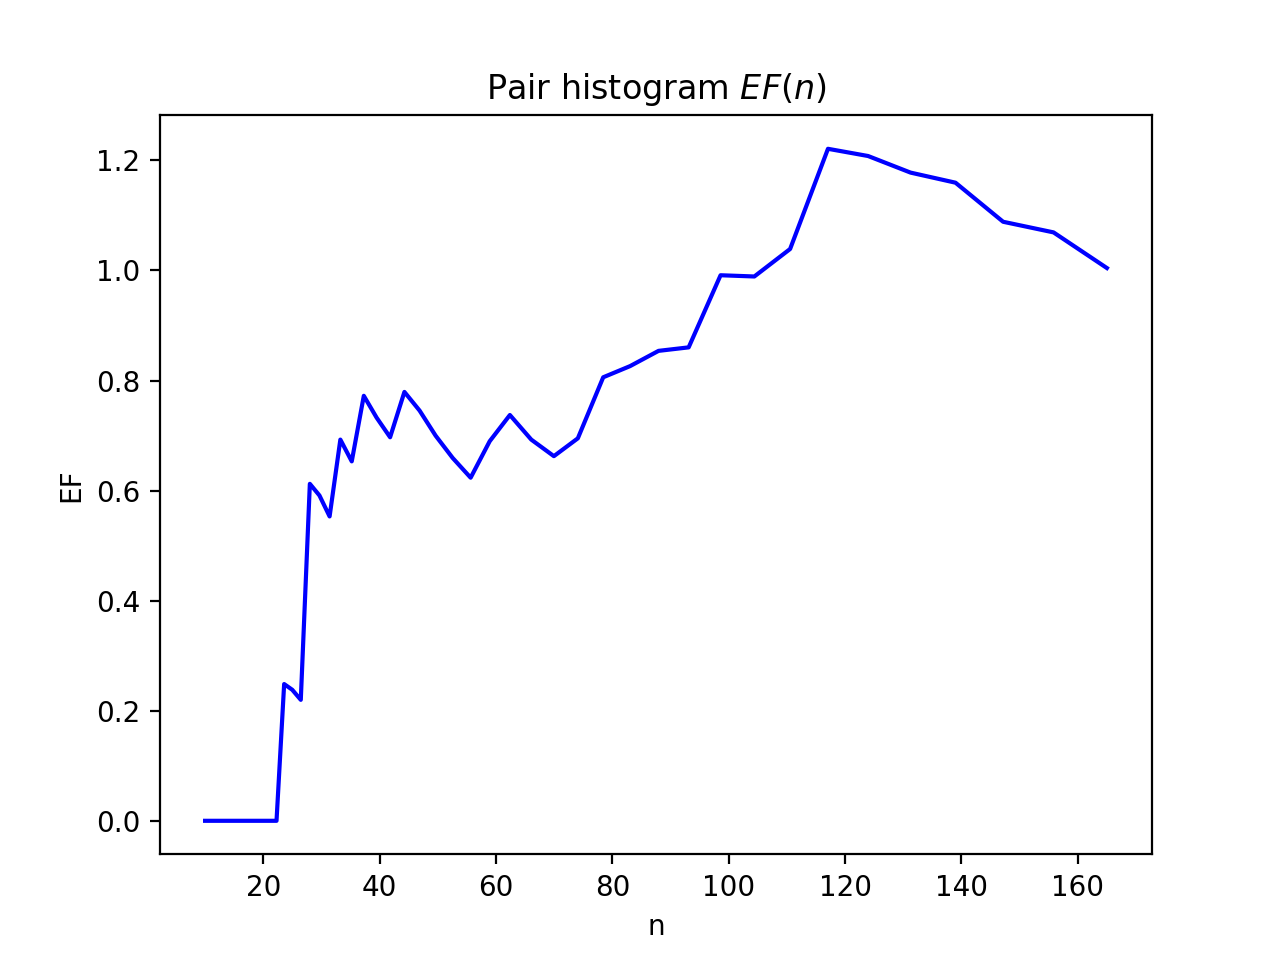

In [10]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

active_scores = np.empty((len(active_ind), 9))
inactive_scores = np.empty((len(inactive_ind), 9))

n = 0
for pcore_pair in tqdm(product(interesting_pcores,repeat=2)):
    core_a,core_b = pcore_pair
    combo = core_a+'-'+core_b
    
    active_tmp = []
    inactive_tmp = []

    num_weight = len(frag_pair_distance_dict[combo])
#     kde = KernelDensity(kernel='tophat', bandwidth=1.0).fit(frag_pair_distance_dict[combo].reshape(-1,1))
    
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
    grid.fit(frag_pair_distance_dict[combo].reshape(-1,1))

    print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
    
    kde = grid.best_estimator_


    for i in range(len(active_ind)):
        try:
            ith_score = kde.score_samples(active_ind[i][combo][0].reshape(-1,1))#*num_weight
            active_scores[i,n] = np.mean(ith_score)
            active_tmp.append(np.mean(ith_score))
        except:
            active_scores[i,n] = np.nan
            active_tmp.append(np.nan)
    
    active_tmp = np.array(active_tmp)
    mask = ~np.isnan(active_tmp)

#     print('\n{} rho: {:.3f}'.format(combo, spear(IC50s_active[mask], active_tmp[mask])[0]))
#     print('{} R2: {:.3f}'.format(combo, r2_score(IC50s_active[mask], active_tmp[mask])))

    for j in range(len(inactive_ind)):
        try:
            jth_score = kde.score_samples(inactive_ind[j][combo][0].reshape(-1,1))#*num_weight
            inactive_scores[j,n] = np.mean(jth_score)
            inactive_tmp.append(jth_score)
        except:
            inactive_scores[j,n] = np.nan
            inactive_tmp.append(np.nan)
    n+=1

final_active_score = np.mean(active_scores, axis=1)
final_inactive_score = np.mean(inactive_scores, axis=1)

active_mask = np.isfinite(final_active_score)
inactive_mask = np.isfinite(final_inactive_score)

# print('\nTotal weighted histograms:')
# print('rho: {:.3f}'.format(spear(IC50s_active[active_mask], final_active_score[active_mask])[0]))
# print('R2: {:.3f}'.format(r2_score(IC50s_active[active_mask], final_active_score[active_mask])))

df1 = pd.DataFrame(list(zip(final_active_score[active_mask], np.ones_like(final_active_score[active_mask]))), columns = ['score','active'])
df2 = pd.DataFrame(list(zip(final_inactive_score[inactive_mask], np.zeros_like(final_inactive_score[inactive_mask]))), columns = ['score','active'])

pair_df = pd.concat([df1, df2])
pair_df['active'] = pair_df['active'].astype('Int64').astype(bool)

print('Pair histogram EF: {:.3f}'.format(enrichment(pair_df, n=100, index='active', log=True)))

n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
EF = [enrichment(pair_df, n=int(n), index='active') for n in n_list]

fig = plt.figure()
plt.plot(n_list, EF, 'b-')
plt.title(r'Pair histogram $EF(n)$')
plt.xlabel('n')
plt.ylabel('EF')
plt.show()

In [28]:
from IPython.display import display
pd.set_option('display.max_rows', 100)
pair_df.sort_values(by='score').head(100)

,score,active
153,-3.609387,False
67,-3.602425,False
71,-3.591882,False
73,-3.590649,False
69,-3.590515,False
74,-3.589331,False
70,-3.589035,False
72,-3.588307,False
68,-3.588016,False
75,-3.586263,False


27it [01:25,  3.18s/it]

orig proportion of active: 15.897%
new proportion of active: 21.000%
Triplet histogram EF: 1.321


<IPython.core.display.Javascript object>


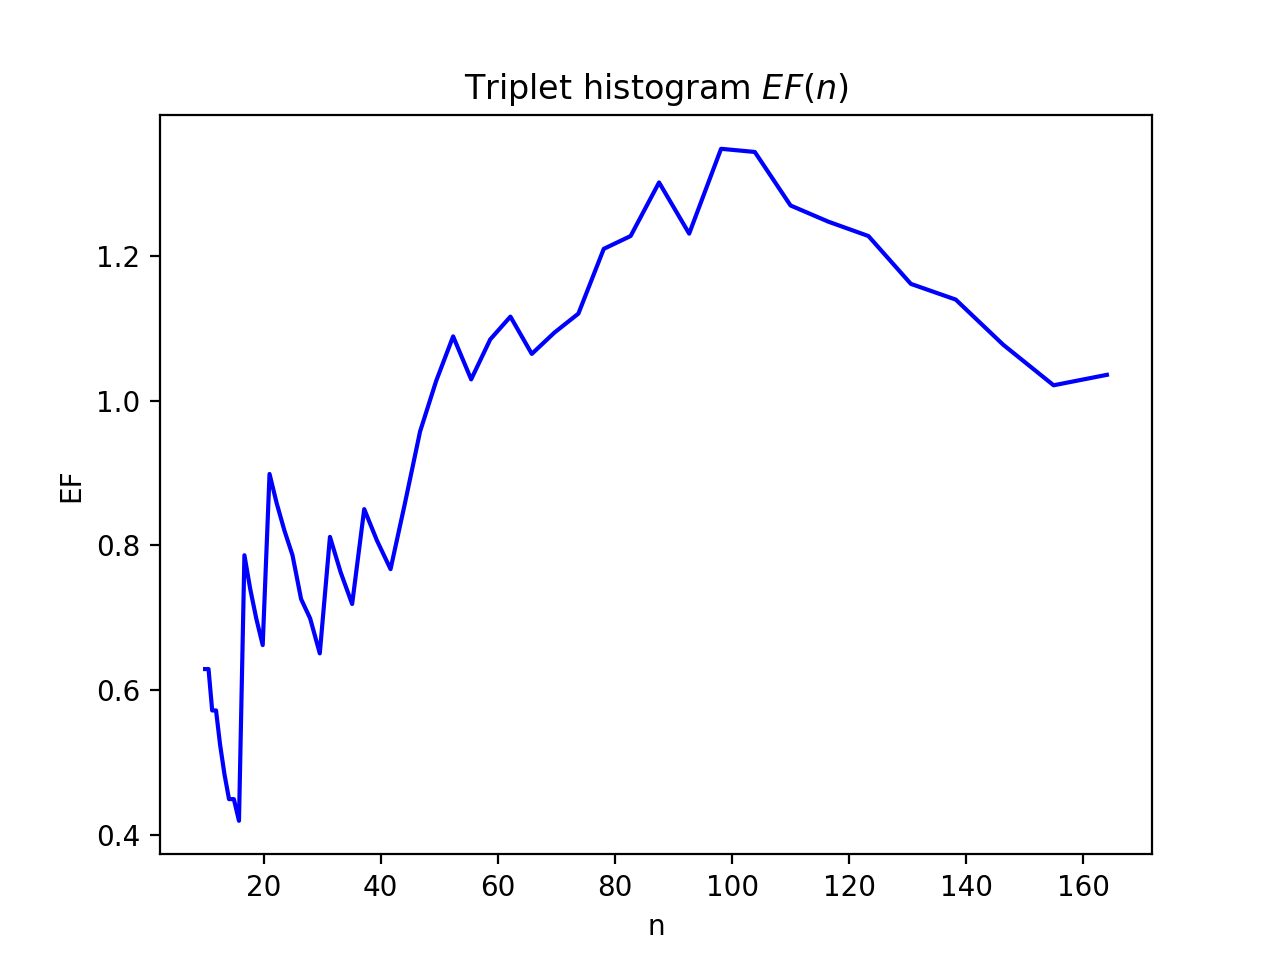

In [11]:
active_scores = np.empty((len(active_ind), 27))
inactive_scores = np.empty((len(inactive_ind), 27))

n=0
for pcore_trip in tqdm(product(interesting_pcores,repeat=3)):
    core_a,core_b,core_c = pcore_trip
    combo = core_a+'-'+core_b+'-'+core_c
    
    active_tmp = []
    inactive_tmp = []
    
    num_weight = frag_trip_distance_dict[combo].shape[1]
#     print(num_weight)
    
    kde = KernelDensity(kernel='tophat').fit(frag_trip_distance_dict[combo].T)
#     kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(frag_trip_distance_dict[combo].T)
    
    for i in range(len(active_ind2)):   
        try:
            ith_score = kde.score_samples(active_ind2[i][combo][0].T)*num_weight
            active_scores[i,n] = np.mean(ith_score)
            active_tmp.append(np.mean(ith_score))
        except:
            active_scores[i,n] = np.nan
            active_tmp.append(np.nan)
    
    active_tmp = np.array(active_tmp)
    mask = np.isfinite(active_tmp)
    
#     print('\n{} rho: {:.3f}'.format(combo, spear(IC50s_active[mask], active_tmp[mask])[0]))
#     print('{} R2: {:.3f}'.format(combo, r2_score(IC50s_active[mask], active_tmp[mask])))

    for j in range(len(inactive_ind)):
        try:
            jth_score = kde.score_samples(inactive_ind2[j][combo][0].T)*num_weight
            inactive_scores[j,n] = np.mean(jth_score)
            inactive_tmp.append(jth_score)
        except:
            inactive_scores[j,n] = np.nan
            inactive_tmp.append(np.nan)
    n+=1
    
final_active_score = np.mean(active_scores, axis=1)
final_inactive_score = np.mean(inactive_scores, axis=1)

active_mask = np.isfinite(final_active_score)
inactive_mask = np.isfinite(final_inactive_score)

# print('\nTotal weighted histograms:')
# print('rho: {:.3f}'.format(spear(IC50s_active[active_mask], final_active_score[active_mask])[0]))
# print('R2: {:.3f}'.format(r2_score(IC50s_active[active_mask], final_active_score[active_mask])))

df1 = pd.DataFrame(list(zip(final_active_score[active_mask], np.ones_like(final_active_score[active_mask]))), columns = ['score','active'])
df2 = pd.DataFrame(list(zip(final_inactive_score[inactive_mask], np.zeros_like(final_inactive_score[inactive_mask]))), columns = ['score','active'])

trip_df = pd.concat([df1, df2])
trip_df['active'] = trip_df['active'].astype('Int64').astype(bool)

print('Triplet histogram EF: {:.3f}'.format(enrichment(trip_df, n=100, index='active', log=True)))

n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
EF = [enrichment(trip_df, n=int(n), index='active') for n in n_list]

fig = plt.figure()
plt.plot(n_list, EF, 'b-')
plt.title(r'Triplet histogram $EF(n)$')
plt.xlabel('n')
plt.ylabel('EF')
plt.show()


# Check 3-body excess

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import entropy

def fit_pair_kde(data):
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
    grid.fit(data.reshape(-1,1))
    
    kde = grid.best_estimator_
    return kde

# pair_kdes = {}
# n = 30

# for pcore_pair in product(interesting_pcores,repeat=2):
#     core_a, core_b = pcore_pair
#     combo = core_a+'-'+core_b
#     pair_data = frag_pair_distance_dict[combo]
#     kde = fit_pair_kde(pair_data)
# #     pair_kdes[combo] = kde
#     x = np.linspace(0, np.amax(pair_data ), n)
    
#     pair_dist = np.ones(n)
#     for i in range(n):
#         ith_score = kde.score_samples(x.reshape(-1,1))
#         pair_dist[i]*= ith_score
    
combo_list = []
entropy_list = []

nx, ny, nz = 80, 80, 80
for pcore_trip in tqdm(product(interesting_pcores,repeat=3), total=27):
    core_a, core_b, core_c = pcore_trip
    combo = core_a+'-'+core_b+'-'+core_c
    combo_list.append(combo)
    
    trip = frag_trip_distance_dict[combo]
    pair1 = frag_pair_distance_dict[core_a+'-'+core_b]
    pair2 = frag_pair_distance_dict[core_b+'-'+core_c]
    pair3 = frag_pair_distance_dict[core_c+'-'+core_a]
    
    x = np.linspace(0, np.amax(pair1), nx)
    y = np.linspace(0, np.amax(pair2), ny)
    z = np.linspace(0, np.amax(pair3), nz)
    
    kde_pair1 = fit_pair_kde(pair1)
    kde_pair2 = fit_pair_kde(pair2)
    kde_pair3 = fit_pair_kde(pair3)

    pair_dist = np.ones((nx, ny, nz))

    for i in range(nx):
        ith_score = kde_pair1.score_samples(x[i].reshape(-1,1))
        pair_dist[i, :, :] *= ith_score

    for i in range(ny):
        jth_score = kde_pair2.score_samples(y[i].reshape(-1,1))
        pair_dist[:, i, :] *= jth_score

    for i in range(nz):
        kth_score = kde_pair3.score_samples(z[i].reshape(-1,1))
        pair_dist[:, :, i] *= kth_score
        
    # triplet 
    kde_trip = KernelDensity(kernel='tophat').fit(trip.T)
    trip_dist = np.ones((nx, ny, nz))
    xv, yv, zv = np.meshgrid(x, y, z)

    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                ith_score = kde_trip.score_samples(np.array([xv[i,j,k], yv[i,j,k], zv[i,j,k]]).reshape(1,3))
                trip_dist[i, j, k] *= ith_score
                
    mask = np.isfinite(trip_dist)
    mask = mask * np.isfinite(pair_dist)

    entropy_list.append(entropy(trip_dist[mask].flatten(), pair_dist[mask].flatten()))

 41%|████      | 11/27 [45:31<1:10:49, 265.59s/it]

In [ ]:
excess_df = pd.DataFrame(list(zip(combo_list, entropy_list)), columns = ['combo','KL Divergence'])
print('nx, ny, nz = {},{},{}'.format(nx, ny, nz))
print(excess_df.round({'KL Divergence': 2}))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve

def fit_forest(X,y, scoring='accuracy'):
    params = {'n_estimators': [100, 1000, 10000], 'max_depth': [1, 2, 3], 'min_samples_split': [2, 4]}
#     params = {'n_estimators': [1000], 'max_depth': [1, 2]}
    search = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, cv=5, verbose=3, scoring=scoring)
    model  = search.fit(X, y).best_estimator_
    return model

scoring = 'neg_log_loss'

model = fit_forest(X_train, y_train, scoring=scoring)

train_preds = model.predict(X_train)

roc = roc_auc_score(y_train,train_preds)
precision, recall, thresholds = precision_recall_curve(y_train, train_preds)
prc = auc(recall, precision)

print('\nTraining Set:')
print("ROC: {:.3f}".format(roc))
print("PRC: {:.3f}".format(prc))

test_preds = model.predict_proba(X_test)[:,1]

roc = roc_auc_score(y_test,test_preds)
precision, recall, thresholds = precision_recall_curve(y_test, test_preds)
prc = auc(recall, precision)

print('\nTest Set:')
print("ROC: {:.3f}".format(roc))
print("PRC: {:.3f}".format(prc))

### Plot Histograms

<IPython.core.display.Javascript object>


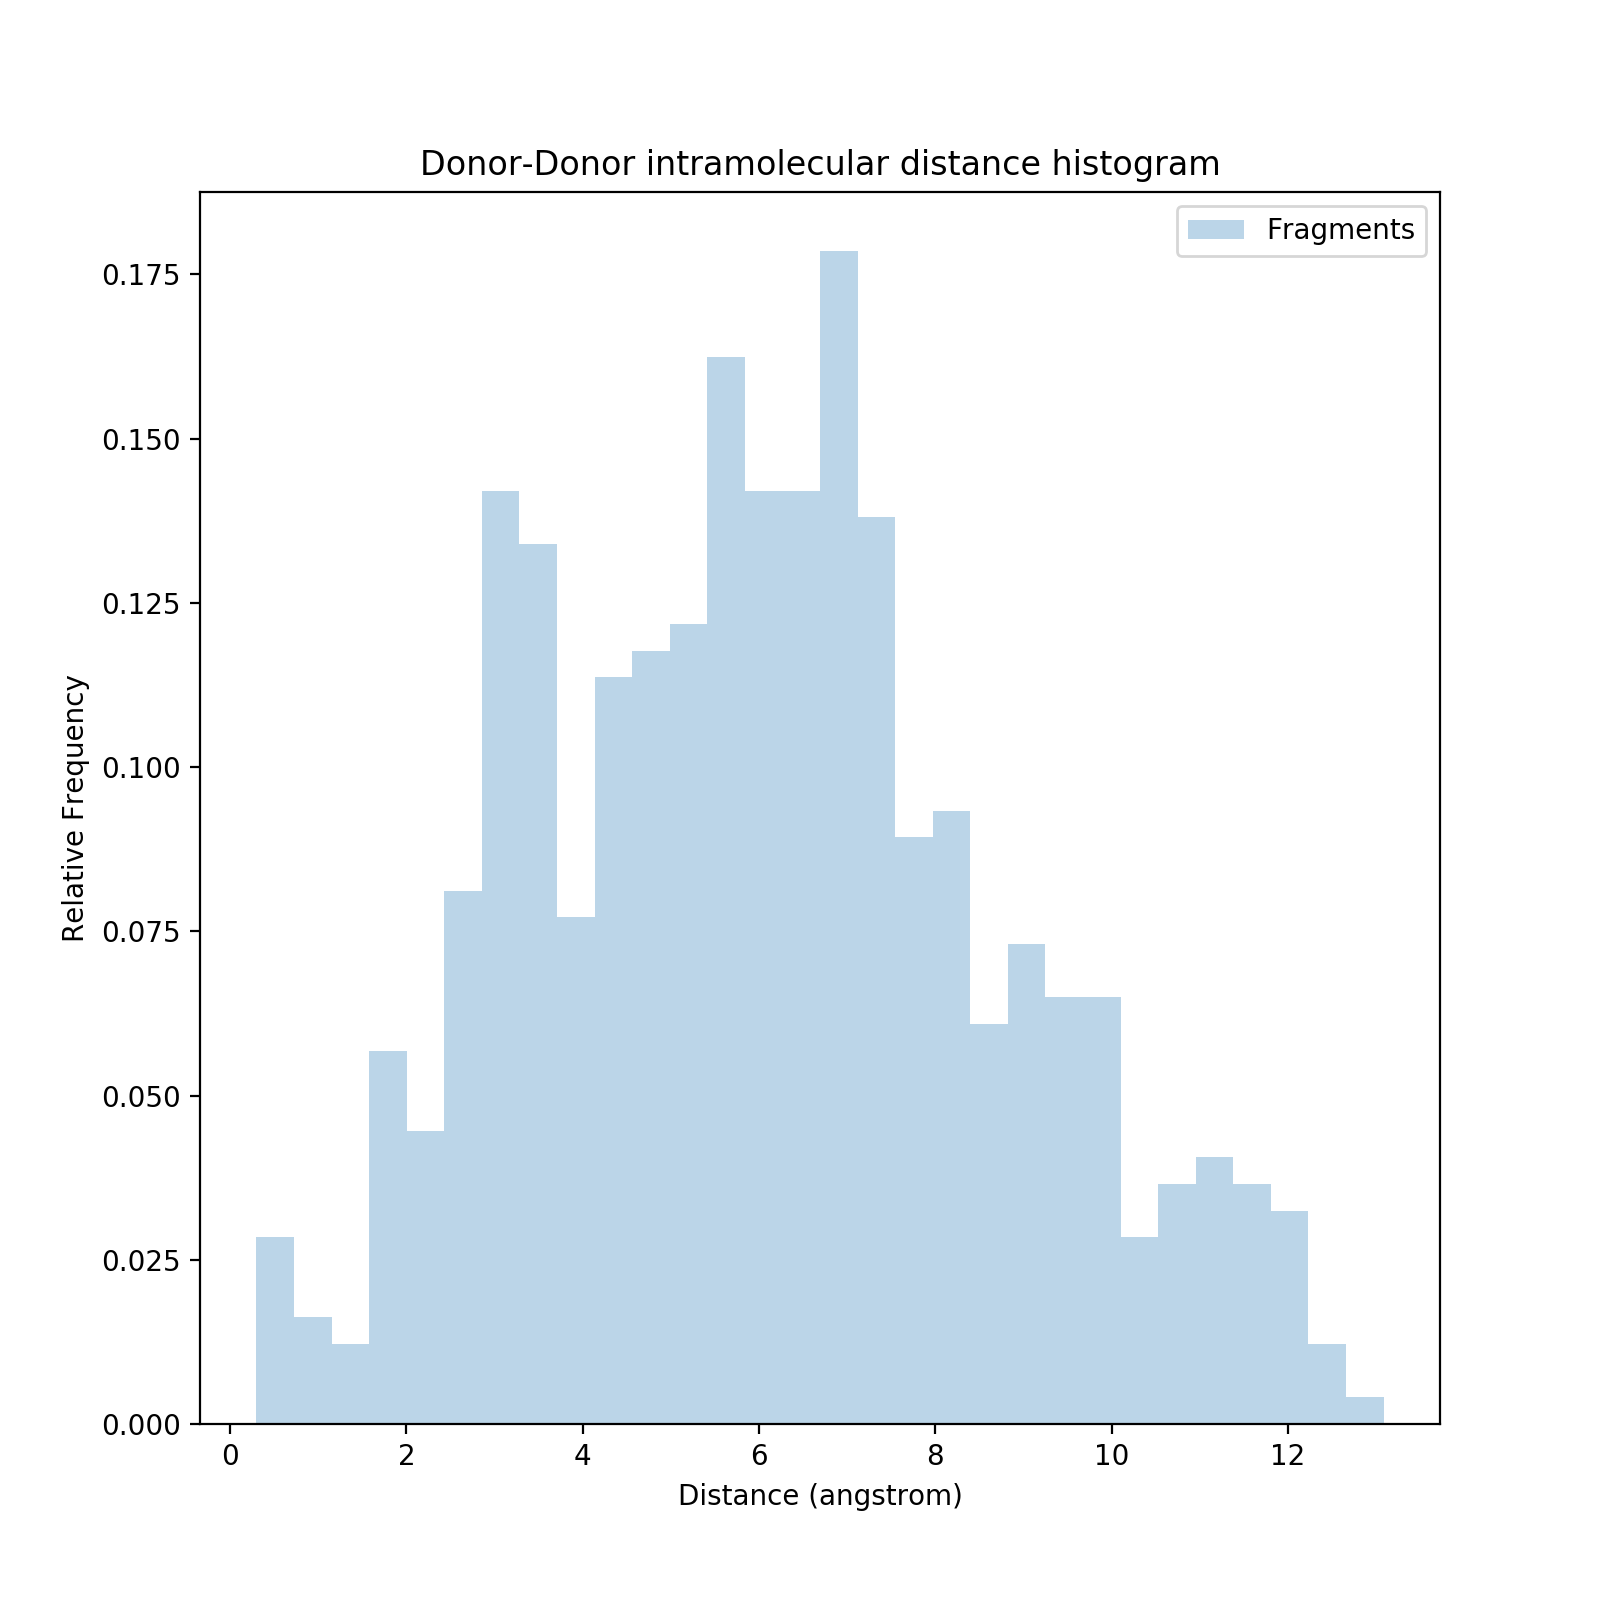

<IPython.core.display.Javascript object>


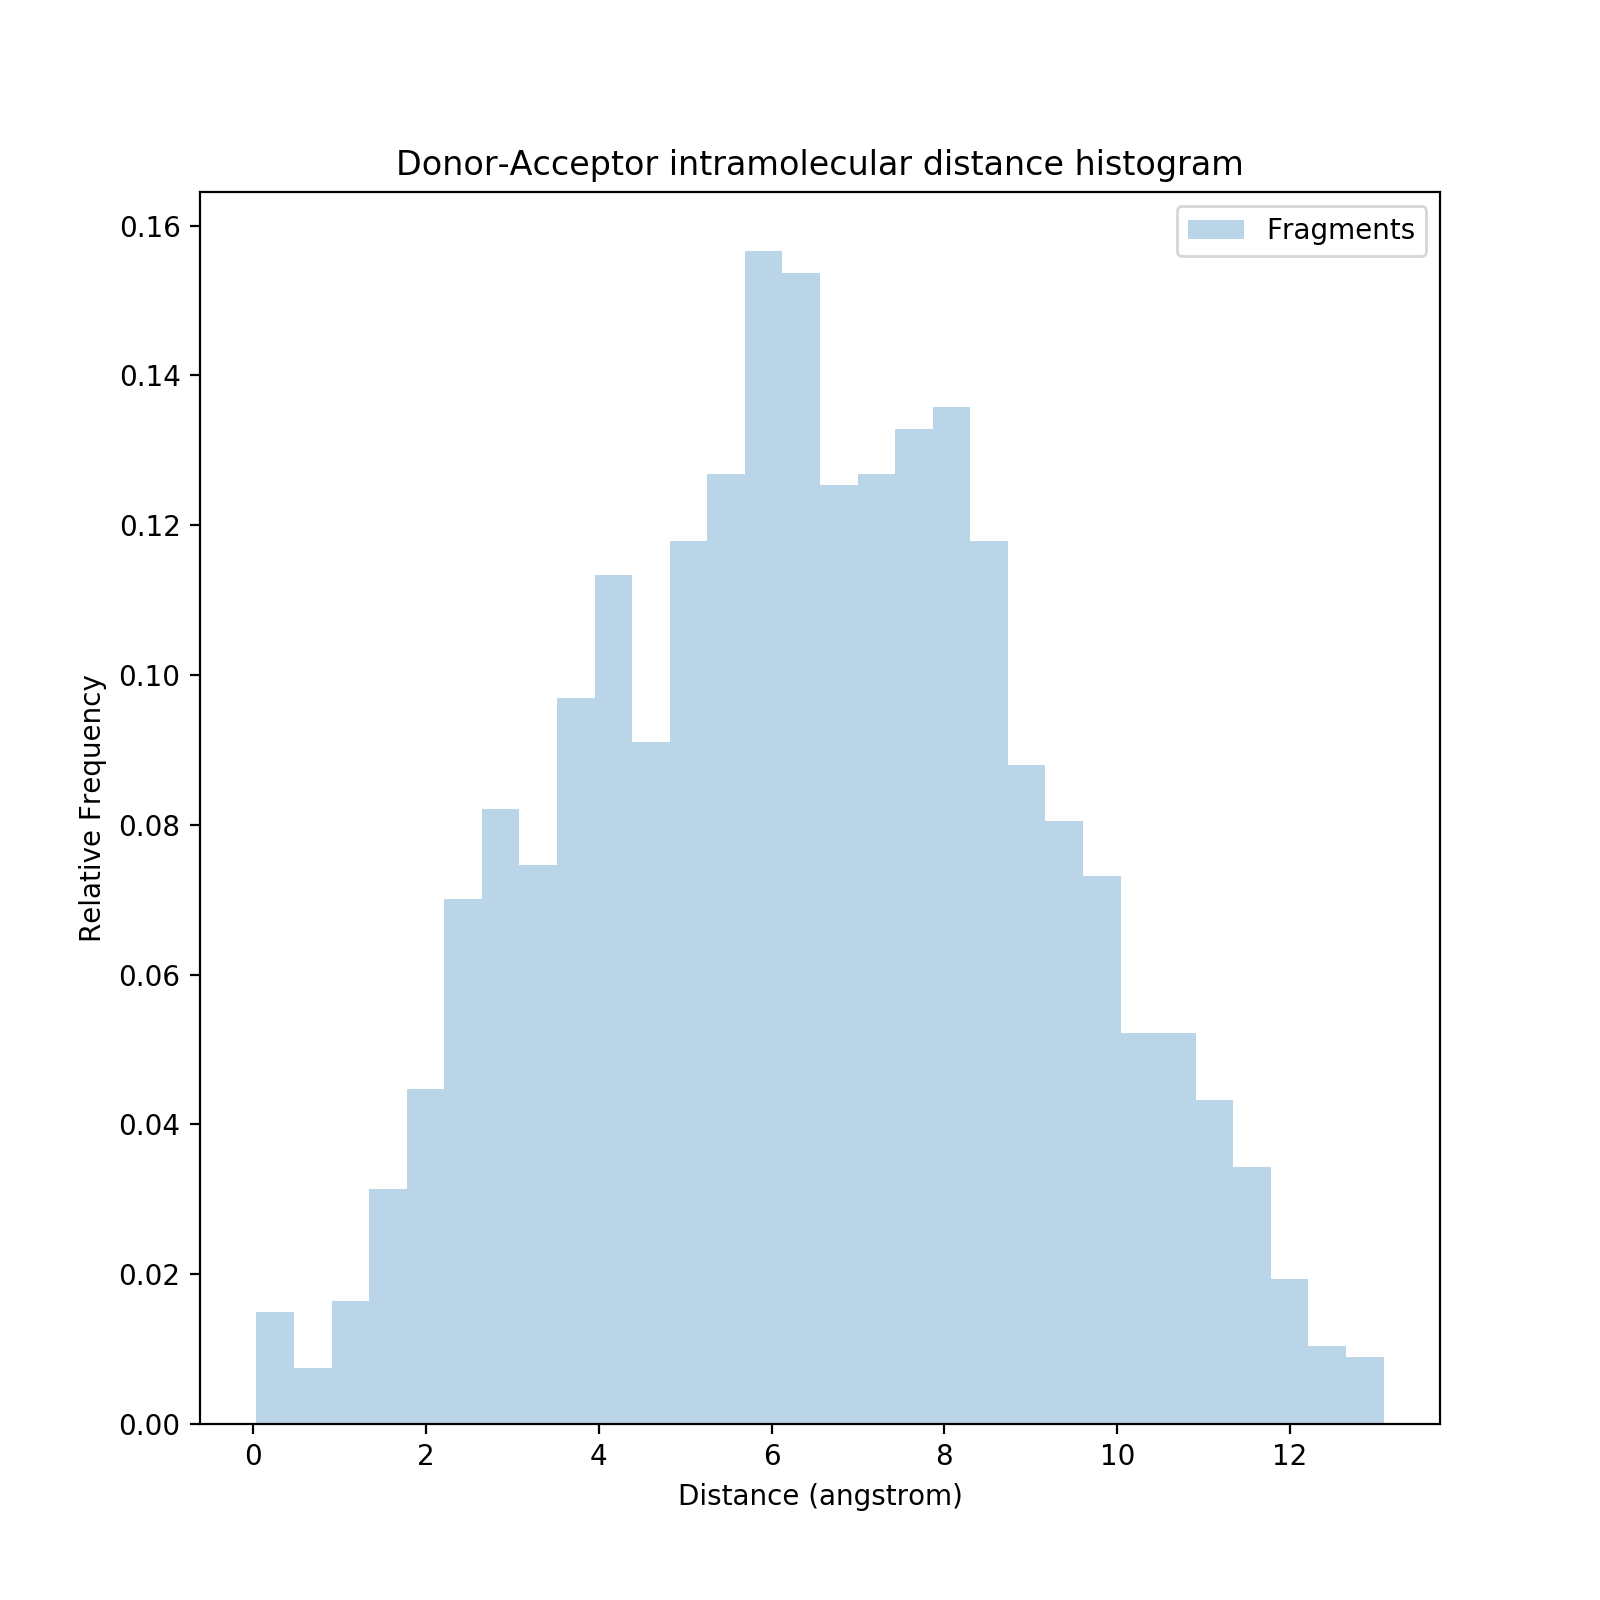

<IPython.core.display.Javascript object>


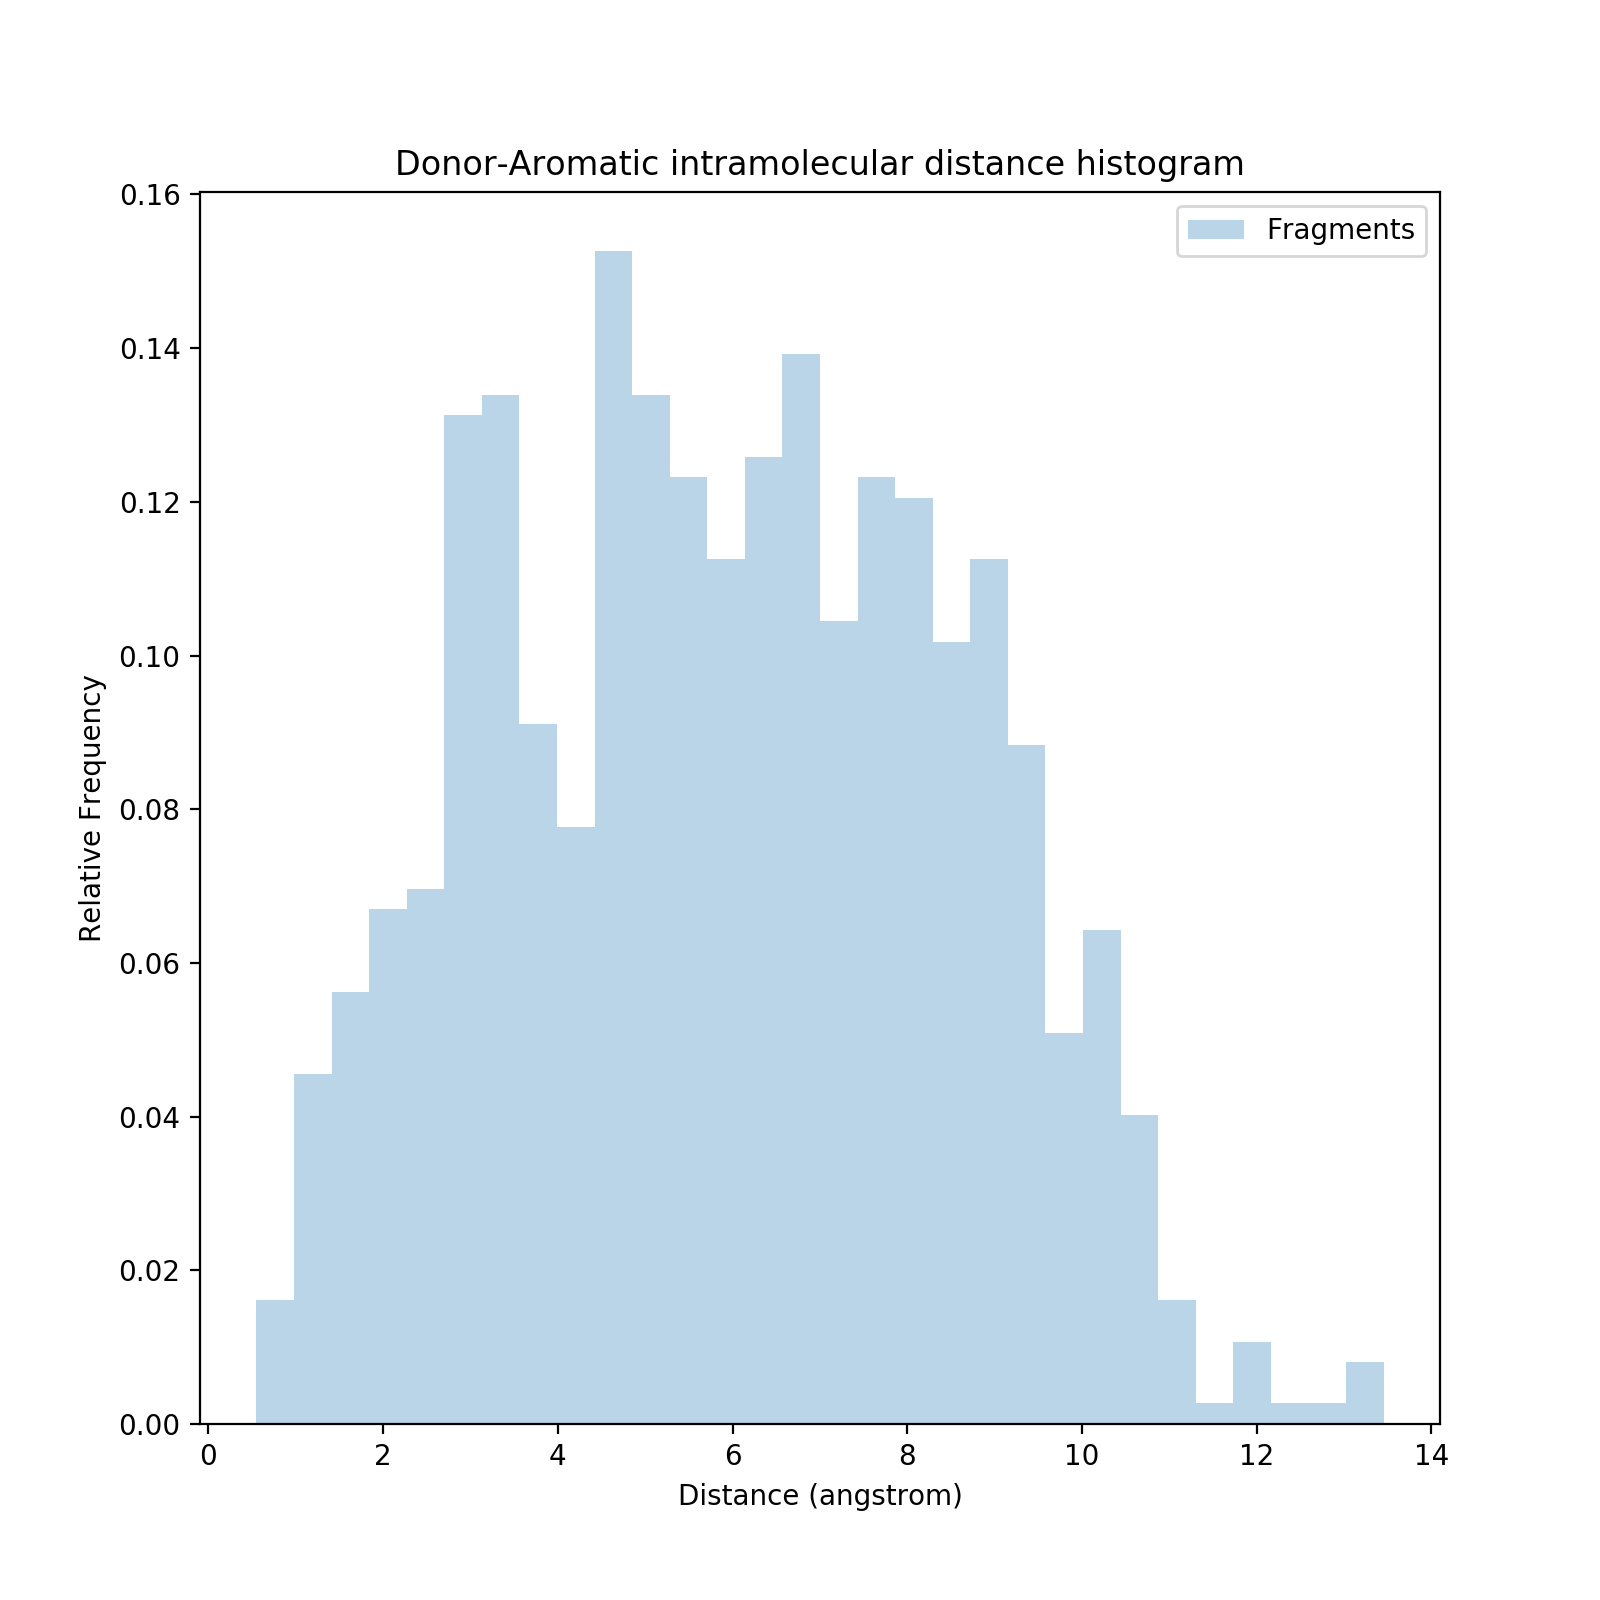

<IPython.core.display.Javascript object>


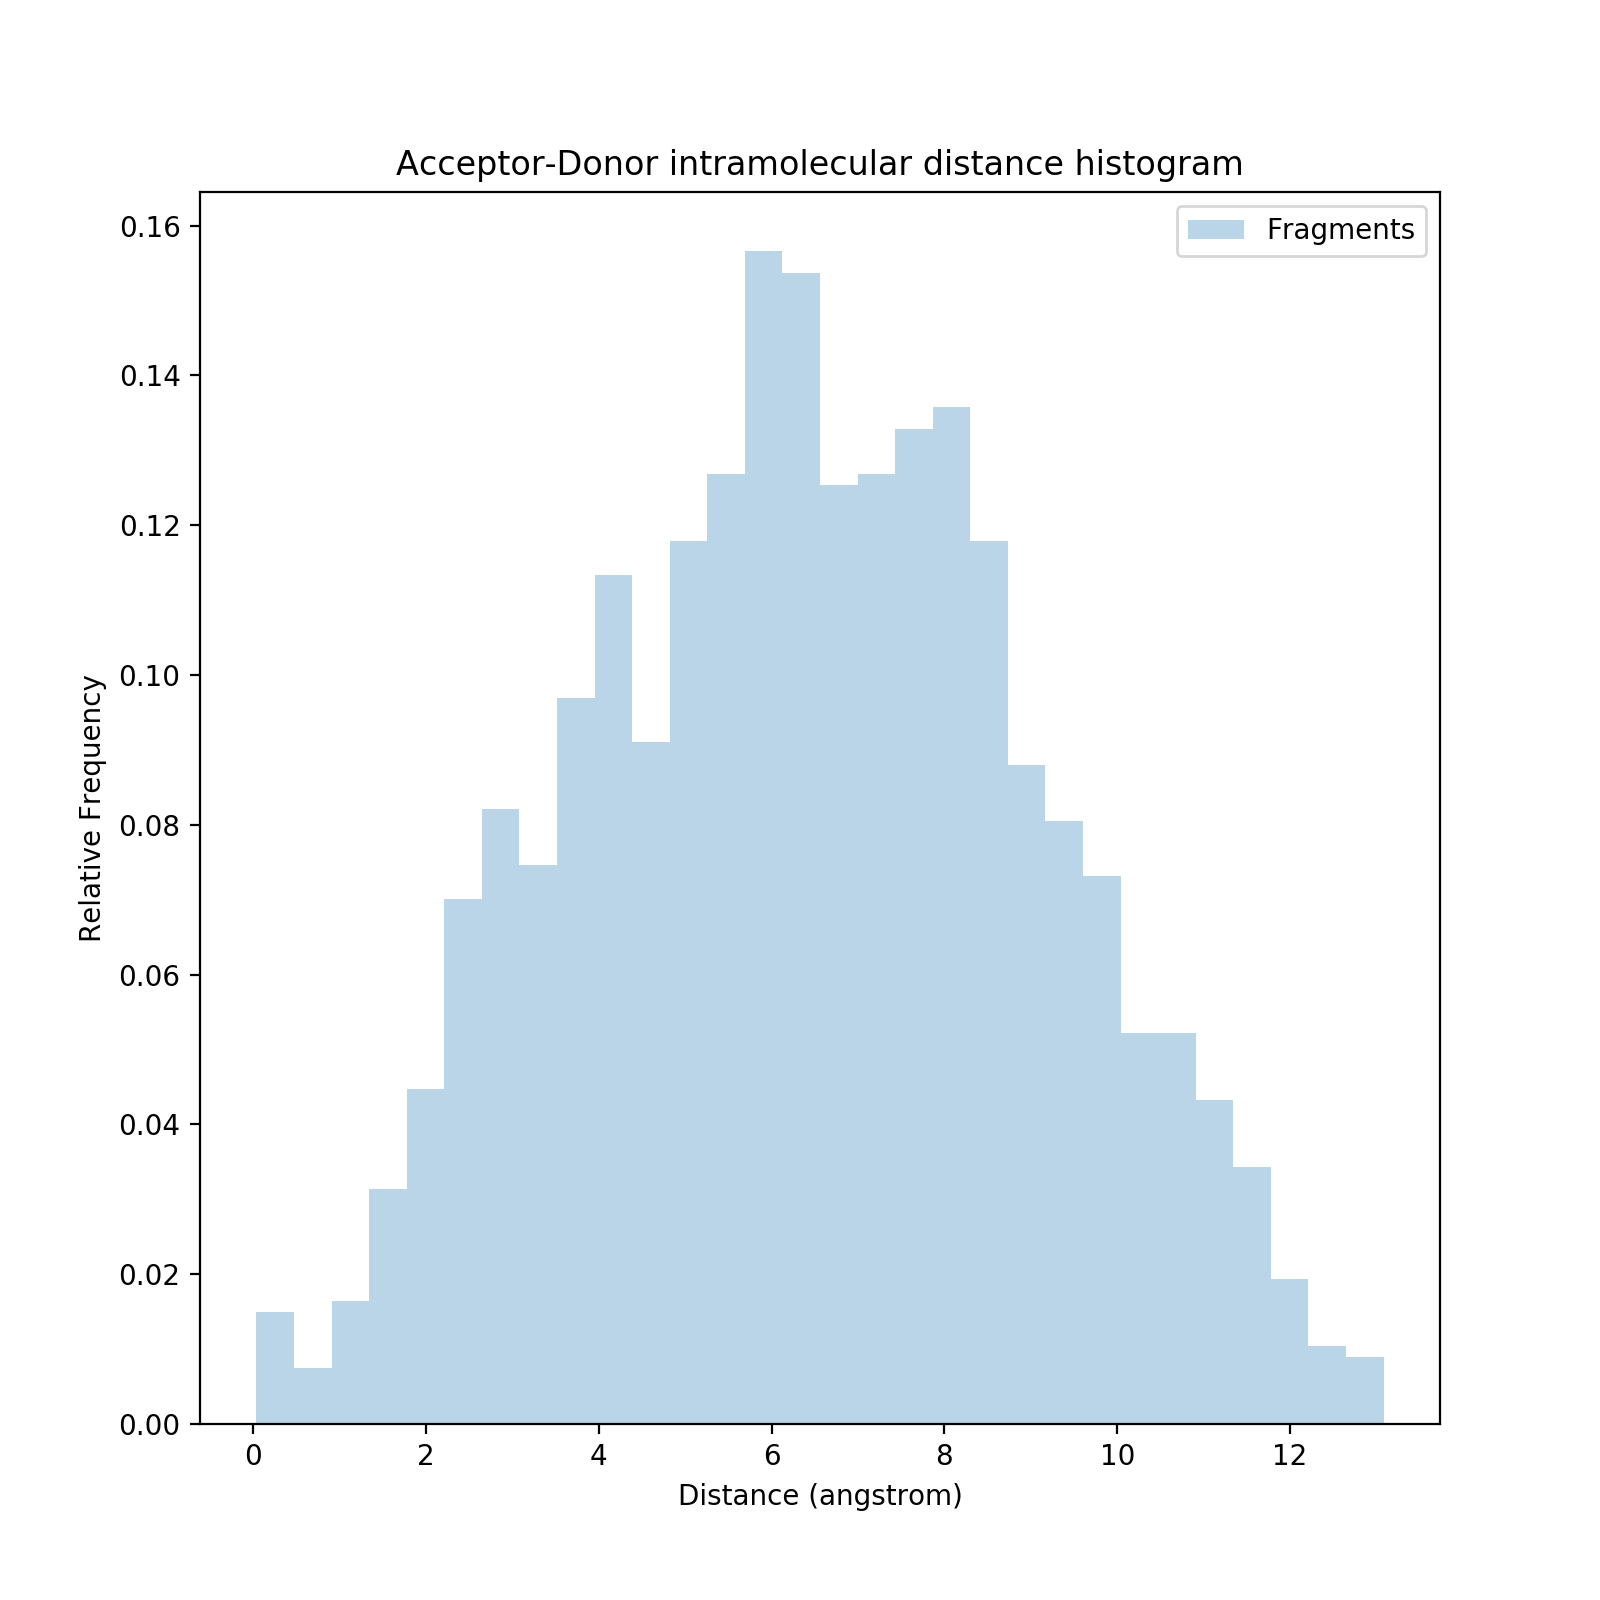

<IPython.core.display.Javascript object>


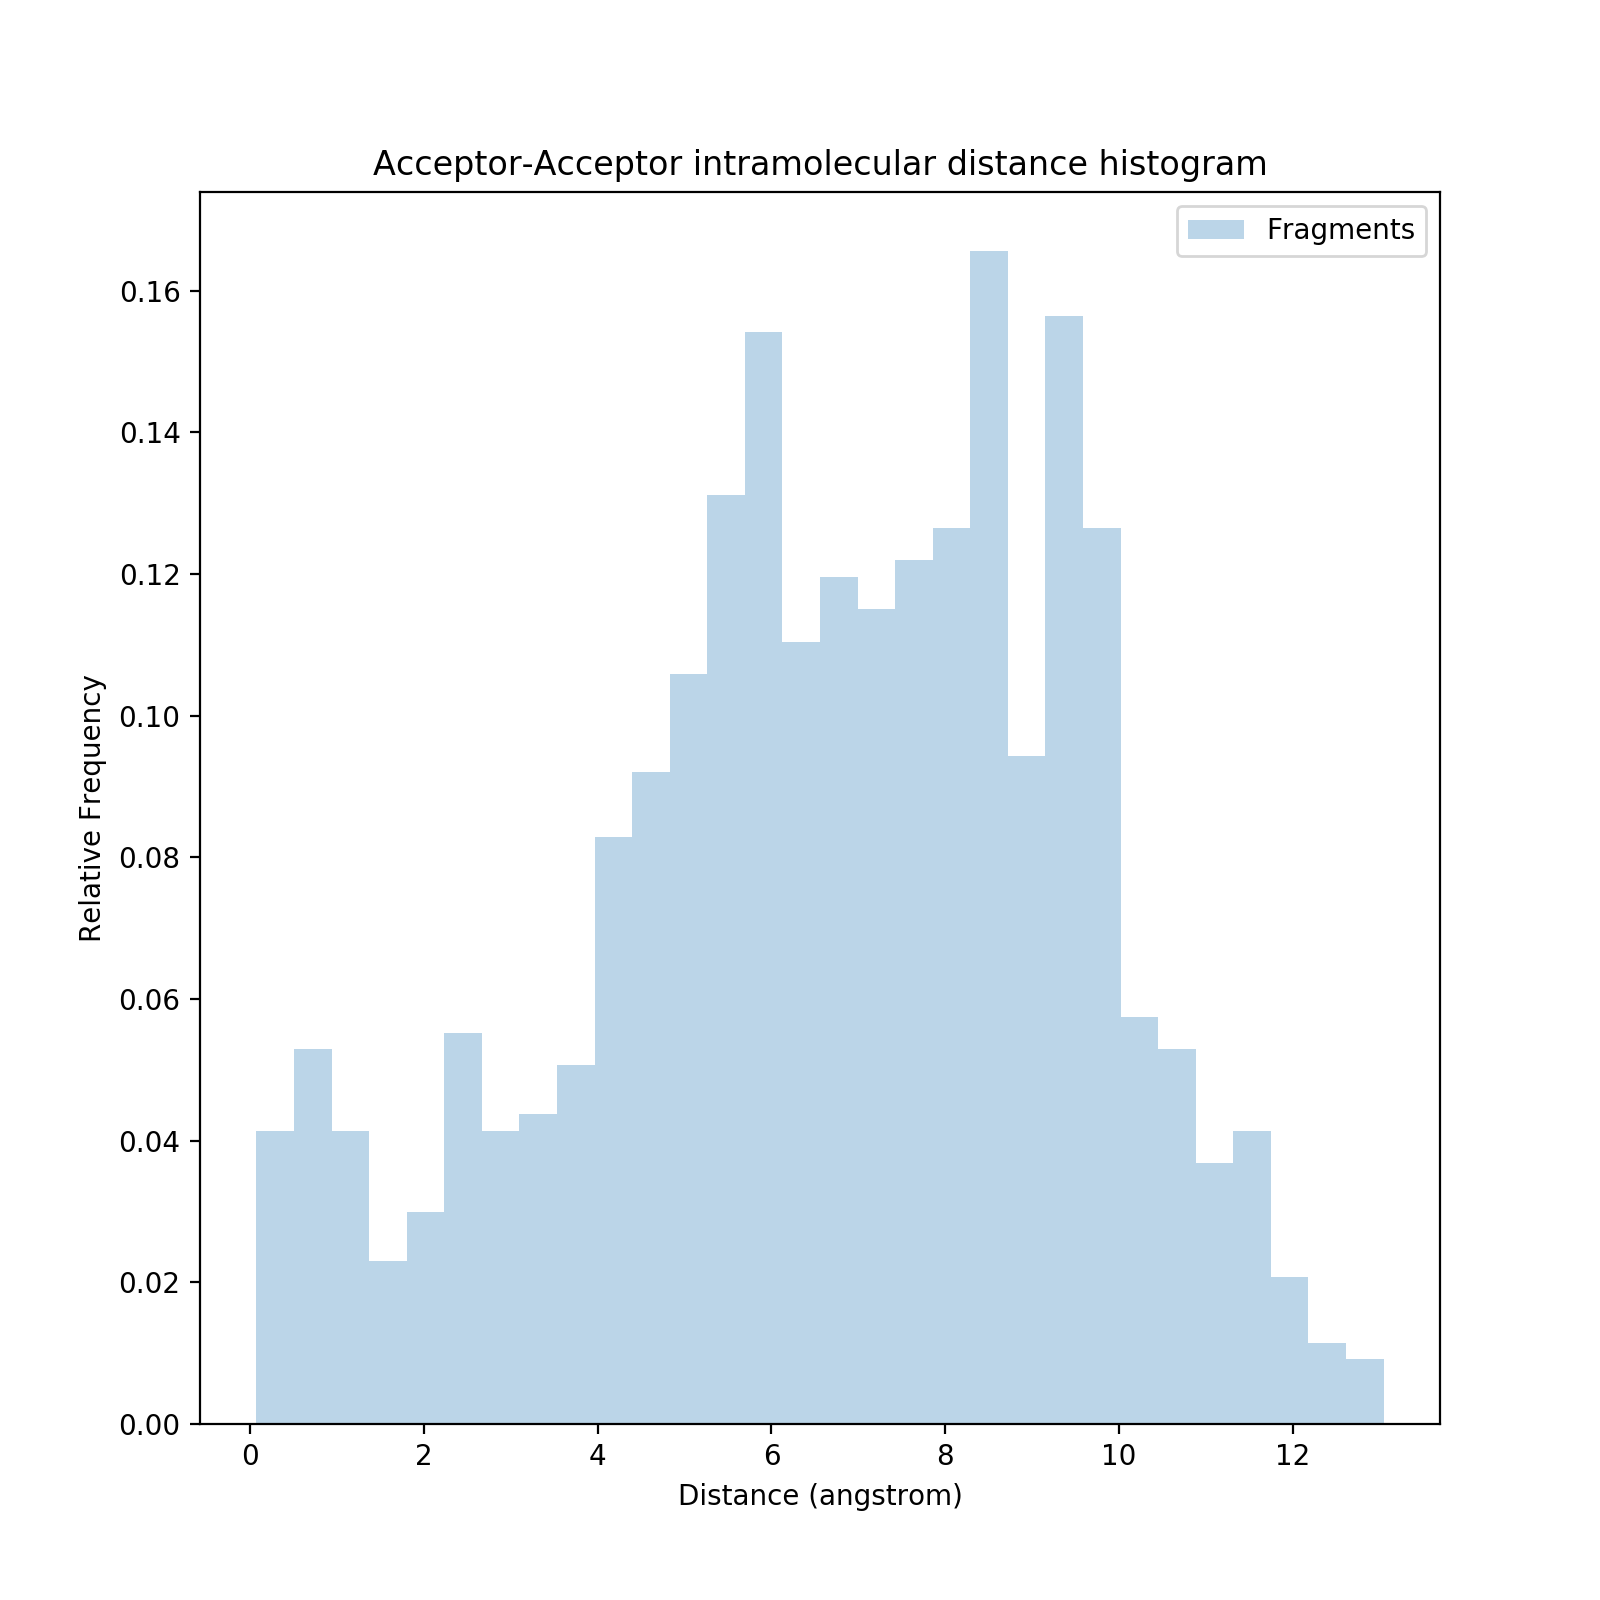

<IPython.core.display.Javascript object>


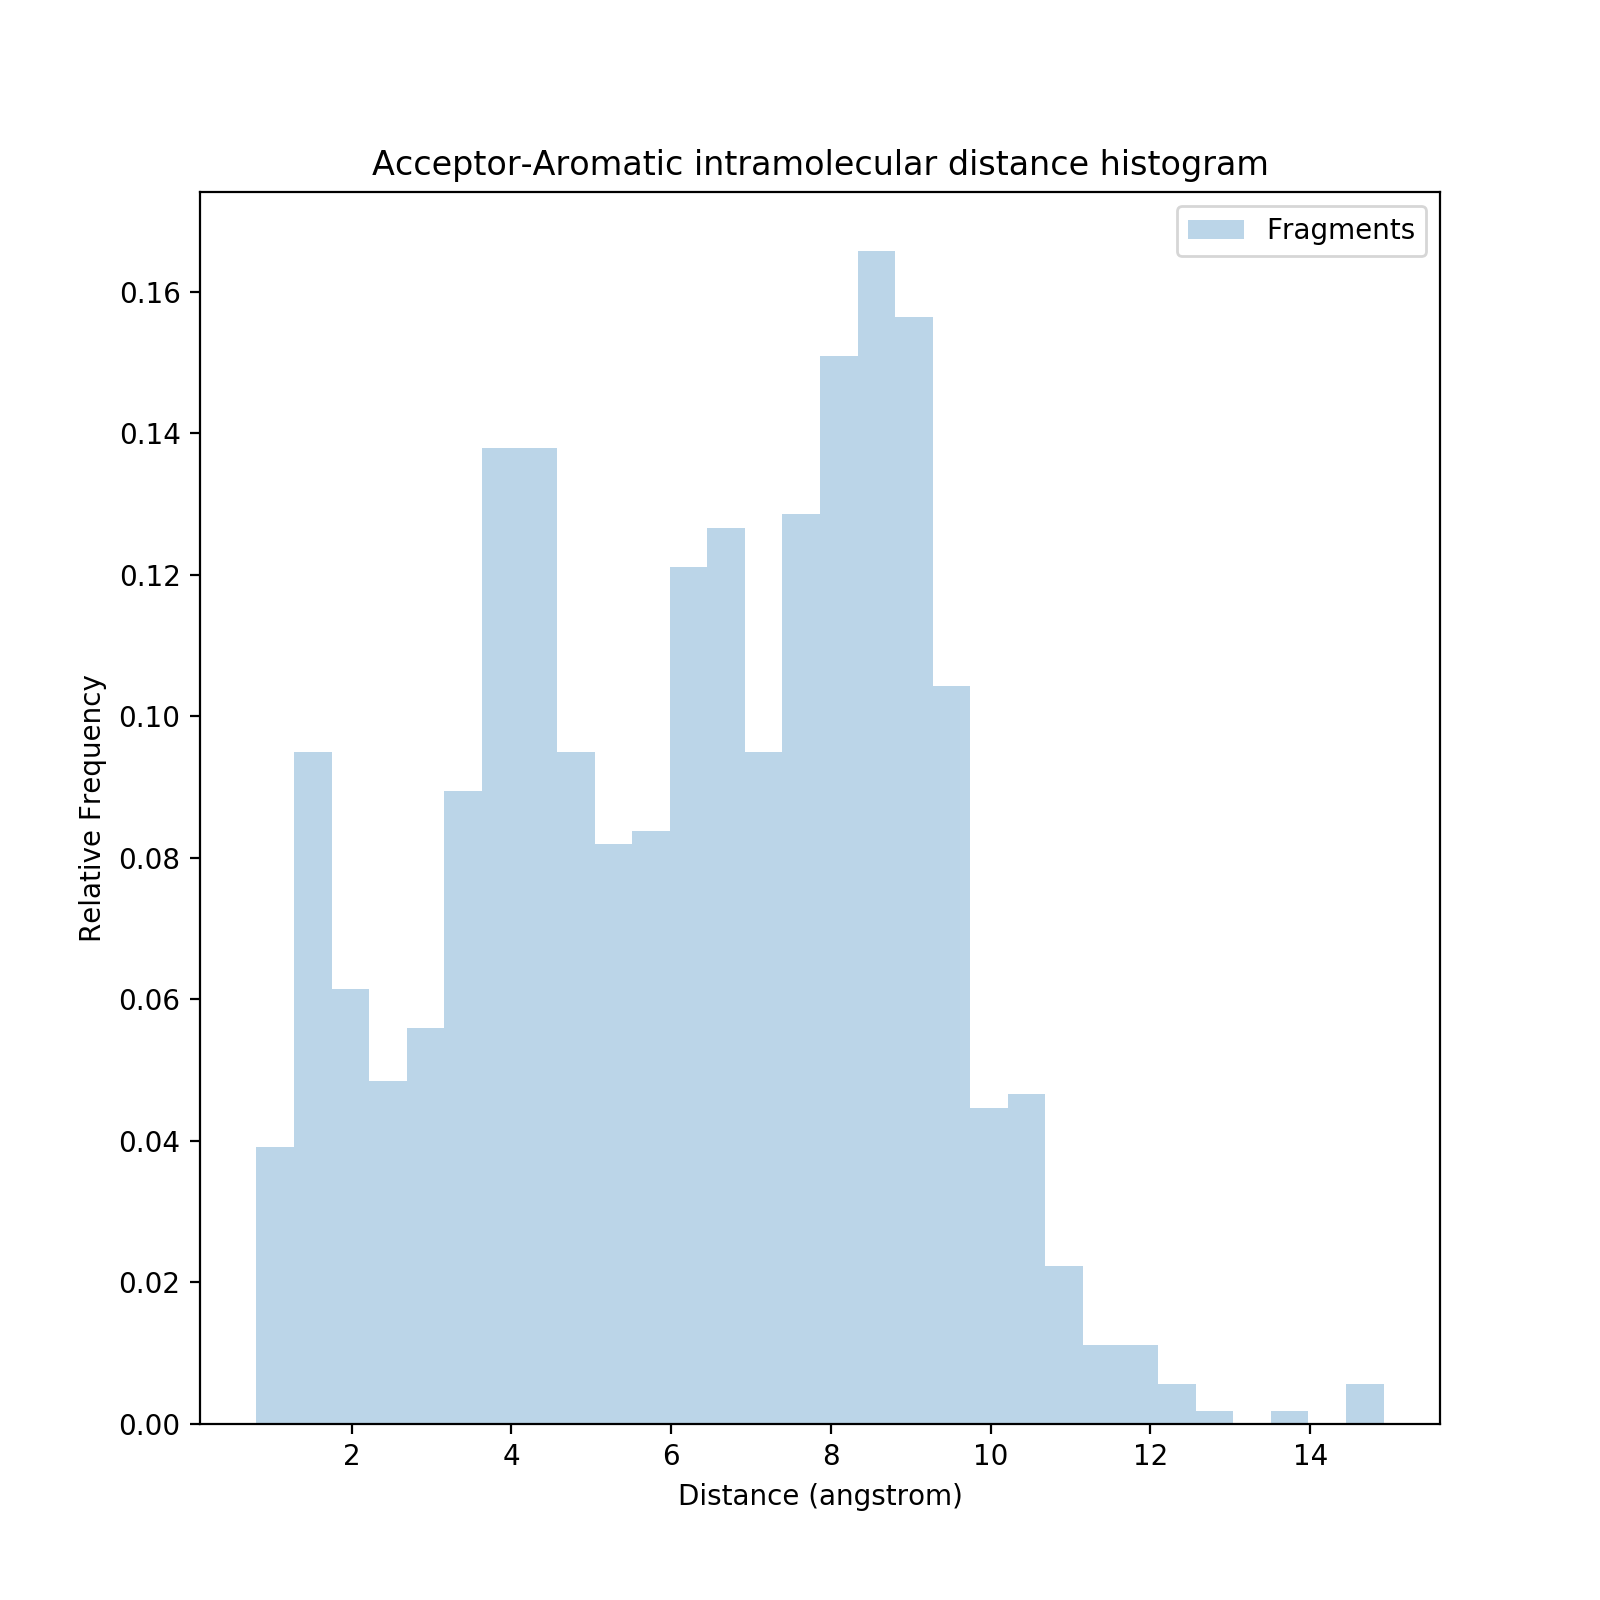

<IPython.core.display.Javascript object>


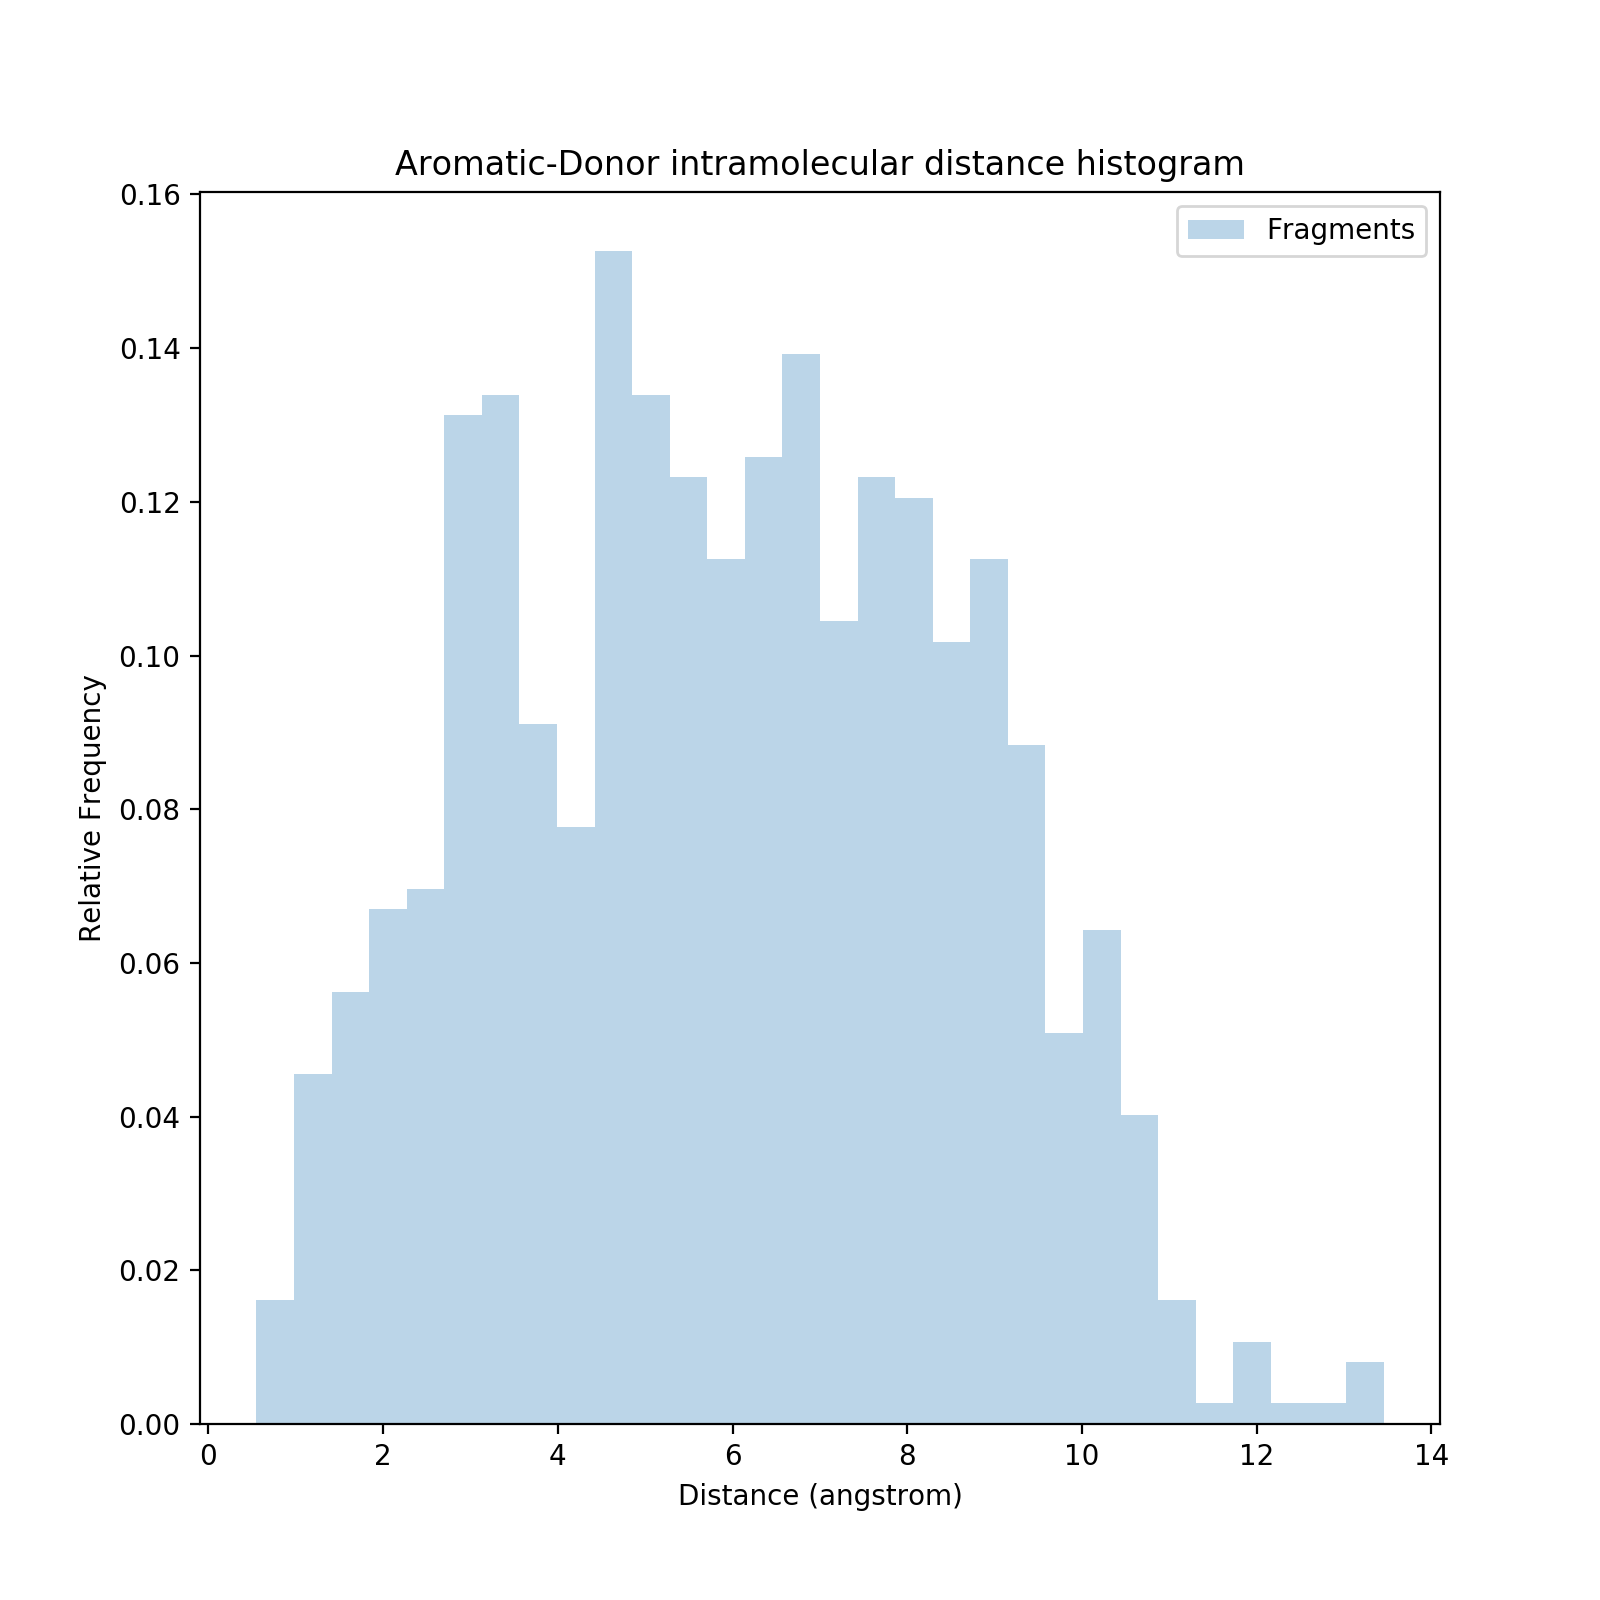

<IPython.core.display.Javascript object>


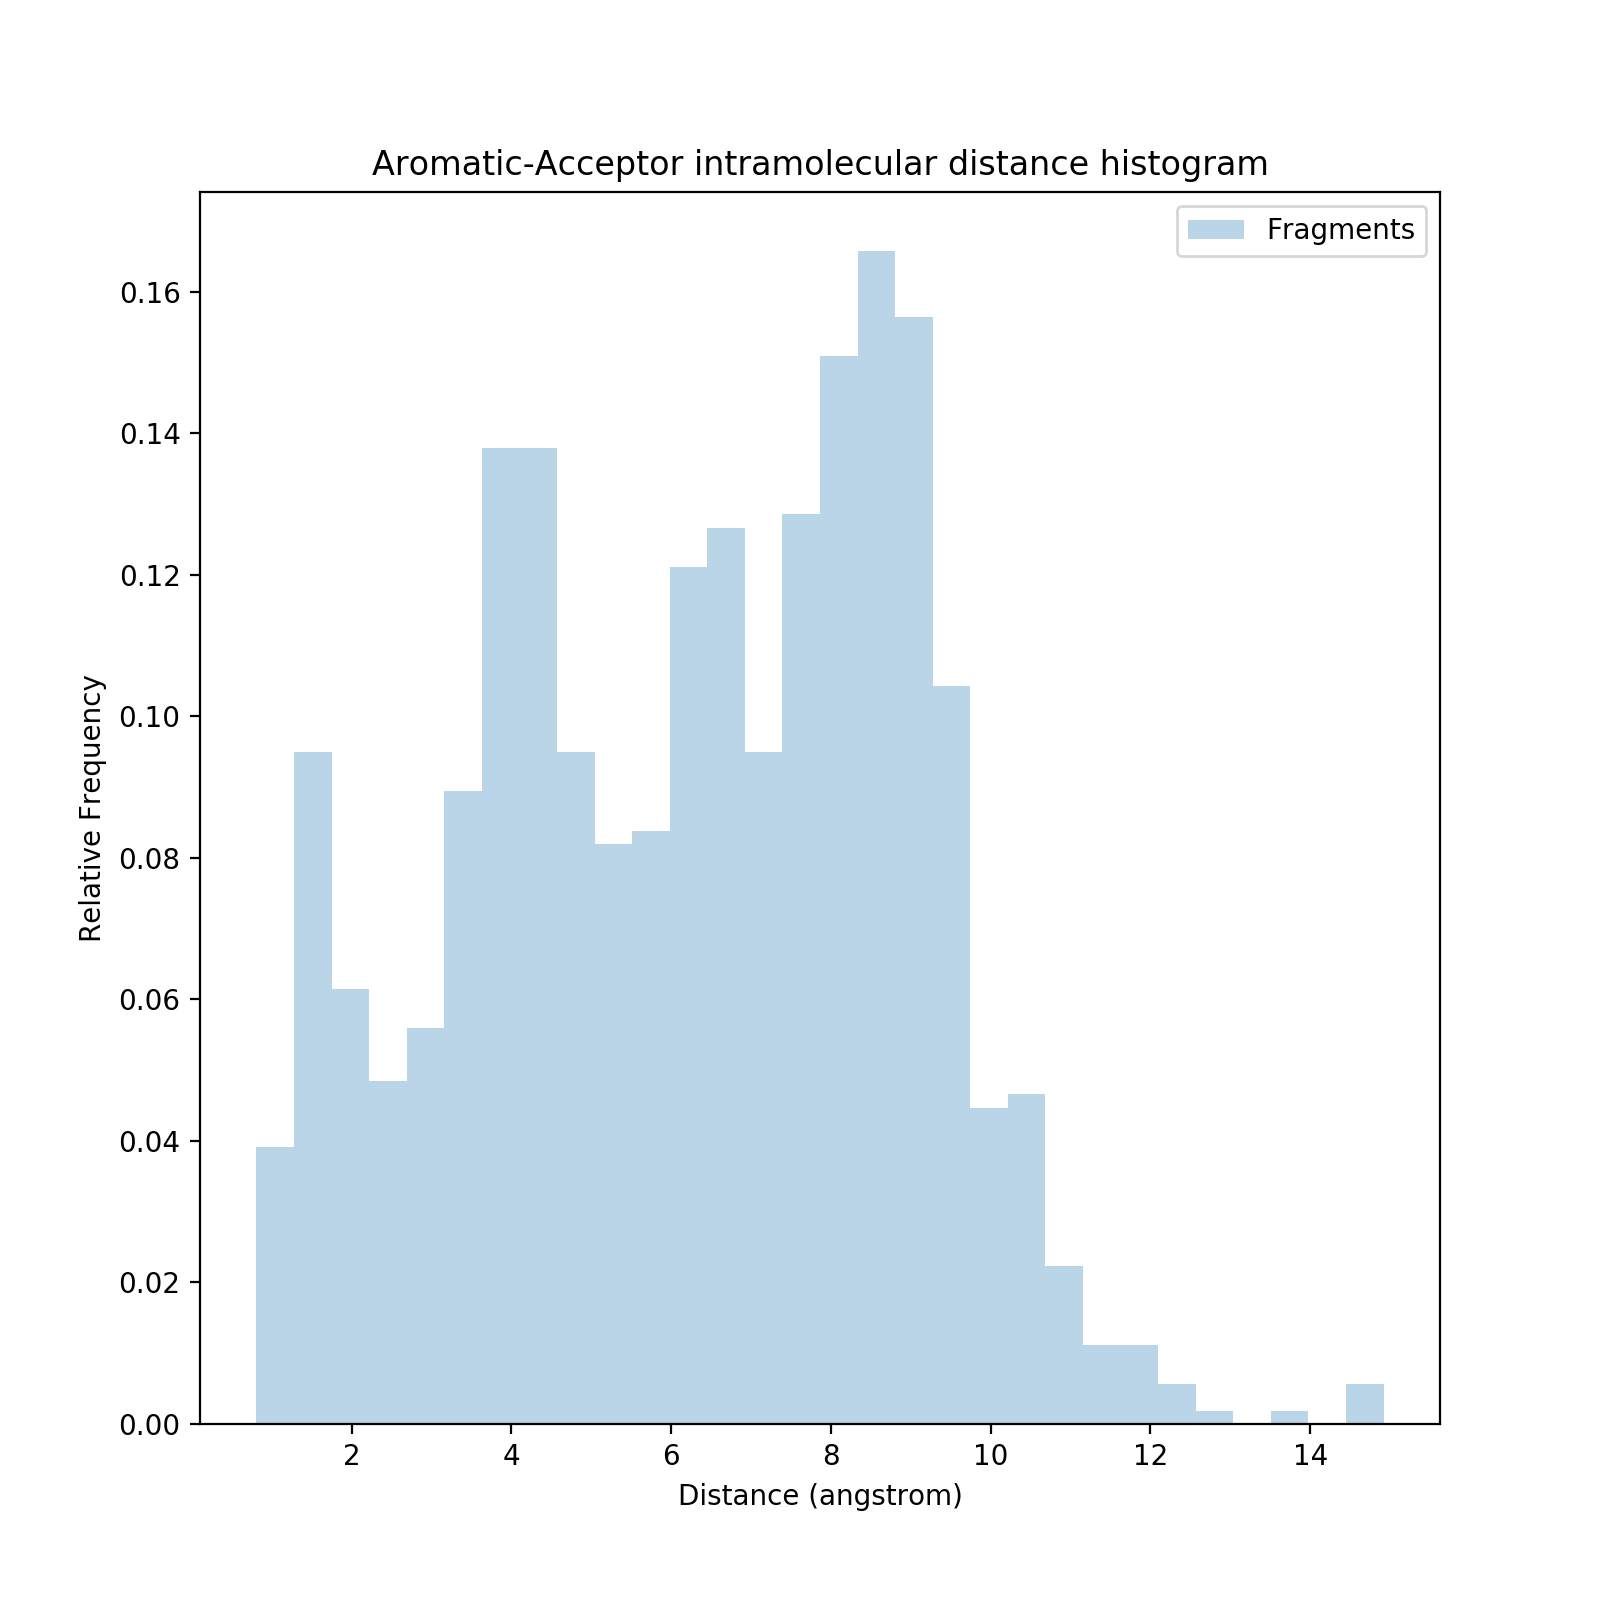

<IPython.core.display.Javascript object>


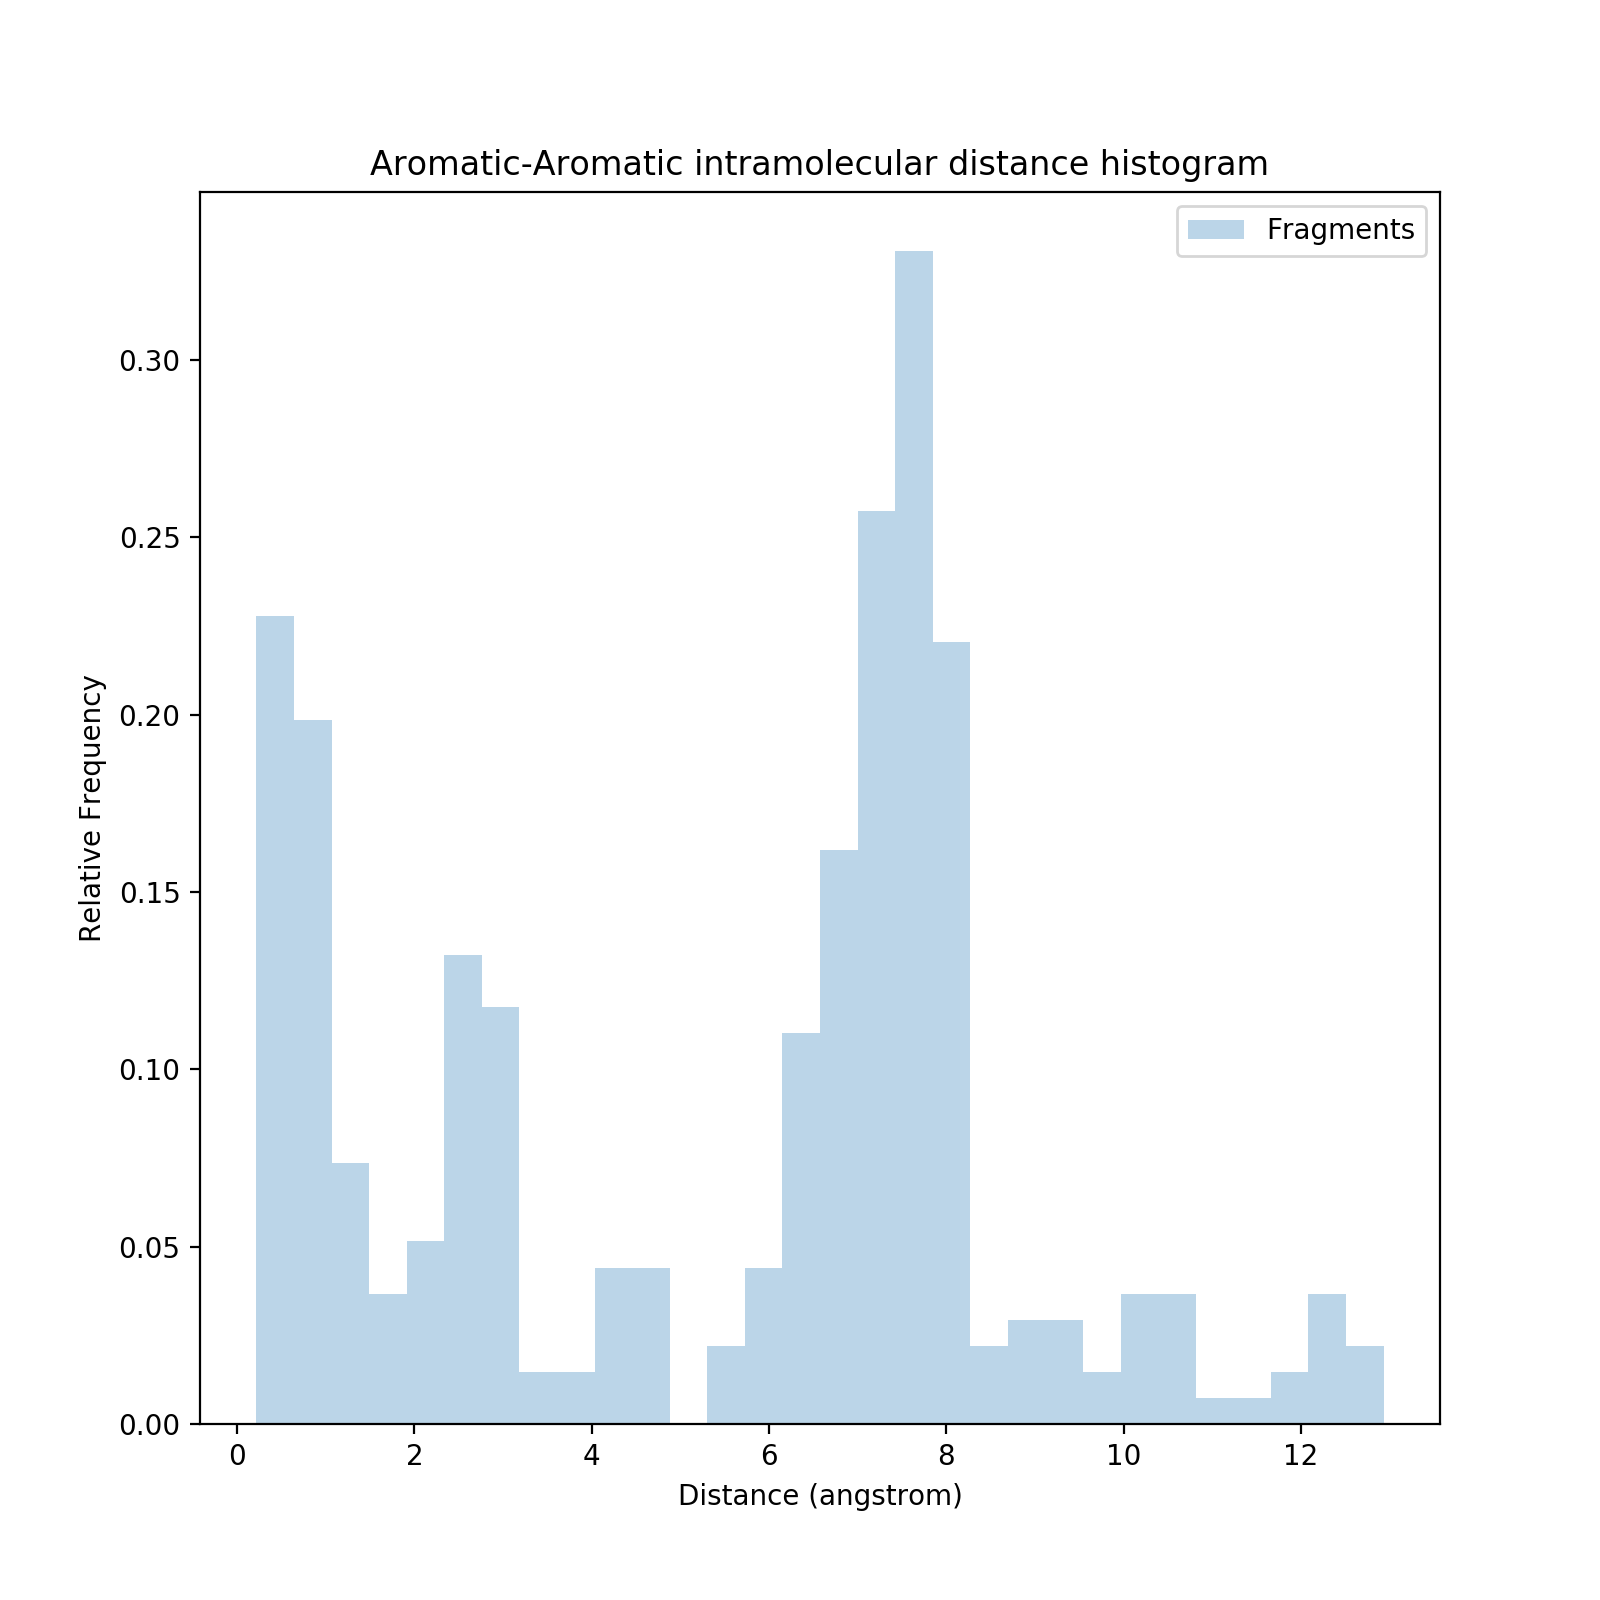

In [29]:
for pair in product(interesting_pcores,repeat=2):
    combo = pair[0]+'-'+pair[1]
# combos = ['Aromatic-Acceptor', 'Acceptor-Aromatic']
#     try:
# for combo in combos:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_title(combo+' intramolecular distance histogram')
    ax.set_xlabel('Distance (angstrom)')
    ax.set_ylabel('Relative Frequency')
    ax.hist(frag_pair_distance_dict[combo], bins=30, alpha = 0.3, density=True, label = 'Fragments')
    ax.legend()
    fig.show()
#     except:
#         pass

In [ ]:
# for frag_trip in tqdm(possible_trips[12:20]):
num_hist = 0
axis_names = []
hist_names = []
for frag_trip in product(possible,repeat=3):
    try:
        core_a, core_b, core_c = frag_trip
        combo = core_a+'-'+core_b+'-'+core_c    
        data = frag_trip_dist_dict[combo]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(combo+' 3D distribution histogram')
        ax.set_xlabel(core_a+'-'+core_b+' r')
        ax.set_ylabel(core_b+'-'+core_c+' r')
        ax.set_zlabel(core_c+'-'+core_a+' r')

        for xyz in data:
            im = ax.scatter(xyz[0], xyz[1], xyz[2], c='r')
        num_hist+=1
        axis_names.append([core_a,core_b,core_c])
        hist_names.append(combo)
#         plt.show()
    except Exception as ex:
        pass

In [ ]:
def kl_divergence(p, q):
    return np.sum(np.where((p != 0) & (q !=0), p * np.log(p / q), 0))

for pair in product(interesting_pcores,repeat=2):
    combo = pair[0]+'-'+pair[1]
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
#     ax.set_title(pair[0]+' intermolecular distance to '+pair[1]+' fragment field histogram')
    ax.set_title(combo+' intermolecular distance to fragment field histogram')
    ax.set_xlabel('Distance (angstrom)')
    ax.set_ylabel('Relative Frequency')
    
    frag_dat = frag_pair_distance_dict[combo]
    active_dat = active_pair_distance_dict[combo]
    inactive_dat = inactive_pair_distance_dict[combo]
    
    frag_counts, bins, _ = ax.hist(frag_dat, bins=60, alpha = 0.3, density=True, label = 'Fragments (N={})'.format(len(frag_dat)))
    active_counts, _, _ = ax.hist(active_dat, bins=bins, alpha = 0.3, density=True, label = 'Actives (N={})'.format(len(active_dat)))
    inactive_counts, _, _ = ax.hist(inactive_dat, bins=bins, alpha = 0.3, density=True, label = 'Inactives (N={})'.format(len(inactive_dat)))

    print('Active-Frag KL Divergence: {:.3f}'.format(kl_divergence(active_counts, frag_counts)))
    print('Inactive-Frag KL Divergence: {:.3f}'.format(kl_divergence(inactive_counts, frag_counts)))
    print('Active-Inactive KL Divergence: {:.3f}'.format(kl_divergence(active_counts, inactive_counts)))
    
    ax.legend()
    fig.show()
#     raise Exception


In [ ]:
num_hist = 0
axis_names = []
hist_names = []
for frag_trip in islice(product(interesting_pcores,repeat=3),5,6):
    core_a, core_b, core_c = frag_trip
    combo = core_a+'-'+core_b+'-'+core_c    
    print(combo)
    frag_data = frag_trip_distance_dict[combo]
    print('Number of Fragment Points: {}'.format(frag_data[1].shape[0]))
    active_data = active_trip_distance_dict[combo]
    print('Number of Active Points: {}'.format(active_data[1].shape[0]))
    inactive_data = inactive_trip_distance_dict[combo]
    print('Number of Inactive Points: {}'.format(inactive_data[1].shape[0]))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(combo+' correct 3D histogram')
    ax.set_xlabel(core_a+'-'+core_b+' r')
    ax.set_ylabel(core_b+'-'+core_c+' r')
    ax.set_zlabel(core_c+'-'+core_a+' r')

#     for frag in frag_data:
#         ax.scatter(frag[0], frag[1], frag[2], c='b', label='Fragments')
#     for active in active_data:
#         ax.scatter(active[0], active[1], active[2], c='r', label='Actives')
#     for inactive in inactive_data:
#         ax.scatter(inactive[0], inactive[1], inactive[2], c='g', label='Inactives')
    ax.scatter(frag_data[0], frag_data[1], frag_data[2], c='b', label='Fragments', alpha=0.1)
    ax.scatter(active_data[0], active_data[1], active_data[2], c='r', label='Actives')
    ax.scatter(inactive_data[0], inactive_data[1], inactive_data[2], c='g', label='Inactives')
        
    legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', label='Fragments',
                          markerfacecolor='b', markersize=15),
                   mpl.lines.Line2D([0], [0], marker='.', color='w', label='Actives',
                          markerfacecolor='r', markersize=15),
                   mpl.lines.Line2D([0], [0], marker='.', color='w', label='Inactives',
                          markerfacecolor='g', markersize=15)]
    ax.legend(handles=legend_elements, loc='lower right')
    
    num_hist+=1
    axis_names.append([core_a,core_b,core_c])
    hist_names.append(combo)
#         plt.show()


In [ ]:
h = 1

nx, ny, nz = (20, 20, 20)

def evaluate_phoreblob(xyz, coords, h=1):
    r = np.linalg.norm(xyz-coords)
    blob = np.exp(-r/h)
    return blob

x = np.linspace(0, 12, nx)
y = np.linspace(0, 12, ny)
z = np.linspace(0, 12, nz)
xv, yv, zv = np.meshgrid(x, y, z)

xv = xv.flatten().reshape(-1,1)
yv = yv.flatten().reshape(-1,1)
zv = zv.flatten().reshape(-1,1)
all_coords = np.hstack([xv,yv,zv])

histoblobs = np.empty((num_hist,len(all_coords)))

l = 0
for frag_trip in product(possible,repeat=3):
    try:
        core_a, core_b, core_c = frag_trip
        combo = core_a+'-'+core_b+'-'+core_c 
        data = frag_trip_dist_dict[combo]
#         print(all_coords)
#         print(data)
        histoblobs[l] = np.apply_along_axis(evaluate_phoreblob, 1, all_coords, coords=data, h=h)
        l+=1
    except Exception as ex:
#         print(ex)
        pass
print('Number of histograms = '+str(num_hist))

# fig = plt.figure(figsize=plt.figaspect(0.5))

fig = plt.figure(figsize=(10,10))


fig.suptitle('Kernel density estimate h={}'.format(h))

for n, frag_trip in enumerate(axis_names):
    core_a, core_b, core_c = frag_trip
    combo = core_a+'-'+core_b+'-'+core_c

    ax = fig.add_subplot(4,3,n+1, projection='3d')

    ax.set_title(combo)
    ax.set_xlabel(core_a)
    ax.set_ylabel(core_b)
    ax.set_zlabel(core_c)
    cm = plt.cm.get_cmap('viridis')

    pi_plot = histoblobs[n]
    # pi_plot = np.where(pi_plot>0.2, 0.2, pi_plot)


    vmin = pi_plot.min()
    vmax = pi_plot.max()
    #norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
    pi_plot = pi_plot /(pi_plot.max()-pi_plot.min())
    colors = cm(pi_plot)

    #potential = np.where(np.abs(potential)>1, 1, np.abs(potential))
    # alphas = np.square(pi_plot)/(pi_plot.max()-pi_plot.min())

    alphas = pi_plot
    alphas = np.where(alphas>1, 1, alphas)
    colors[:,3] = alphas
    #for i, j in enumerate(xv):
    im = ax.scatter(xv, yv, zv, c=colors)#alpha=(potential[i]-vmin)/(vmax-vmin))

### 3D blobs

In [ ]:
np.save('data/frag_hydroblobs.npy', frag_hydroblobs)
np.save('data/frag_aromblobs.npy', frag_aromblobs)
np.save('data/frag_hbablobs.npy', frag_hbablobs)

np.save('data/hit_hydroblobs.npy', hit_hydroblobs)
np.save('data/hit_aromblobs.npy', hit_aromblobs)
np.save('data/hit_hbablobs.npy', hit_hbablobs)

In [ ]:
frag_hydroblobs = np.load('data/frag_hydroblobs.npy')
frag_aromblobs = np.load('data/frag_aromblobs.npy')
frag_hbablobs = np.load('data/frag_hbablobs.npy')

frag_hydroblob = np.sum(frag_hydroblobs, axis=0)
frag_aromblob = np.sum(frag_aromblobs, axis=0)
frag_hbablob = np.sum(frag_hbablobs, axis=0)

hit_hydroblobs = np.load('data/hit_hydroblobs.npy')
hit_aromblobs = np.load('data/hit_aromblobs.npy')
hit_hbablobs = np.load('data/hit_hbablobs.npy')

hit_hydroblob = np.sum(hit_hydroblobs, axis=0)
hit_aromblob = np.sum(hit_aromblobs, axis=0)
hit_hbablob = np.sum(hit_hbablobs, axis=0)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title('frag hydrophobe mean field')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cm = plt.cm.get_cmap('viridis')


pi_plot = frag_hydroblob
# pi_plot = np.where(pi_plot>0.2, 0.2, pi_plot)
print()

vmin = pi_plot.min()
vmax = pi_plot.max()
#norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
# pi_plot = pi_plot /(pi_plot.max()-pi_plot.min())
colors = cm(pi_plot)

#potential = np.where(np.abs(potential)>1, 1, np.abs(potential))
# alphas = np.square(pi_plot)/(pi_plot.max()-pi_plot.min())

alphas = pi_plot
print(pi_plot.shape)
alphas = np.where(alphas>1, 1, alphas)
colors[:,3] = alphas
#for i, j in enumerate(xv):
im = ax.scatter(xv, yv, zv, c=colors)#alpha=(potential[i]-vmin)/(vmax-vmin))

In [ ]:
fig = plt.figure()
plt.hist(pi_plot, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

## Scoring fields

In [ ]:
scores_hydro_active = []
scores_arom_active = []
scores_hba_active = []
IC50s_active = []

scores_hydro_inactive = []
scores_arom_inactive = []
scores_hba_inactive = []
IC50s_inactive = []

for i,mol_field in enumerate(hit_hydroblobs):
    IC50 = hits[i][-1]
    if not math.isnan(IC50) and IC50<5:
        
#         IC50s[i] = 0.0
        IC50s_active.append(IC50)
        scores_hydro_active.append(np.vdot(hit_hydroblobs[i], frag_hydroblob))

        scores_arom_active.append(np.vdot(hit_aromblobs[i], frag_aromblob))

        scores_hba_active.append(np.vdot(hit_hbablobs[i], frag_hbablob))

    else:
        
#         IC50s[i] = 0.0
        IC50s_inactive.append(IC50)
        scores_hydro_inactive.append(np.vdot(hit_hydroblobs[i], frag_hydroblob))

        scores_arom_inactive.append(np.vdot(hit_aromblobs[i], frag_aromblob))

        scores_hba_inactive.append(np.vdot(hit_hbablobs[i], frag_hbablob))
#     else:
#         IC50s[i] = IC50


fig = plt.figure()
ax = fig.add_subplot()

# ax.scatter(scores_hba_inactive, scores_arom_inactive, c='r', label='inactive')
# ax.scatter(scores_hba_active, scores_arom_active, c='b', label='active')

# ax.set_xlabel('hba score')
# ax.set_ylabel('aromatic score')

# ax.scatter(scores_hydro_inactive, scores_arom_inactive, c='r', label='inactive')
# ax.scatter(scores_hydro_active, scores_arom_active, c='b', label='active')

# ax.set_xlabel('hydro score')
# ax.set_ylabel('aromatic score')

ax.scatter(scores_hba_inactive, scores_hydro_inactive, c='r', label='inactive')
ax.scatter(scores_hba_active, scores_hydro_active, c='b', label='active')

ax.set_xlabel('hba score')
ax.set_ylabel('hydro score')

ax.legend()
plt.show()

# print('number of actives: {}\n'.format(len(IC50s_active)))
# print('PM7 rho: {:.3f}'.format(spear(IC50s_active,scores_pm7_active)[0]))
# print('PM7 R2: {:.3f}'.format(r2_score(IC50s_active,scores_pm7_active)))

# print('pi rho: {:.3f}'.format(spear(IC50s_active,scores_pi_active)[0]))
# print('pi R2: {:.3f}'.format(r2_score(scores_pi_active,IC50s_active)))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.set_title('')
ax.set_xlabel('hydro score')
ax.set_ylabel('aromatic score')
ax.set_zlabel('hba score')

im = ax.scatter(scores_hba_inactive, scores_hydro_inactive, scores_arom_inactive, c='r')
im = ax.scatter(scores_hba_active, scores_hydro_active, scores_arom_active, c='b')

In [ ]:

orig_prop = len(IC50s_active)/(len(IC50s_active)+len(IC50s_inactive))
print('orig proportion of actives: {:.3f}%'.format(orig_prop*100))

n_inactives = 0
n_actives = 0
for i in range(len(IC50s_active)):
    if scores_pm7_active[i]>34 and scores_pi_active[i]>5800:
        n_actives+=1
for i in range(len(IC50s_inactive)):
    if scores_pm7_inactive[i]>34 and scores_pi_inactive[i]>5800:
        n_inactives+=1

new_prop = n_actives/(n_actives+n_inactives)
print('new proportion of actives: {:.3f}%'.format(new_prop*100))


EF = new_prop / orig_prop
print('Gaussian EF: {:.3f}'.format(EF))